# MC030 - Projeto final de Graduação
## Análise e Previsão do Mercado de Ações

## Descrição do modelo

A partir de um conjunto de cotações diárias de dólar para real (USD-BRL) desejamos modelar esse comportamento a partir de uma série de indicadores de mercado financeiro para classificarmos cada dia como um momento de compra ou momento de venda.

# ...

# Código

### Definindo endpoints da API (https://www.alphavantage.co/documentation/)

In [1]:
apiToken = '3GX5M109KQK9B6HO'
baseUrl = 'https://www.alphavantage.co/query?&outputsize=full&apikey=' + apiToken
usdBrlUrl = 'https://www.alphavantage.co/query?function=FX_DAILY&from_symbol=USD&to_symbol=BRL&outputsize=full&apikey=' + apiToken
stockUrl = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=MSFT&outputsize=full&apikey=demo'

### Obtendo dados da API

In [2]:
import requests
import json
import time

callsMade = 0

def incrementAndVerifyCallsMade():
    global callsMade
    callsMade += 1
    if callsMade == 5:
        print('Made 5 requests to the API in the last minute - sleeping for 1 minute')
        time.sleep(65)
        callsMade = 0

# returns [{date: {open, close, high, low, volume}}]
# all data is normalized/adjusted according to splits and dividends
def getStockPrice(stockSymbol):
    stockUrl = baseUrl + '&function=TIME_SERIES_DAILY_ADJUSTED&symbol=' + stockSymbol
    print('Fetching ' + stockUrl)
    incrementAndVerifyCallsMade()
    stocksRetrieved = requests.get(stockUrl).json();
    stocks = parseAndAdjustPrice(stocksRetrieved['Time Series (Daily)'])
    print('Retrieved and parsed '+ stockSymbol)
    return stocks

### Parseando dados da API

In [3]:
def parseAndAdjustPrice(stocksRetrieved):
    stockPrices = {}
    splitFactor = 1.0
    dividendsFactor = 1.0
    i = 0
    
    for date in reversed(sorted(stocksRetrieved.keys())):
        # Calculando valores ajustados
        todayOpen = float(stocksRetrieved[date]['1. open']) * dividendsFactor / splitFactor
        todayHigh = float(stocksRetrieved[date]['2. high']) * dividendsFactor / splitFactor
        todayLow = float(stocksRetrieved[date]['3. low']) * dividendsFactor / splitFactor
        todayClose = float(stocksRetrieved[date]['4. close']) * dividendsFactor / splitFactor
        todayVolume = float(stocksRetrieved[date]['6. volume']) * splitFactor
        
#         # Analisando possível erro -- nao funciona por razões de arredondamento (api deve ter dados com mais casas decimais)
#         if (int(todayClose*10000) != int(float(stocksRetrieved[date]['5. adjusted close'])*10000)):
#             print('Adjusted values dont match: (calculated) ' + str(int(todayClose*10000)) + ' vs ' + str(int(float(stocksRetrieved[date]['5. adjusted close'])*10000)) + ' (api)')
#             print('Aborting operation')
#             raise Exception('Adjusted values dont match')
        
        stockPrices[date] = {
            'open': todayOpen,
            'close': todayClose,
            'high': todayHigh,
            'low': todayLow,
            'volume': todayVolume,
        }

        # Calculando fatores históricos de split e dividendos (que irão afetar datas antes da atual)
        if (i+1 < len(stocksRetrieved.keys())):
            yesterdayDate = list(reversed(sorted(stocksRetrieved.keys())))[i+1]
            yesterdayClose = float(stocksRetrieved[yesterdayDate]['4. close'])
            splitFactor *= float(stocksRetrieved[date]['8. split coefficient'])
            dividendsFactor *= (yesterdayClose-float(stocksRetrieved[date]['7. dividend amount']))/yesterdayClose
            i += 1
        
    print('Preço final normalizado (calculado): ' + str(stockPrices[sorted(stockPrices.keys())[0]]['close'])
         + ' | ' + sorted(stockPrices.keys())[0])
    print('Preço final normalizado (api): ' + str(stocksRetrieved[sorted(stocksRetrieved.keys())[0]]['5. adjusted close'])
         + ' | ' + sorted(stocksRetrieved.keys())[0])
        
    return stockPrices

# returns [{date: price}]
def simplifyStockPrices(stockPrices):
    stockPricesSimplified = {}
    for date, stockData in stockPrices.items():
        stockPricesSimplified[date] = stockData['open']
    return stockPricesSimplified

### Obtendo indicadores

In [4]:
from talib.abstract import *
import numpy as np

# returns [date: [{indicatorFunction: indicatorValue}]]
def getIndicator(indicatorFunction, stockPrices):
    indicator = {}
    opens, highs, lows, closes, volumes = [], [], [], [], []
    
    for date in sorted(stockPrices.keys()):
        opens.append(stockPrices[date]['open'])
        highs.append(stockPrices[date]['high'])
        lows.append(stockPrices[date]['low'])
        closes.append(stockPrices[date]['close'])
        volumes.append(stockPrices[date]['volume'])
    
    inputs = {
        'open': np.array(opens),
        'high': np.array(highs),
        'low': np.array(lows),
        'close': np.array(closes),
        'volume': np.array(volumes)
    }
    
    if indicatorFunction=='SMA':
        indicatorList = SMA(inputs, timeperiod=10, price='open')
    elif indicatorFunction=='EMA':
        indicatorList = EMA(inputs, timeperiod=10, price='open')
    elif indicatorFunction=='WMA':
        indicatorList = EMA(inputs, timeperiod=10, price='open')
    elif indicatorFunction=='MACD':
        indicatorList, macdsignal, macdhist = MACD(inputs, fastperiod=12, slowperiod=26, signalperiod=9)
    elif indicatorFunction=='RSI':
        indicatorList = RSI(inputs, timeperiod=10, price='open')
    elif indicatorFunction=='ADX':
        indicatorList = ADX(inputs, timeperiod=10, price='open')
    elif indicatorFunction=='CCI':
        indicatorList = CCI(inputs, timeperiod=10, price='open')
    elif indicatorFunction=='MOM':
        indicatorList = MOM(inputs, timeperiod=10, price='open')
    elif indicatorFunction=='WILLR':
        indicatorList = WILLR(inputs, timeperiod=10, price='open')
    elif indicatorFunction=='AD':
        indicatorList = AD(inputs, timeperiod=10, price='open')
    elif indicatorFunction=='ADOSC':
        indicatorList = ADOSC(inputs, timeperiod=10, price='open')
    elif indicatorFunction=='OBV':
        indicatorList = OBV(inputs, timeperiod=10, price='open')
    
    i = 0
    indicators = {}
    for date in sorted(stockPrices.keys()):
        indicators[date] = {indicatorFunction: indicatorList[i]}
        i += 1
        
    print('Calculated and parsed indicator ' + indicatorFunction)
    return indicators

# returns [date: [{indicatorFunction: indicatorValue}]]
def getIndicatorList(indicatorFunctions, stockPrices):
    indicators = {}
    for indicatorFunction in indicatorFunctions:
        indicatorDict = getIndicator(indicatorFunction, stockPrices)
        for date, indicator in indicatorDict.items():
            for indicatorFunction, indicatorValue in indicator.items():
                if  date not in indicators:
                    indicators[date] = {}
                indicators[date][indicatorFunction] = indicatorValue
    return indicators

In [5]:
# Filtrando dados válidos - apenas aqueles cujas datas estão na lista de preços e de indicadores
def filterData(stocks, indicators, indicatorFunctions):
    filteredStocks = {date: stock for date, stock in stocks.items() if date in indicators.keys()}
    filteredIndicators = {date: indicators for date, indicators in indicators.items() if date in stocks.keys()}
    return filteredStocks, filteredIndicators

def getData(stockSymbol, indicatorFunctions):
    stockPricesDetailed = getStockPrice(stockSymbol)
    indicators = getIndicatorList(indicatorFunctions, stockPricesDetailed)
    stockPrices, indicators = filterData(stockPricesDetailed, indicators, indicatorFunctions)
    return stockPricesDetailed, indicators

### Métodos de anotação de dados

In [6]:
import collections

def annotateBuyOrSellTwoClasses(prices):
    dateAnnotated = {}
    yesterdayDate = ''
    earlierDate = ''
    last = ''
    for key, value in prices.items():
        yesterdayDate = key
        yesterdayPrice = float(value)
        break
    for date, price in prices.items():
        if float(price) > yesterdayPrice:
            dateAnnotated[yesterdayDate] = 'B'
            last = 'B'
        elif float(price) < yesterdayPrice:
            dateAnnotated[yesterdayDate] = 'S'
            last = 'S'
        else:
            dateAnnotated[yesterdayDate] = last
        yesterdayDate = date
        yesterdayPrice = float(price)
    return dateAnnotated

def annotateBuyOrSellEightClasses(prices):
    dateAnnotated = {}
    yesterdayDate = ''
    earlierDate = ''
    last = ''
    for key, value in prices.items():
        yesterdayDate = key
        yesterdayPrice = float(value)
        break
    for date, price in prices.items():
        if float(price) > yesterdayPrice and float(price)/yesterdayPrice <= 1.005:
            dateAnnotated[yesterdayDate] = 'B0'
            last = 'B0'
        elif float(price) > yesterdayPrice and float(price)/yesterdayPrice <= 1.01:
            dateAnnotated[yesterdayDate] = 'B1'
            last = 'B1'
        elif float(price) > yesterdayPrice and float(price)/yesterdayPrice <= 1.02:
            dateAnnotated[yesterdayDate] = 'B2'
            last = 'B2'
        elif float(price) > yesterdayPrice and float(price)/yesterdayPrice > 1.02:
            dateAnnotated[yesterdayDate] = 'B3'
            last = 'B3'
        elif float(price) < yesterdayPrice and float(price)/yesterdayPrice >= .995:
            dateAnnotated[yesterdayDate] = 'S0'
            last = 'S0'
        elif float(price) < yesterdayPrice and float(price)/yesterdayPrice >= .99:
            dateAnnotated[yesterdayDate] = 'S1'
            last = 'S1'
        elif float(price) < yesterdayPrice and float(price)/yesterdayPrice >= .98:
            dateAnnotated[yesterdayDate] = 'S2'
            last = 'S2'
        elif float(price) < yesterdayPrice and float(price)/yesterdayPrice < .98:
            dateAnnotated[yesterdayDate] = 'S3'
            last = 'S3'
        else:
            dateAnnotated[yesterdayDate] = last
        yesterdayDate = date
        yesterdayPrice = float(price)
    return dateAnnotated

def annotateMaxProfit(prices):
    dateAnnotated = {}
    yesterdayDate = ''
    yesterdayPrice = 0
    currentStatus = ''
    for key, value in prices.items():
        yesterdayDate = key
        yesterdayPrice = value
        break
    for date, price in prices.items():
        if price > yesterdayPrice and currentStatus != 'B':
            dateAnnotated[yesterdayDate] = 'B'
            currentStatus = 'B'
        elif price < yesterdayPrice and currentStatus != 'S':
            dateAnnotated[yesterdayDate] = 'S'
            currentStatus = 'S'
        yesterdayDate = date
        yesterdayPrice = price
    return dateAnnotated

### Normalização dos dados

In [7]:
import copy

# Normaliza um conjunto de indicadores a partir do preço da ação
def normalizeIndicators(indicatorSet, stocks):
    normalizedIndicatorSet = {}
    for indicatorFunction, indicatorValue in indicatorSet.items():
        # Normalizando baseado no preço
        if (indicatorFunction == 'SMA' or indicatorFunction == 'EMA'
            or indicatorFunction == 'ADX' or indicatorFunction == 'CCI' or indicatorFunction == 'MOM'
            or indicatorFunction == 'WILLR'):
            normalizedIndicatorSet[indicatorFunction] = float(indicatorValue)/float(stocks['close'])
        # Normalizando baseado no volume
        elif (indicatorFunction == 'AD' or indicatorFunction == 'ADOSC' or indicatorFunction == 'OBV'):
            normalizedIndicatorSet[indicatorFunction] = float(indicatorValue)/float(stocks['volume'])
        elif (indicatorFunction == 'MACD' or indicatorFunction == 'RSI'):
            normalizedIndicatorSet[indicatorFunction] = float(indicatorValue)/100.0
    return normalizedIndicatorSet

# Retorna os indicadores normalizados: indicadores = [date: {indicators: ['SMA': 0.89, 'EMA': 0.93], annotation: 'B'}]
def getIndicatorsNormalizedAndAnnotaded(stocks, indicators, dateAnnotated):
    print('Normalizing and annotating indicators')
    indicatorsAnnotated = {}
    for date, annotation in dateAnnotated.items():
        if date not in indicatorsAnnotated:
            indicatorsAnnotated[date] = {'indicators': {}, 'annotation': ''}
        indicatorsAnnotated[date]['indicators'] = normalizeIndicators(indicators[date], stocks[date])
        indicatorsAnnotated[date]['annotation'] = annotation
    return indicatorsAnnotated

### Machine Learning

In [8]:
import keras
adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

def getModelMLP(n_steps, n_features, n_outputs):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(n_steps*n_features*2, activation='relu', input_shape=(n_steps*n_features,)))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(n_steps*n_features*2, activation='relu'))
    model.add(keras.layers.Dropout(0.3))
    if (n_outputs > 1):
        activation = 'softmax'
        loss = 'categorical_crossentropy'
    else:
        activation = 'sigmoid'
        loss = 'binary_crossentropy'
    model.add(keras.layers.Dense(n_outputs, activation=activation))
    model.compile(loss=loss, optimizer=adam, metrics=['accuracy'])
    return model

def getModelLSTM(n_steps, n_features, n_outputs):    
    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(n_steps*n_features*3, activation='relu', input_shape=(n_steps, n_features)))
    if (n_outputs > 1):
        activation = 'softmax'
        loss = 'categorical_crossentropy'
    else:
        activation = 'sigmoid'
        loss = 'binary_crossentropy'
    model.add(keras.layers.Dense(n_outputs, activation=activation))
    model.compile(loss=loss, optimizer=adam, metrics=['accuracy'])
    return model

def getModelBidirectionalLSTM(n_steps, n_features, n_outputs):    
    model = keras.models.Sequential()
    model.add(keras.layers.Bidirectional(keras.layers.LSTM(n_steps*n_features*3, activation='relu'), input_shape=(n_steps, n_features)))
    if (n_outputs > 1):
        activation = 'softmax'
        loss = 'categorical_crossentropy'
    else:
        activation = 'sigmoid'
        loss = 'binary_crossentropy'
    model.add(keras.layers.Dense(n_outputs, activation=activation))
    model.compile(loss=loss, optimizer=adam, metrics=['accuracy'])
    return model

def getModelCNN(n_steps, n_features):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
    model.add(keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(50, activation='relu'))
    if (n_outputs > 1):
        activation = 'softmax'
        loss = 'categorical_crossentropy'
    else:
        activation = 'sigmoid'
        loss = 'binary_crossentropy'
    model.add(keras.layers.Dense(n_outputs, activation=activation))
    model.compile(loss=loss, optimizer='adam', metrics=['accuracy'])
    return model

Using TensorFlow backend.


### Análise de dados

In [9]:
import itertools
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    return cm

### Main

In [10]:
# Cheat-sheet com os simbolos
__indicatorSymbols = ['SMA', 'EMA', 'WMA', 'DEMA', 'TEMA', 'TRIMA', 'KAMA', 'MAMA',
                      'T3', 'MACD', 'MACDEXT', 'STOCH', 'STOCHF', 'RSI', 'STOCHRSI', 'WILLR', 
                      'ADX', 'ADXR', 'APO', 'PPO', 'MOM', 'BOP', 'CCI', 'CMO', 'ROC', 'ROCR',
                      'AROON', 'AROONOSC', 'MFI', 'TRIX', 'ULTOSC', 'DX', 'MINUS_DI', 'PLUS_DI',
                      'MINUS_DM', 'PLUS_DM', 'BBANDS', 'MIDPOINT', 'SAR', 'TRANGE', 'ATR',
                      'NATR', 'AD', 'ADOSC', 'OBV', 'HT_TRENDLINE', 'HT_SINE', 'HT_TRENDMODE',
                      'HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR']
__forexSymbols = ['BRL', 'EUR']
__stockSymbols = ['MSFT']

# Definindo simbolos para o modelo
indicatorFunctions = {}
indicatorFunctions[3] = ['SMA','MOM','WILLR']
indicatorFunctions[6] = ['SMA','MOM','WILLR', 'MACD','ADX','RSI']
indicatorFunctions[8] = ['SMA','MOM','WILLR', 'MACD','ADX','RSI','EMA','CCI']
indicatorFunctions[11] = ['SMA','EMA','MACD','RSI','ADX','CCI','MOM','WILLR','AD','OBV','ADOSC']
stockSymbol = 'IBM'

stocks, indicators = getData(stockSymbol, indicatorFunctions[11])
stockPrices = simplifyStockPrices(stocks)
# forexPrices, indicators = getForexData(fromForexSymbol, toForexSymbol, indicatorFunctions)
# dateAnnotated = annotateMaxProfit(stockPrices)

Fetching https://www.alphavantage.co/query?&outputsize=full&apikey=3GX5M109KQK9B6HO&function=TIME_SERIES_DAILY_ADJUSTED&symbol=IBM
Preço final normalizado (calculado): 78.14530996620734 | 1999-12-07
Preço final normalizado (api): 78.1403 | 1999-12-07
Retrieved and parsed IBM
Calculated and parsed indicator SMA
Calculated and parsed indicator EMA
Calculated and parsed indicator MACD
Calculated and parsed indicator RSI
Calculated and parsed indicator ADX
Calculated and parsed indicator CCI
Calculated and parsed indicator MOM
Calculated and parsed indicator WILLR
Calculated and parsed indicator AD
Calculated and parsed indicator OBV
Calculated and parsed indicator ADOSC


In [11]:
import pandas as pd

df = pd.DataFrame.from_dict(stockPrices, orient='index')

In [12]:
df[0] = df[0].astype('float')

In [13]:
div = df[0].astype('float').div(df[0].astype('float').shift(-1))

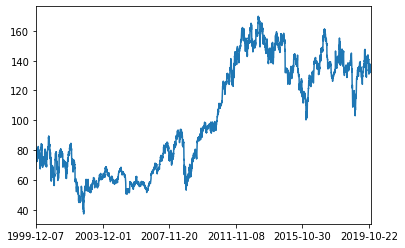

In [14]:
df.sort_index(inplace=True)
df[0].astype('float').plot()

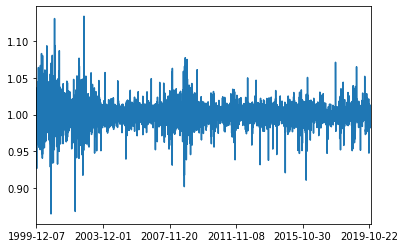

In [15]:
div.sort_index(inplace=True)
div.plot()

In [16]:
div.describe(percentiles=[.01,.1,.25,.5,.75,.9,.95,.99])

count    5032.000000
mean        1.000232
std         0.015928
min         0.864302
1%          0.952226
10%         0.984351
25%         0.993149
50%         1.000222
75%         1.007598
90%         1.015648
95%         1.022973
99%         1.046537
max         1.134492
Name: 0, dtype: float64

In [17]:
div

1999-12-07         NaN
1999-12-08    0.993590
1999-12-09    1.036559
1999-12-10    0.926307
1999-12-13    0.968644
                ...   
2019-12-02    1.006362
2019-12-03    0.981778
2019-12-04    1.006515
2019-12-05    1.000978
2019-12-06    0.998195
Name: 0, Length: 5033, dtype: float64

In [18]:
dateAnnotated = {}

dateAnnotated[2] = annotateBuyOrSellTwoClasses(stockPrices)
df = pd.DataFrame.from_dict(dateAnnotated[2], orient='index')
df[0].value_counts()

S    2565
B    2467
Name: 0, dtype: int64

In [19]:
dateAnnotated[8] = annotateBuyOrSellEightClasses(stockPrices)
df = pd.DataFrame.from_dict(dateAnnotated[8], orient='index')
df[0].value_counts()

B0    924
S0    911
S1    689
S2    640
B1    630
B2    561
B3    352
S3    325
Name: 0, dtype: int64

In [20]:
import pandas as pd

normalizedIndicators = {}
normalizedIndicators[2] = getIndicatorsNormalizedAndAnnotaded(stocks, indicators, dateAnnotated[2])
normalizedIndicators[8] = getIndicatorsNormalizedAndAnnotaded(stocks, indicators, dateAnnotated[8])

data = {}
data[2] = pd.DataFrame.from_dict(normalizedIndicators[2], orient='index')
data[8] = pd.DataFrame.from_dict(normalizedIndicators[8], orient='index')

Normalizing and annotating indicators
Normalizing and annotating indicators


In [21]:
data[2] = pd.DataFrame.merge(pd.DataFrame(data[2].indicators.values.tolist(), index=data[2].index), data[2], left_index=True, right_index=True, how='outer').drop(columns=['indicators'])
data[8] = pd.DataFrame.merge(pd.DataFrame(data[8].indicators.values.tolist(), index=data[8].index), data[8], left_index=True, right_index=True, how='outer').drop(columns=['indicators'])

In [22]:
data[2].head(), data[8].head()

(                 SMA       EMA      MACD       RSI       ADX       CCI  \
 2019-12-06  1.004962  1.002636 -0.008290  0.415802  0.121973 -0.183904   
 2019-12-05  1.015435  1.013976 -0.008782  0.427244  0.126195 -0.733564   
 2019-12-04  1.015630  1.014647 -0.007948  0.419456  0.121783 -0.740451   
 2019-12-03  1.016160  1.015437 -0.006849  0.368319  0.119405 -1.448802   
 2019-12-02  1.011850  1.013012 -0.005479  0.475770  0.101371 -0.828026   
 
                  MOM     WILLR          AD        OBV     ADOSC annotation  
 2019-12-06 -0.004879 -0.402741  115.429946  58.122051 -0.673353          B  
 2019-12-05 -0.008112 -0.588594  110.481809  56.525938 -0.542135          S  
 2019-12-04 -0.015304 -0.577139  113.185530  56.552830 -0.271853          S  
 2019-12-03 -0.017408 -0.558553  108.668795  52.885019 -0.038032          B  
 2019-12-02  0.000451 -0.664234  130.624921  65.152700 -0.247295          S  ,
                  SMA       EMA      MACD       RSI       ADX       CCI  \
 201

In [23]:
data[2].annotation = data[2].annotation.apply(lambda x: 0 if x == 'S' else 1)

eight_dict = {"B3":0, "B2": 1, "B1": 2, "B0": 3, "S0": 4, "S1": 5, "S2": 6, "S3": 7}
data[8].annotation = data[8].annotation.apply(lambda x: eight_dict[x])

In [24]:
data[2] = data[2].sort_index()
data[8] = data[8].sort_index()

In [25]:
data[2] = data[2].dropna()
data[8] = data[8].dropna()

In [26]:
len(data[2]), len(data[8])

(5000, 5000)

In [27]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.ensemble import ExtraTreesClassifier
import seaborn as sns

data_analysis = pd.DataFrame.merge(data[2], div, left_index=True, right_index=True, how='inner')
X = data_analysis.iloc[:,:8]
y = data_analysis.iloc[:,-1:]

In [28]:
bestfeatures = SelectKBest(score_func=f_classif, k=8)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
print(featureScores.nlargest(8,'Score'))

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


   Specs     Score
5    CCI  1.206070
0    SMA  1.198101
1    EMA  1.107002
3    RSI  0.901240
7  WILLR  0.854975
2   MACD  0.752701
4    ADX  0.679060
6    MOM  0.627974


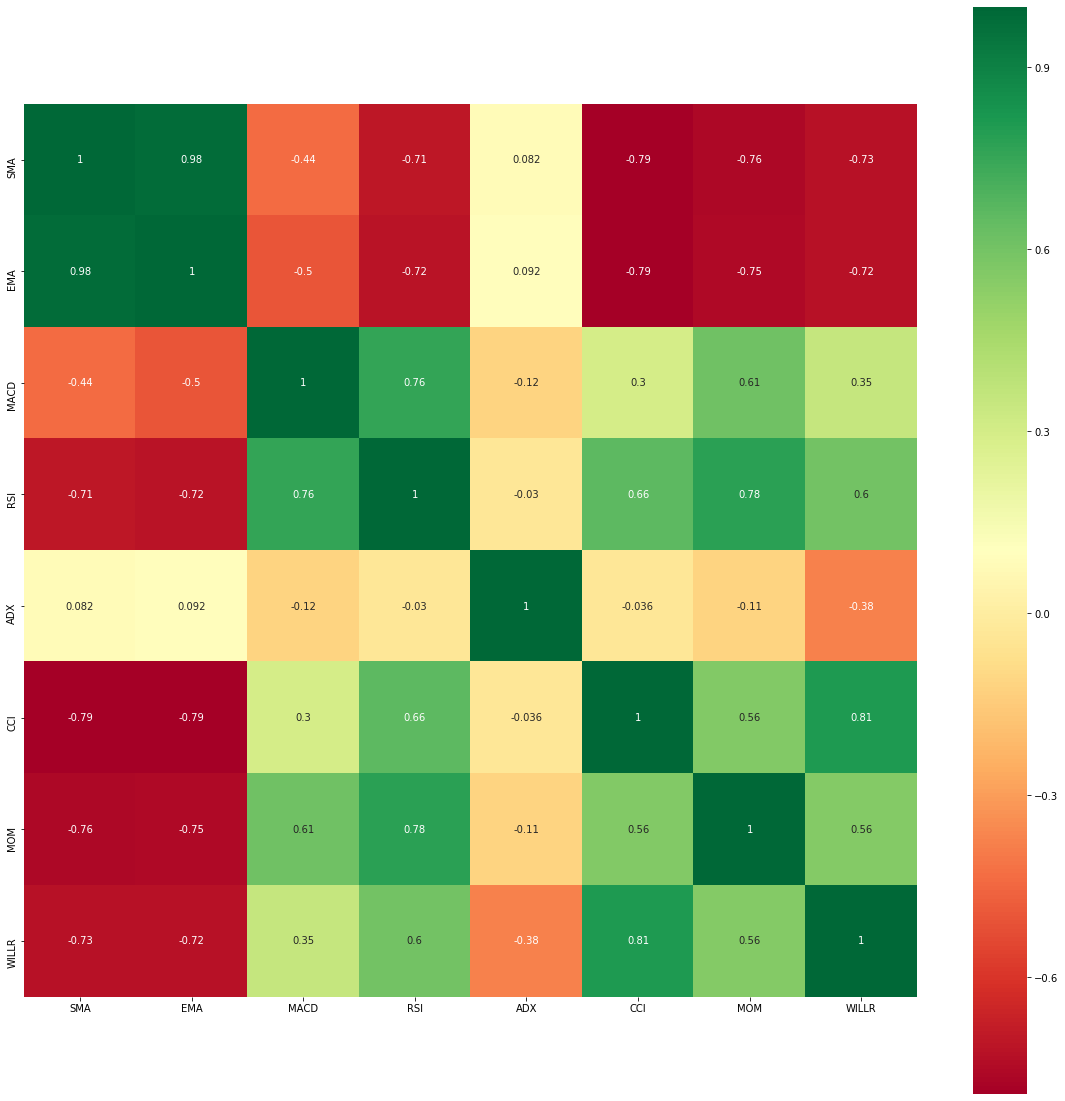

In [29]:
corrmat = data_analysis.iloc[:,:8].corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
plt.axis('scaled')
g=sns.heatmap(data_analysis[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [30]:
import numpy as np
import matplotlib.pyplot as plt

models = ["mlp","lstm"]
classes = {2: ["S","B"],
           8: ["B3","B2","B1","B0","S0","S1","S2","S3"]}
n_classes = [2, 8]
n_steps = [2,5,10]
n_indicators = [3, 6, 8, 11]
n_indicators_names = {
    3: ['SMA','MOM','WILLR'], 
    6: ['SMA','MOM','WILLR', 'MACD','ADX','RSI'],
    8: ['SMA','MOM','WILLR', 'MACD','ADX','RSI','EMA','CCI'],
    11: ['SMA','MOM','WILLR', 'MACD','ADX','RSI','EMA','CCI','AD','OBV','ADOSC']
}

batch_size = 32
train_split = .8

# X [d: (all, train, test)] [m: type(mlp/lstm)] [c: classes(2, 8)] [s: n_steps(2,5,10)] [i: indicators(3, 6)] 

In [31]:
X = {}
y = {}
for a in ["all", "train", "test"]:
    X[a] = {}
    y[a] = {}
    for m in models:
        X[a][m] = {}
        y[a][m] = {}
        for c in n_classes:
            X[a][m][c] = {}
            y[a][m][c] = {}
            for s in n_steps:
                X[a][m][c][s] = {}
                y[a][m][c][s] = {}
                for i in n_indicators:
                    X[a][m][c][s][i] = []
                    y[a][m][c][s][i] = []
                    if a == "all":
                        for d in range(len(data[c])):
                            end_ix = d + s
                            if end_ix > len(data[c]):
                                break
                            seq_x, seq_y = data[c].loc[data[c].index.isin(data[c].index[d:end_ix]), n_indicators_names[i]].values, data[c].iloc[end_ix-1, -1]
                            if m == "lstm":
                                X[a][m][c][s][i].append(seq_x)
                            else:
                                X[a][m][c][s][i].append(seq_x.flatten())
                            if c == 2:
                                y[a][m][c][s][i].append(seq_y)
                            else:
                                y[a][m][c][s][i].append(np.eye(c)[seq_y])
                        X[a][m][c][s][i] = np.array(X[a][m][c][s][i])
                        y[a][m][c][s][i] = np.array(y[a][m][c][s][i])

In [32]:
a = 'all'
for m in models:
    for c in n_classes:
        for s in n_steps:
            for i in n_indicators:
                print(X[a][m][c][s][i].shape, y[a][m][c][s][i].shape)

(4999, 6) (4999,)
(4999, 12) (4999,)
(4999, 16) (4999,)
(4999, 22) (4999,)
(4996, 15) (4996,)
(4996, 30) (4996,)
(4996, 40) (4996,)
(4996, 55) (4996,)
(4991, 30) (4991,)
(4991, 60) (4991,)
(4991, 80) (4991,)
(4991, 110) (4991,)
(4999, 6) (4999, 8)
(4999, 12) (4999, 8)
(4999, 16) (4999, 8)
(4999, 22) (4999, 8)
(4996, 15) (4996, 8)
(4996, 30) (4996, 8)
(4996, 40) (4996, 8)
(4996, 55) (4996, 8)
(4991, 30) (4991, 8)
(4991, 60) (4991, 8)
(4991, 80) (4991, 8)
(4991, 110) (4991, 8)
(4999, 2, 3) (4999,)
(4999, 2, 6) (4999,)
(4999, 2, 8) (4999,)
(4999, 2, 11) (4999,)
(4996, 5, 3) (4996,)
(4996, 5, 6) (4996,)
(4996, 5, 8) (4996,)
(4996, 5, 11) (4996,)
(4991, 10, 3) (4991,)
(4991, 10, 6) (4991,)
(4991, 10, 8) (4991,)
(4991, 10, 11) (4991,)
(4999, 2, 3) (4999, 8)
(4999, 2, 6) (4999, 8)
(4999, 2, 8) (4999, 8)
(4999, 2, 11) (4999, 8)
(4996, 5, 3) (4996, 8)
(4996, 5, 6) (4996, 8)
(4996, 5, 8) (4996, 8)
(4996, 5, 11) (4996, 8)
(4991, 10, 3) (4991, 8)
(4991, 10, 6) (4991, 8)
(4991, 10, 8) (4991, 8)
(49

In [33]:
data[2].head()

,SMA,EMA,MACD,RSI,ADX,CCI,MOM,WILLR,AD,OBV,ADOSC,annotation
2000-01-25,1.004961,0.999143,0.017554,0.474209,0.231666,-0.743278,-0.004197,-0.584853,-3.650382,3.111952,-0.718443,1
2000-01-26,1.026381,1.019491,0.015571,0.527847,0.225387,-0.998659,0.010193,-0.847922,-5.792286,5.409981,-0.863853,0
2000-01-27,1.054344,1.047040,0.012102,0.501749,0.248119,-2.173457,-0.014273,-1.126580,-3.854708,2.181222,-0.567444,1
2000-01-28,1.066233,1.055324,0.008209,0.394431,0.274938,-2.426786,-0.064450,-1.201115,-5.084971,1.722554,-0.761309,1
2000-01-31,1.051154,1.038532,0.005435,0.371240,0.295497,-1.803882,-0.085256,-1.098386,-4.818668,0.852161,-0.561034,1


In [34]:
X["all"]["lstm"][2][5][6][0]

array([[ 1.00496138, -0.00419745, -0.58485273,  0.01755432,  0.23166638,
         0.47420865],
       [ 1.02638116,  0.01019272, -0.84792201,  0.01557067,  0.22538724,
         0.52784688],
       [ 1.05434361, -0.01427313, -1.12658004,  0.01210183,  0.24811892,
         0.50174936],
       [ 1.06623342, -0.06444962, -1.20111506,  0.00820916,  0.27493762,
         0.39443117],
       [ 1.05115367, -0.08525612, -1.09838566,  0.00543463,  0.29549745,
         0.3712402 ]])

In [35]:
X["all"]["mlp"][2][2][6][0]

array([ 1.00496138, -0.00419745, -0.58485273,  0.01755432,  0.23166638,
        0.47420865,  1.02638116,  0.01019272, -0.84792201,  0.01557067,
        0.22538724,  0.52784688])

In [36]:
from sklearn.model_selection import train_test_split

for m in models:
    for c in n_classes:
        for s in n_steps:
            for i in n_indicators:
                if m == "mlp":
                    X['train'][m][c][s][i], X['test'][m][c][s][i], y['train'][m][c][s][i], y['test'][m][c][s][i] = train_test_split(X['all'][m][c][s][i], y['all'][m][c][s][i], train_size=train_split, random_state=0)
                else:
                    X['train'][m][c][s][i] = X['all'][m][c][s][i][:int(len(X['all'][m][c][s][i])*train_split)]
                    X['test'][m][c][s][i] = X['all'][m][c][s][i][int(len(X['all'][m][c][s][i])*train_split):]
                    y['train'][m][c][s][i] = y['all'][m][c][s][i][:int(len(y['all'][m][c][s][i])*train_split)]
                    y['test'][m][c][s][i] = y['all'][m][c][s][i][int(len(y['all'][m][c][s][i])*train_split):]

In [37]:
for a in ['train','test']:
    for m in models:
        for c in n_classes:
            for s in n_steps:
                for i in n_indicators:
                    print(X[a][m][c][s][i].shape, y[a][m][c][s][i].shape)

(3999, 6) (3999,)
(3999, 12) (3999,)
(3999, 16) (3999,)
(3999, 22) (3999,)
(3996, 15) (3996,)
(3996, 30) (3996,)
(3996, 40) (3996,)
(3996, 55) (3996,)
(3992, 30) (3992,)
(3992, 60) (3992,)
(3992, 80) (3992,)
(3992, 110) (3992,)
(3999, 6) (3999, 8)
(3999, 12) (3999, 8)
(3999, 16) (3999, 8)
(3999, 22) (3999, 8)
(3996, 15) (3996, 8)
(3996, 30) (3996, 8)
(3996, 40) (3996, 8)
(3996, 55) (3996, 8)
(3992, 30) (3992, 8)
(3992, 60) (3992, 8)
(3992, 80) (3992, 8)
(3992, 110) (3992, 8)
(3999, 2, 3) (3999,)
(3999, 2, 6) (3999,)
(3999, 2, 8) (3999,)
(3999, 2, 11) (3999,)
(3996, 5, 3) (3996,)
(3996, 5, 6) (3996,)
(3996, 5, 8) (3996,)
(3996, 5, 11) (3996,)
(3992, 10, 3) (3992,)
(3992, 10, 6) (3992,)
(3992, 10, 8) (3992,)
(3992, 10, 11) (3992,)
(3999, 2, 3) (3999, 8)
(3999, 2, 6) (3999, 8)
(3999, 2, 8) (3999, 8)
(3999, 2, 11) (3999, 8)
(3996, 5, 3) (3996, 8)
(3996, 5, 6) (3996, 8)
(3996, 5, 8) (3996, 8)
(3996, 5, 11) (3996, 8)
(3992, 10, 3) (3992, 8)
(3992, 10, 6) (3992, 8)
(3992, 10, 8) (3992, 8)
(39

In [38]:
Models = {}
for m in models:
    Models[m] = {}
    for c in n_classes:
        Models[m][c] = {}
        for s in n_steps:
            Models[m][c][s] = {}
            for i in n_indicators:
                Models[m][c][s][i] = {}
                if c == 2:
                    out = 1
                else:
                    out = c
                if m == "mlp":
                    Models[m][c][s][i] = getModelMLP(s, i, out)
                else:
                    Models[m][c][s][i] = getModelBidirectionalLSTM(s, i, out)

In [39]:
for m in models:
    for c in n_classes:
        for s in n_steps:
            for i in n_indicators:
                print(Models[m][c][s][i])

In [40]:
history = {}
preds = {}
conf = {}
for m in models:
    history[m] = {}
    preds[m] = {}
    conf[m] = {}
    for c in n_classes:
        history[m][c] = {}
        preds[m][c] = {}
        conf[m][c] = {}
        for s in n_steps:
            history[m][c][s] = {}
            preds[m][c][s] = {}
            conf[m][c][s] = {}
            for i in n_indicators:
                history[m][c][s][i] = {}
                preds[m][c][s][i] = {}
                conf[m][c][s][i] = {}

In [41]:
# Calculando lucro/prejuízo total, supondo que inicialmente temos US$1000 em carteira
import copy

def calculateOptimalProfit(preds):
    prices = copy.deepcopy(stockPrices)
    for date in sorted(stockPrices.keys()):
        if len(prices) == len(preds):
            break
        del prices[date]

    initialMoney = 1000.00
    index = 0
    currentMoney = initialMoney
    currentStocks = 0.0
    moneyDict = {}
    
    for date in sorted(prices.keys())[:-1]:
        todayPrice = float(prices[date])
        tomorrowPrice = float(prices[sorted(prices.keys())[index+1]])
        if tomorrowPrice > todayPrice and currentMoney != 0:
            currentStocks = currentMoney/todayPrice
            currentMoney = 0
        elif tomorrowPrice < todayPrice and currentStocks != 0:
            currentMoney = currentStocks*todayPrice
            currentStocks = 0.0
        moneyDict[date] = currentMoney + currentStocks*todayPrice
        index += 1

    firstPrice = float(prices[sorted(prices.keys())[0]])
    lastPrice = float(prices[sorted(prices.keys())[-1]])

    if currentMoney == 0:
        finalMoney = currentStocks*lastPrice
    else:
        finalMoney = currentMoney
        
    stockGrowthPercentage = 100.0*(lastPrice/firstPrice-1)
    moneyGrowthPercentage = 100.0*(finalMoney/initialMoney-1)
    timeLenInYears = len(prices)/252.0
    moneyGrowthPerYear = 100.0 * ((finalMoney/initialMoney) ** (1/timeLenInYears) - 1)
    print("First date:\t   " + sorted(prices.keys())[1] + "\t| Initial stock value: US$ " + str(firstPrice))
    print("Last date:\t   " + sorted(prices.keys())[-1] + "\t| Final stock value: US$ " + str(lastPrice))
    print("Stock value growth:\t" + str(round(stockGrowthPercentage, 2)) + "%")
    print("[DEBUG] Initial money:    US$ " + str(round(initialMoney, 2)) + " | Final money: US$ " + str(round(finalMoney, 2)))
    print("[DEBUG] Final profit:\t   US$ " + str(round(finalMoney-initialMoney, 2)) + " over " + str(round(timeLenInYears, 2)) + " years")
    print("Money growth:      \t" + str(round(moneyGrowthPercentage, 2)) + "%")
    print("Growth per year:   \t" + str(round(moneyGrowthPerYear, 2)) + "%")
    
    # Plottando gráfico de lucro
    moneyDf = pd.DataFrame.from_dict(moneyDict, orient='index')
    moneyDf.sort_index(inplace=True)
    graphAx = moneyDf[0].astype('float').plot()

def calculateProfit(preds):
    
    if any(item in list(np.argmax(preds, axis=1)) for item in [2, 3, 4, 5, 6, 7]):
        classificationArray = list(np.argmax(preds, axis=1))
    else:
        classificationArray = []
        for predValue in preds:
            if predValue < 0.5:
                classificationArray.append(0)
            else:
                classificationArray.append(1)
    
    print(classificationArray)
    if (max(classificationArray) == 1):
        buyClassification = [0]
        sellClassification = [1]
        print("Using simple buy/sell (2 classes) classification")
    else:
        buyClassification = [0, 1, 2, 3]
        sellClassification = [4, 5, 6, 7]
        print("Using complex buy/sell (8 classes) classification")

    prices = copy.deepcopy(stockPrices)

    for date in sorted(stockPrices.keys()):
        if len(prices) == len(classificationArray):
            break
        del prices[date]

    initialMoney = 1000.00
    index = 0
    currentMoney = initialMoney
    currentStocks = 0.0
    moneyDict = {}

    for date in sorted(prices.keys()):
        stockPrice = float(prices[date])
        classification = classificationArray[index]
        if currentMoney != 0 and classification in buyClassification:
            currentStocks = currentMoney/stockPrice
            currentMoney = 0.0
        elif currentStocks != 0 and classification in sellClassification:
            currentMoney = currentStocks*stockPrice
            currentStocks = 0.0
        moneyDict[date] = currentMoney + currentStocks*stockPrice
        index += 1

    firstPrice = float(prices[sorted(prices.keys())[0]])
    lastPrice = float(prices[sorted(prices.keys())[-1]])

    if currentMoney == 0:
        finalMoney = currentStocks*lastPrice
    else:
        finalMoney = currentMoney

    stockGrowthPercentage = 100.0*(lastPrice/firstPrice-1)
    moneyGrowthPercentage = 100.0*(finalMoney/initialMoney-1)
#     moneyGrowthPerYear = (finalMoney-initialMoney)/timeLenInYears
    timeLenInYears = len(prices)/252.0
    moneyGrowthPerYear = 100.0 * ((finalMoney/initialMoney) ** (1/timeLenInYears) - 1)

#     print("[DEBUG] Current money:\t   US$ " + str(round(currentMoney, 2)))
#     print("[DEBUG] Current stocks:\t   " + str(round(currentStocks, 2)) + "\t| Last stock-price: US$ " + str(round(lastPrice, 2)))
    print("First date:\t   " + sorted(prices.keys())[1] + "\t| Initial stock value: US$ " + str(firstPrice))
    print("Last date:\t   " + sorted(prices.keys())[-1] + "\t| Final stock value: US$ " + str(lastPrice))
    print("Stock value growth:\t" + str(round(stockGrowthPercentage, 2)) + "%")
    print("[DEBUG] Initial money:    US$ " + str(round(initialMoney, 2)) + " | Final money: US$ " + str(round(finalMoney, 2)))
    print("[DEBUG] Final profit:\t   US$ " + str(round(finalMoney-initialMoney, 2)) + " over " + str(round(timeLenInYears, 2)) + " years")
    print("Money growth:      \t" + str(round(moneyGrowthPercentage, 2)) + "%")
    print("Growth per year:   \t" + str(round(moneyGrowthPerYear, 2)) + "%")
    
    # Plottando gráfico de lucro
    moneyDf = pd.DataFrame.from_dict(moneyDict, orient='index')
    moneyDf.sort_index(inplace=True)
    graphAx = moneyDf[0].astype('float').plot()
#     pricesDf = pd.DataFrame.from_dict(prices, orient='index')
#     pricesDf.sort_index(inplace=True)
#     pricesDf[0].astype('float').plot(ax=graphAx)

In [42]:
def fit(m, c, s, i):
    history[m][c][s][i] = Models[m][c][s][i].fit(
        X['train'][m][c][s][i], 
        y['train'][m][c][s][i], 
        epochs=300, 
        verbose=1,
        batch_size=batch_size)
    plt.plot(history[m][c][s][i].history['loss'], label='train')
#     plt.plot(history[m][c][s][i].history['val_loss'], label='test')
    plt.legend()
    plt.show()
    
def predict(m, c, s, i):
    preds[m][c][s][i] = Models[m][c][s][i].predict(
        X['test'][m][c][s][i], 
        batch_size=batch_size)
    print(f"Model {m}\nNumber of classes {c}\nNumber of steps {s}\nNumber of indicators {i}")
    print(classification_report(y['test'][m][c][s][i], 
                                np.rint(preds[m][c][s][i]).astype(np.int64), 
                                target_names=classes[c], 
                                digits=5))
    if c == 2:
        conf[m][c][s][i] = plot_confusion_matrix(y['test'][m][c][s][i], 
                                                 np.rint(preds[m][c][s][i]).astype(np.int64), 
                                                 classes=np.array(classes[c]))
    else:
        conf[m][c][s][i] = plot_confusion_matrix(y['test'][m][c][s][i].argmax(axis=1), 
                                                 np.rint(preds[m][c][s][i]).argmax(axis=1), 
                                                 classes=np.array(classes[c]))
        
def get_next_value(m, c, s, i):
    i = n_indicators[(n_indicators.index(i) + 1)%len(n_indicators)]
    if (n_indicators.index(i) == 0):
        s = n_steps[(n_steps.index(s) + 1)%len(n_steps)]
        if (n_steps.index(s) == 0):
            c = n_classes[(n_classes.index(c) + 1)%len(n_classes)]
            if (n_classes.index(c) == 0):
                m = models[(models.index(m) + 1)%len(models)]    
    return m, c, s, i

In [43]:
m = models[0]
c = n_classes[0]
s = n_steps[0]
i = n_indicators[0]

for x in range(48):
    Models[m][c][s][i].summary()
    m, c, s, i = get_next_value(m, c, s, i)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                84        
_________________________________________________________________
dropout_1 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                156       
_________________________________________________________________
dropout_2 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 13        
Total params: 253
Trainable params: 253
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Outpu

Epoch 1/300
3999/3999 [==============================] - 2s 544us/step - loss: 0.6837 - accuracy: 0.5569
Epoch 2/300
3999/3999 [==============================] - 1s 256us/step - loss: 0.6724 - accuracy: 0.6147
Epoch 3/300
3999/3999 [==============================] - 1s 203us/step - loss: 0.6686 - accuracy: 0.6042
Epoch 4/300
3999/3999 [==============================] - 1s 160us/step - loss: 0.6659 - accuracy: 0.6172
Epoch 5/300
3999/3999 [==============================] - 1s 173us/step - loss: 0.6591 - accuracy: 0.61920s - loss: 0.6593 - accuracy: 
Epoch 6/300
3999/3999 [==============================] - 1s 210us/step - loss: 0.6560 - accuracy: 0.6222
Epoch 7/300
3999/3999 [==============================] - 1s 125us/step - loss: 0.6563 - accuracy: 0.6269
Epoch 8/300
3999/3999 [==============================] - 0s 113us/step - loss: 0.6528 - accuracy: 0.6269
Epoch 9/300
3999/3999 [==============================] - 1s 149us/step - loss: 0.6493 - accuracy: 0.6307
Epoch 10/300
3999/3999 [=

3999/3999 [==============================] - 1s 154us/step - loss: 0.5448 - accuracy: 0.7369
Epoch 77/300
3999/3999 [==============================] - 1s 132us/step - loss: 0.5424 - accuracy: 0.7419
Epoch 78/300
3999/3999 [==============================] - 1s 151us/step - loss: 0.5507 - accuracy: 0.73270s - loss: 0.5648 
Epoch 79/300
3999/3999 [==============================] - 1s 133us/step - loss: 0.5411 - accuracy: 0.7452
Epoch 80/300
3999/3999 [==============================] - 1s 145us/step - loss: 0.5467 - accuracy: 0.74190s - loss: 0.5801 
Epoch 81/300
3999/3999 [==============================] - 0s 121us/step - loss: 0.5458 - accuracy: 0.7354
Epoch 82/300
3999/3999 [==============================] - 1s 149us/step - loss: 0.5460 - accuracy: 0.7319
Epoch 83/300
3999/3999 [==============================] - 0s 121us/step - loss: 0.5476 - accuracy: 0.7412
Epoch 84/300
3999/3999 [==============================] - 0s 113us/step - loss: 0.5326 - accuracy: 0.7439
Epoch 85/300
3999/3999 

3999/3999 [==============================] - 1s 145us/step - loss: 0.5345 - accuracy: 0.7384
Epoch 152/300
3999/3999 [==============================] - 1s 171us/step - loss: 0.5413 - accuracy: 0.7469
Epoch 153/300
3999/3999 [==============================] - 1s 139us/step - loss: 0.5376 - accuracy: 0.7444
Epoch 154/300
3999/3999 [==============================] - 0s 118us/step - loss: 0.5422 - accuracy: 0.7427
Epoch 155/300
3999/3999 [==============================] - 1s 176us/step - loss: 0.5351 - accuracy: 0.7437
Epoch 156/300
3999/3999 [==============================] - 1s 137us/step - loss: 0.5369 - accuracy: 0.7402
Epoch 157/300
3999/3999 [==============================] - 1s 143us/step - loss: 0.5408 - accuracy: 0.7449
Epoch 158/300
3999/3999 [==============================] - 1s 141us/step - loss: 0.5347 - accuracy: 0.7454
Epoch 159/300
3999/3999 [==============================] - 1s 150us/step - loss: 0.5375 - accuracy: 0.7484
Epoch 160/300
3999/3999 [==========================

3999/3999 [==============================] - 0s 115us/step - loss: 0.5381 - accuracy: 0.7399
Epoch 226/300
3999/3999 [==============================] - 0s 121us/step - loss: 0.5426 - accuracy: 0.7477
Epoch 227/300
3999/3999 [==============================] - 1s 128us/step - loss: 0.5312 - accuracy: 0.7457
Epoch 228/300
3999/3999 [==============================] - 0s 115us/step - loss: 0.5375 - accuracy: 0.7452
Epoch 229/300
3999/3999 [==============================] - 0s 112us/step - loss: 0.5323 - accuracy: 0.7452
Epoch 230/300
3999/3999 [==============================] - 1s 218us/step - loss: 0.5430 - accuracy: 0.7439
Epoch 231/300
3999/3999 [==============================] - 1s 351us/step - loss: 0.5362 - accuracy: 0.74640s - loss: 0.5
Epoch 232/300
3999/3999 [==============================] - 1s 135us/step - loss: 0.5372 - accuracy: 0.7454
Epoch 233/300
3999/3999 [==============================] - 1s 134us/step - loss: 0.5322 - accuracy: 0.7512
Epoch 234/300
3999/3999 [============

3999/3999 [==============================] - 1s 276us/step - loss: 0.5337 - accuracy: 0.7459


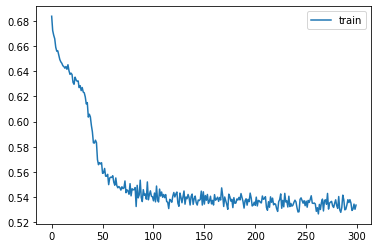

In [44]:
m = models[0]
c = n_classes[0]
s = n_steps[0]
i = n_indicators[0]

fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 2
Number of indicators 3
              precision    recall  f1-score   support

           S    0.75231   0.79804   0.77450       510
           B    0.77560   0.72653   0.75026       490

    accuracy                        0.76300      1000
   macro avg    0.76395   0.76228   0.76238      1000
weighted avg    0.76372   0.76300   0.76262      1000

Confusion matrix, without normalization
[[407 103]
 [134 356]]


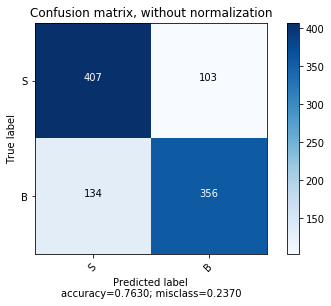

[1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 

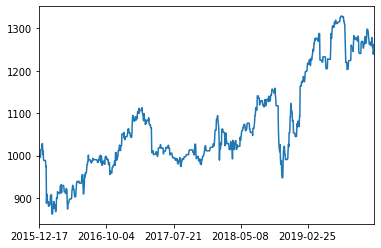

In [45]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3999/3999 [==============================] - 3s 794us/step - loss: 0.6648 - accuracy: 0.5949
Epoch 2/300
3999/3999 [==============================] - 1s 247us/step - loss: 0.6437 - accuracy: 0.63590s - los
Epoch 3/300
3999/3999 [==============================] - 1s 217us/step - loss: 0.6294 - accuracy: 0.6562
Epoch 4/300
3999/3999 [==============================] - 1s 235us/step - loss: 0.6036 - accuracy: 0.6847
Epoch 5/300
3999/3999 [==============================] - 2s 521us/step - loss: 0.5748 - accuracy: 0.71323s - los - ETA: 0s - loss: 0.5789 - 
Epoch 6/300
3999/3999 [==============================] - 1s 291us/step - loss: 0.5431 - accuracy: 0.7277
Epoch 7/300
3999/3999 [==============================] - 1s 206us/step - loss: 0.5151 - accuracy: 0.75920s - loss: 0.5166 - accuracy: 
Epoch 8/300
3999/3999 [==============================] - 1s 312us/step - loss: 0.4771 - accuracy: 0.7757
Epoch 9/300
3999/3999 [==============================] - 1s 283us/step - loss: 0.4376 

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.254264). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129072). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3999/3999 [==============================] - 2s 403us/step - loss: 0.3057 - accuracy: 0.8697
Epoch 16/300
3999/3999 [==============================] - 1s 339us/step - loss: 0.2919 - accuracy: 0.8800
Epoch 17/300
3999/3999 [==============================] - 2s 442us/step - loss: 0.2809 - accuracy: 0.8860
Epoch 18/300
3999/3999 [==============================] - 1s 337us/step - loss: 0.2587 - accuracy: 0.9020
Epoch 19/300
3999/3999 [==============================] - 2s 378us/step - loss: 0.2726 - accuracy: 0.8885
Epoch 20/300
3999/3999 [==============================] - 1s 345us/step - loss: 0.2551 - accuracy: 0.8955
Epoch 21/300
3999/3999 [==============================] - 1s 232us/step - loss: 0.2481 - accuracy: 0.8972
Epoch 22/300
3999/3999 [==============================] - 1s 366us/step - loss: 0.2419 - accuracy: 0.9025
Epoch 23/300
3999/3999 [==============================] - 1s 187us/step - loss: 0.2308 - accuracy: 0.9092
Epoch 24/300
3999/3999 [==============================] - 1

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246655). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.125617). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3999/3999 [==============================] - 1s 359us/step - loss: 0.1125 - accuracy: 0.9552
Epoch 71/300
3999/3999 [==============================] - 1s 346us/step - loss: 0.0943 - accuracy: 0.9655
Epoch 72/300
3999/3999 [==============================] - 1s 373us/step - loss: 0.1032 - accuracy: 0.9602
Epoch 73/300
3999/3999 [==============================] - 2s 520us/step - loss: 0.1038 - accuracy: 0.9585
Epoch 74/300
3999/3999 [==============================] - 1s 289us/step - loss: 0.1108 - accuracy: 0.9520
Epoch 75/300
3999/3999 [==============================] - 1s 326us/step - loss: 0.1081 - accuracy: 0.9547
Epoch 76/300
3999/3999 [==============================] - 2s 433us/step - loss: 0.1005 - accuracy: 0.9622
Epoch 77/300
1088/3999 [=======>......................] - ETA: 0s - loss: 0.0733 - accuracy: 0.9706

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.134425). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3999/3999 [==============================] - 2s 413us/step - loss: 0.0910 - accuracy: 0.9620
Epoch 78/300
3999/3999 [==============================] - 1s 324us/step - loss: 0.0953 - accuracy: 0.9612
Epoch 79/300
3999/3999 [==============================] - 1s 294us/step - loss: 0.0953 - accuracy: 0.9590
Epoch 80/300
3999/3999 [==============================] - 2s 383us/step - loss: 0.0888 - accuracy: 0.9647
Epoch 81/300
3999/3999 [==============================] - 1s 325us/step - loss: 0.0912 - accuracy: 0.9620
Epoch 82/300
3999/3999 [==============================] - 1s 280us/step - loss: 0.0900 - accuracy: 0.9612
Epoch 83/300
3999/3999 [==============================] - 1s 348us/step - loss: 0.0909 - accuracy: 0.9622
Epoch 84/300
3999/3999 [==============================] - 1s 283us/step - loss: 0.1104 - accuracy: 0.9540
Epoch 85/300
 896/3999 [=====>........................] - ETA: 0s - loss: 0.0908 - accuracy: 0.9632

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129963). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3999/3999 [==============================] - 2s 375us/step - loss: 0.0948 - accuracy: 0.9615
Epoch 86/300
3999/3999 [==============================] - 1s 319us/step - loss: 0.0874 - accuracy: 0.9620
Epoch 87/300
3999/3999 [==============================] - 1s 299us/step - loss: 0.0891 - accuracy: 0.9632
Epoch 88/300
3999/3999 [==============================] - 1s 295us/step - loss: 0.0924 - accuracy: 0.9630
Epoch 89/300
3999/3999 [==============================] - 1s 326us/step - loss: 0.0801 - accuracy: 0.9665
Epoch 90/300
3999/3999 [==============================] - 1s 287us/step - loss: 0.0928 - accuracy: 0.96450s - loss: 0.0840 
Epoch 91/300
3999/3999 [==============================] - 1s 313us/step - loss: 0.0937 - accuracy: 0.96228s - l
Epoch 92/300
3999/3999 [==============================] - 1s 331us/step - loss: 0.1012 - accuracy: 0.9597
Epoch 93/300
3999/3999 [==============================] - 1s 310us/step - loss: 0.0916 - accuracy: 0.9627
Epoch 94/300
3999/3999 [===========

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.133457). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3999/3999 [==============================] - 1s 289us/step - loss: 0.0845 - accuracy: 0.9650
Epoch 130/300
3999/3999 [==============================] - 1s 254us/step - loss: 0.0840 - accuracy: 0.9650
Epoch 131/300
3999/3999 [==============================] - 1s 297us/step - loss: 0.0743 - accuracy: 0.9685
Epoch 132/300
3999/3999 [==============================] - 1s 296us/step - loss: 0.0701 - accuracy: 0.97251s - loss: 0.068
Epoch 133/300
3999/3999 [==============================] - 1s 256us/step - loss: 0.0714 - accuracy: 0.9705
Epoch 134/300
3999/3999 [==============================] - 1s 295us/step - loss: 0.0707 - accuracy: 0.9727
Epoch 135/300
3999/3999 [==============================] - 1s 317us/step - loss: 0.0767 - accuracy: 0.9682
Epoch 136/300
3999/3999 [==============================] - 1s 293us/step - loss: 0.0768 - accuracy: 0.9655
Epoch 137/300
3999/3999 [==============================] - 1s 273us/step - loss: 0.0866 - accuracy: 0.9645
Epoch 138/300
3999/3999 [==========

3999/3999 [==============================] - 1s 147us/step - loss: 0.0695 - accuracy: 0.9665
Epoch 205/300
3999/3999 [==============================] - 0s 107us/step - loss: 0.0669 - accuracy: 0.9737
Epoch 206/300
3999/3999 [==============================] - 1s 164us/step - loss: 0.0902 - accuracy: 0.9627
Epoch 207/300
3999/3999 [==============================] - 0s 112us/step - loss: 0.0733 - accuracy: 0.9712
Epoch 208/300
3999/3999 [==============================] - 1s 137us/step - loss: 0.0810 - accuracy: 0.9647
Epoch 209/300
3999/3999 [==============================] - 0s 106us/step - loss: 0.0707 - accuracy: 0.9732
Epoch 210/300
3999/3999 [==============================] - 0s 119us/step - loss: 0.0716 - accuracy: 0.9687
Epoch 211/300
3999/3999 [==============================] - 0s 119us/step - loss: 0.0781 - accuracy: 0.9685
Epoch 212/300
3999/3999 [==============================] - 1s 144us/step - loss: 0.0765 - accuracy: 0.9682
Epoch 213/300
3999/3999 [==========================

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114646). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.148327). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3999/3999 [==============================] - 1s 200us/step - loss: 0.0961 - accuracy: 0.9617
Epoch 236/300
3999/3999 [==============================] - 0s 117us/step - loss: 0.0872 - accuracy: 0.9645
Epoch 237/300
3999/3999 [==============================] - 1s 129us/step - loss: 0.0915 - accuracy: 0.9622
Epoch 238/300
3999/3999 [==============================] - 0s 114us/step - loss: 0.0925 - accuracy: 0.9585
Epoch 239/300
3999/3999 [==============================] - 0s 105us/step - loss: 0.0848 - accuracy: 0.9615
Epoch 240/300
3999/3999 [==============================] - 0s 115us/step - loss: 0.0758 - accuracy: 0.9705
Epoch 241/300
3999/3999 [==============================] - 0s 120us/step - loss: 0.0782 - accuracy: 0.9655
Epoch 242/300
3999/3999 [==============================] - 1s 137us/step - loss: 0.0833 - accuracy: 0.9640
Epoch 243/300
3999/3999 [==============================] - 0s 113us/step - loss: 0.0732 - accuracy: 0.9702
Epoch 244/300
3999/3999 [==========================

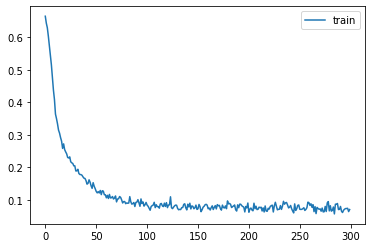

In [46]:
fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 2
Number of indicators 6
              precision    recall  f1-score   support

           S    0.99801   0.98431   0.99112       510
           B    0.98390   0.99796   0.99088       490

    accuracy                        0.99100      1000
   macro avg    0.99096   0.99114   0.99100      1000
weighted avg    0.99110   0.99100   0.99100      1000

Confusion matrix, without normalization
[[502   8]
 [  1 489]]


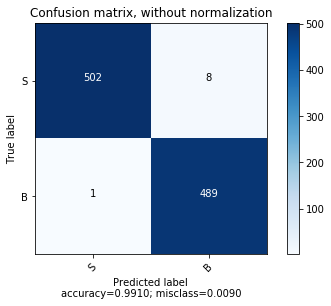

[1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 

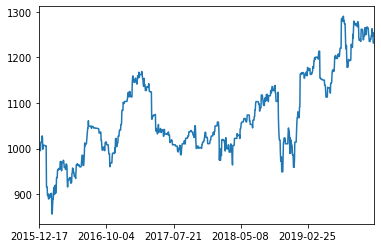

In [47]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3999/3999 [==============================] - 1s 355us/step - loss: 0.6264 - accuracy: 0.6559
Epoch 2/300
3999/3999 [==============================] - 0s 116us/step - loss: 0.5800 - accuracy: 0.7087
Epoch 3/300
3999/3999 [==============================] - 0s 108us/step - loss: 0.5581 - accuracy: 0.7254
Epoch 4/300
3999/3999 [==============================] - 0s 120us/step - loss: 0.5354 - accuracy: 0.7402
Epoch 5/300
3999/3999 [==============================] - 0s 119us/step - loss: 0.5194 - accuracy: 0.7562
Epoch 6/300
3999/3999 [==============================] - 0s 111us/step - loss: 0.4829 - accuracy: 0.7774
Epoch 7/300
3999/3999 [==============================] - 0s 117us/step - loss: 0.4670 - accuracy: 0.7917
Epoch 8/300
3999/3999 [==============================] - 0s 115us/step - loss: 0.4550 - accuracy: 0.7887
Epoch 9/300
3999/3999 [==============================] - 0s 121us/step - loss: 0.4383 - accuracy: 0.8080
Epoch 10/300
3999/3999 [==============================]

3999/3999 [==============================] - 0s 121us/step - loss: 0.1099 - accuracy: 0.9567
Epoch 79/300
3999/3999 [==============================] - 0s 112us/step - loss: 0.1115 - accuracy: 0.9570
Epoch 80/300
3999/3999 [==============================] - 0s 112us/step - loss: 0.1127 - accuracy: 0.9537
Epoch 81/300
3999/3999 [==============================] - 0s 108us/step - loss: 0.1185 - accuracy: 0.9542
Epoch 82/300
3999/3999 [==============================] - 0s 114us/step - loss: 0.1280 - accuracy: 0.9462
Epoch 83/300
3999/3999 [==============================] - 0s 108us/step - loss: 0.1027 - accuracy: 0.9557
Epoch 84/300
3999/3999 [==============================] - 0s 112us/step - loss: 0.1122 - accuracy: 0.9560
Epoch 85/300
3999/3999 [==============================] - 0s 110us/step - loss: 0.1118 - accuracy: 0.9550
Epoch 86/300
3999/3999 [==============================] - 0s 110us/step - loss: 0.1211 - accuracy: 0.9505
Epoch 87/300
3999/3999 [==============================] - 1

3999/3999 [==============================] - 0s 107us/step - loss: 0.0891 - accuracy: 0.9630
Epoch 155/300
3999/3999 [==============================] - 0s 114us/step - loss: 0.0868 - accuracy: 0.9660
Epoch 156/300
3999/3999 [==============================] - 0s 104us/step - loss: 0.1024 - accuracy: 0.9592
Epoch 157/300
3999/3999 [==============================] - 0s 102us/step - loss: 0.0803 - accuracy: 0.9702
Epoch 158/300
3999/3999 [==============================] - 0s 112us/step - loss: 0.0808 - accuracy: 0.9652
Epoch 159/300
3999/3999 [==============================] - 0s 99us/step - loss: 0.0819 - accuracy: 0.9675
Epoch 160/300
3999/3999 [==============================] - 0s 103us/step - loss: 0.1012 - accuracy: 0.96020s - loss: 0.0970 - accu
Epoch 161/300
3999/3999 [==============================] - 0s 100us/step - loss: 0.0946 - accuracy: 0.9597
Epoch 162/300
3999/3999 [==============================] - 1s 127us/step - loss: 0.0935 - accuracy: 0.9617
Epoch 163/300
3999/3999 [===

3999/3999 [==============================] - 0s 115us/step - loss: 0.0843 - accuracy: 0.9642
Epoch 230/300
3999/3999 [==============================] - 0s 107us/step - loss: 0.0895 - accuracy: 0.9620
Epoch 231/300
3999/3999 [==============================] - 0s 125us/step - loss: 0.0752 - accuracy: 0.9687
Epoch 232/300
3999/3999 [==============================] - 0s 109us/step - loss: 0.0761 - accuracy: 0.9685
Epoch 233/300
3999/3999 [==============================] - 0s 113us/step - loss: 0.1297 - accuracy: 0.9475
Epoch 234/300
3999/3999 [==============================] - 0s 115us/step - loss: 0.0940 - accuracy: 0.96470s - loss: 0.0848 - accuracy: 0.
Epoch 235/300
3999/3999 [==============================] - 0s 110us/step - loss: 0.0845 - accuracy: 0.9662
Epoch 236/300
3999/3999 [==============================] - 1s 127us/step - loss: 0.0964 - accuracy: 0.9610
Epoch 237/300
3999/3999 [==============================] - 0s 114us/step - loss: 0.0804 - accuracy: 0.9675
Epoch 238/300
3999/

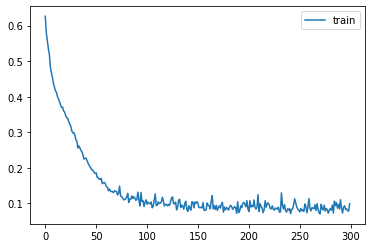

In [48]:
fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 2
Number of indicators 8
              precision    recall  f1-score   support

           S    1.00000   0.94118   0.96970       510
           B    0.94231   1.00000   0.97030       490

    accuracy                        0.97000      1000
   macro avg    0.97115   0.97059   0.97000      1000
weighted avg    0.97173   0.97000   0.96999      1000

Confusion matrix, without normalization
[[480  30]
 [  0 490]]


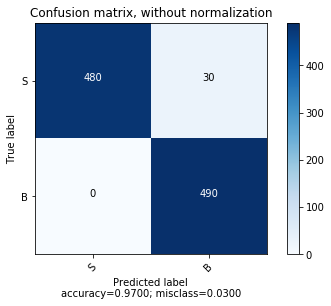

[1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 

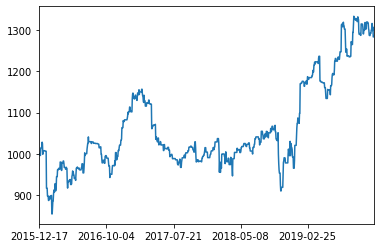

In [49]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3999/3999 [==============================] - 1s 351us/step - loss: 2.2448 - accuracy: 0.5164
Epoch 2/300
3999/3999 [==============================] - 0s 105us/step - loss: 0.7586 - accuracy: 0.5276
Epoch 3/300
3999/3999 [==============================] - 0s 112us/step - loss: 0.7178 - accuracy: 0.5476
Epoch 4/300
3999/3999 [==============================] - 0s 111us/step - loss: 0.7236 - accuracy: 0.5656
Epoch 5/300
3999/3999 [==============================] - 1s 127us/step - loss: 0.6825 - accuracy: 0.5739
Epoch 6/300
3999/3999 [==============================] - 0s 116us/step - loss: 0.6777 - accuracy: 0.5884
Epoch 7/300
3999/3999 [==============================] - 0s 116us/step - loss: 0.6686 - accuracy: 0.5904
Epoch 8/300
3999/3999 [==============================] - 0s 114us/step - loss: 0.6761 - accuracy: 0.5966
Epoch 9/300
3999/3999 [==============================] - 0s 115us/step - loss: 0.6626 - accuracy: 0.5839
Epoch 10/300
3999/3999 [==============================]

3999/3999 [==============================] - 0s 110us/step - loss: 0.4514 - accuracy: 0.7854
Epoch 79/300
3999/3999 [==============================] - 0s 118us/step - loss: 0.4740 - accuracy: 0.7807
Epoch 80/300
3999/3999 [==============================] - 0s 123us/step - loss: 0.4541 - accuracy: 0.7804
Epoch 81/300
3999/3999 [==============================] - 0s 107us/step - loss: 0.4469 - accuracy: 0.7867
Epoch 82/300
3999/3999 [==============================] - 0s 114us/step - loss: 0.4391 - accuracy: 0.7927
Epoch 83/300
3999/3999 [==============================] - 1s 127us/step - loss: 0.4499 - accuracy: 0.7882
Epoch 84/300
3999/3999 [==============================] - 0s 111us/step - loss: 0.4513 - accuracy: 0.7852
Epoch 85/300
3999/3999 [==============================] - 1s 126us/step - loss: 0.4615 - accuracy: 0.7789
Epoch 86/300
3999/3999 [==============================] - 0s 106us/step - loss: 0.4568 - accuracy: 0.7854
Epoch 87/300
3999/3999 [==============================] - 1

3999/3999 [==============================] - 0s 99us/step - loss: 0.4093 - accuracy: 0.8145
Epoch 155/300
3999/3999 [==============================] - 0s 96us/step - loss: 0.3905 - accuracy: 0.8212
Epoch 156/300
3999/3999 [==============================] - 0s 101us/step - loss: 0.4008 - accuracy: 0.8192
Epoch 157/300
3999/3999 [==============================] - 0s 102us/step - loss: 0.4022 - accuracy: 0.8185
Epoch 158/300
3999/3999 [==============================] - 0s 92us/step - loss: 0.3979 - accuracy: 0.8180
Epoch 159/300
3999/3999 [==============================] - 0s 106us/step - loss: 0.3821 - accuracy: 0.8235
Epoch 160/300
3999/3999 [==============================] - 0s 98us/step - loss: 0.4140 - accuracy: 0.8090
Epoch 161/300
3999/3999 [==============================] - 0s 96us/step - loss: 0.4020 - accuracy: 0.8122
Epoch 162/300
3999/3999 [==============================] - 0s 102us/step - loss: 0.3970 - accuracy: 0.8220
Epoch 163/300
3999/3999 [==============================]

3999/3999 [==============================] - 0s 125us/step - loss: 0.3681 - accuracy: 0.8347
Epoch 229/300
3999/3999 [==============================] - 1s 137us/step - loss: 0.3649 - accuracy: 0.8335
Epoch 230/300
3999/3999 [==============================] - 0s 123us/step - loss: 0.3525 - accuracy: 0.8435
Epoch 231/300
3999/3999 [==============================] - 1s 129us/step - loss: 0.3563 - accuracy: 0.8405
Epoch 232/300
3999/3999 [==============================] - 1s 136us/step - loss: 0.3333 - accuracy: 0.8517
Epoch 233/300
3999/3999 [==============================] - 1s 187us/step - loss: 0.3716 - accuracy: 0.8325
Epoch 234/300
3999/3999 [==============================] - 1s 150us/step - loss: 0.3447 - accuracy: 0.8500
Epoch 235/300
3999/3999 [==============================] - 1s 159us/step - loss: 0.3580 - accuracy: 0.8395
Epoch 236/300
3999/3999 [==============================] - 1s 159us/step - loss: 0.3712 - accuracy: 0.8287
Epoch 237/300
3999/3999 [==========================

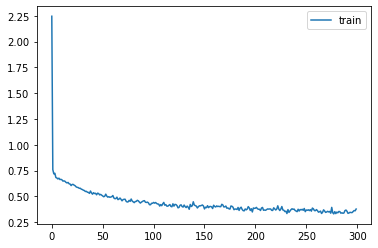

In [50]:
fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 2
Number of indicators 11
              precision    recall  f1-score   support

           S    0.89154   0.80588   0.84655       510
           B    0.81633   0.89796   0.85520       490

    accuracy                        0.85100      1000
   macro avg    0.85393   0.85192   0.85087      1000
weighted avg    0.85469   0.85100   0.85079      1000

Confusion matrix, without normalization
[[411  99]
 [ 50 440]]


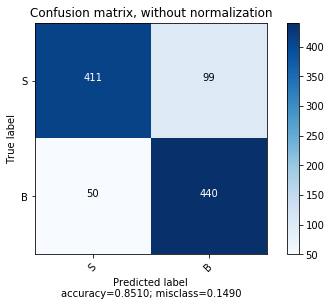

First date:	   2015-12-18	| Initial stock value: US$ 117.97256989408302
Last date:	   2019-12-06	| Final stock value: US$ 132.75
Stock value growth:	12.53%
[DEBUG] Initial money:    US$ 1000.0 | Final money: US$ 70755.55
[DEBUG] Final profit:	   US$ 69755.55 over 3.97 years
Money growth:      	6975.56%
Growth per year:   	192.51%
[1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0

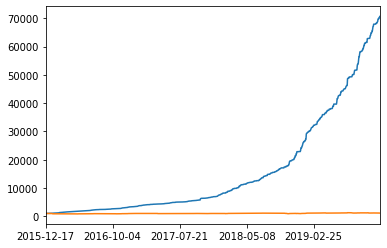

In [51]:
predict(m, c, s, i)
calculateOptimalProfit(preds[m][c][s][i])
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 2s 422us/step - loss: 0.6329 - accuracy: 0.6476
Epoch 2/300
3996/3996 [==============================] - 0s 122us/step - loss: 0.5711 - accuracy: 0.7102
Epoch 3/300
3996/3996 [==============================] - 1s 134us/step - loss: 0.5396 - accuracy: 0.7417
Epoch 4/300
3996/3996 [==============================] - 1s 185us/step - loss: 0.5281 - accuracy: 0.7482
Epoch 5/300
3996/3996 [==============================] - 1s 163us/step - loss: 0.5191 - accuracy: 0.7608
Epoch 6/300
3996/3996 [==============================] - 1s 170us/step - loss: 0.5021 - accuracy: 0.7645
Epoch 7/300
3996/3996 [==============================] - 1s 156us/step - loss: 0.4986 - accuracy: 0.7698
Epoch 8/300
3996/3996 [==============================] - 1s 157us/step - loss: 0.4944 - accuracy: 0.7740
Epoch 9/300
3996/3996 [==============================] - 1s 152us/step - loss: 0.4963 - accuracy: 0.7735
Epoch 10/300
3996/3996 [==============================]

3996/3996 [==============================] - 0s 123us/step - loss: 0.4515 - accuracy: 0.8013
Epoch 77/300
3996/3996 [==============================] - 0s 121us/step - loss: 0.4466 - accuracy: 0.8033
Epoch 78/300
3996/3996 [==============================] - 0s 116us/step - loss: 0.4500 - accuracy: 0.7993
Epoch 79/300
3996/3996 [==============================] - 0s 123us/step - loss: 0.4519 - accuracy: 0.7973
Epoch 80/300
3996/3996 [==============================] - 0s 121us/step - loss: 0.4513 - accuracy: 0.7960
Epoch 81/300
3996/3996 [==============================] - 1s 140us/step - loss: 0.4479 - accuracy: 0.7968
Epoch 82/300
3996/3996 [==============================] - 0s 114us/step - loss: 0.4418 - accuracy: 0.8008
Epoch 83/300
3996/3996 [==============================] - 0s 119us/step - loss: 0.4464 - accuracy: 0.7973
Epoch 84/300
3996/3996 [==============================] - 0s 108us/step - loss: 0.4447 - accuracy: 0.8016
Epoch 85/300
3996/3996 [==============================] - 1

3996/3996 [==============================] - 0s 107us/step - loss: 0.4303 - accuracy: 0.8111
Epoch 153/300
3996/3996 [==============================] - 0s 101us/step - loss: 0.4293 - accuracy: 0.8086
Epoch 154/300
3996/3996 [==============================] - 0s 95us/step - loss: 0.4365 - accuracy: 0.8026
Epoch 155/300
3996/3996 [==============================] - 0s 95us/step - loss: 0.4324 - accuracy: 0.8081
Epoch 156/300
3996/3996 [==============================] - 0s 99us/step - loss: 0.4356 - accuracy: 0.8053
Epoch 157/300
3996/3996 [==============================] - 0s 110us/step - loss: 0.4392 - accuracy: 0.7995
Epoch 158/300
3996/3996 [==============================] - 0s 100us/step - loss: 0.4362 - accuracy: 0.7980
Epoch 159/300
3996/3996 [==============================] - 0s 95us/step - loss: 0.4317 - accuracy: 0.8091
Epoch 160/300
3996/3996 [==============================] - 0s 95us/step - loss: 0.4346 - accuracy: 0.8058
Epoch 161/300
3996/3996 [==============================]

3996/3996 [==============================] - 0s 110us/step - loss: 0.4247 - accuracy: 0.8148
Epoch 229/300
3996/3996 [==============================] - 0s 116us/step - loss: 0.4246 - accuracy: 0.8081
Epoch 230/300
3996/3996 [==============================] - 0s 113us/step - loss: 0.4320 - accuracy: 0.8043
Epoch 231/300
3996/3996 [==============================] - 0s 112us/step - loss: 0.4246 - accuracy: 0.8106
Epoch 232/300
3996/3996 [==============================] - 0s 122us/step - loss: 0.4281 - accuracy: 0.8046
Epoch 233/300
3996/3996 [==============================] - 0s 121us/step - loss: 0.4274 - accuracy: 0.8121
Epoch 234/300
3996/3996 [==============================] - 0s 118us/step - loss: 0.4311 - accuracy: 0.8068
Epoch 235/300
3996/3996 [==============================] - 1s 126us/step - loss: 0.4276 - accuracy: 0.8061
Epoch 236/300
3996/3996 [==============================] - 0s 109us/step - loss: 0.4377 - accuracy: 0.8061
Epoch 237/300
3996/3996 [==========================

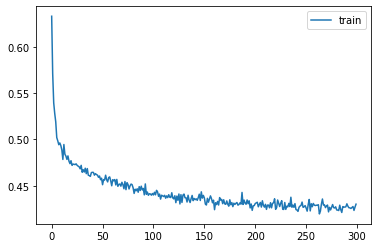

In [52]:
fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 5
Number of indicators 3
              precision    recall  f1-score   support

           S    0.73864   0.89216   0.80817       510
           B    0.85677   0.67143   0.75286       490

    accuracy                        0.78400      1000
   macro avg    0.79770   0.78179   0.78052      1000
weighted avg    0.79652   0.78400   0.78107      1000

Confusion matrix, without normalization
[[455  55]
 [161 329]]


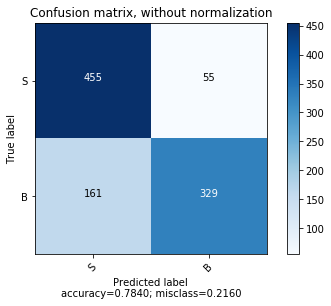

[0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 

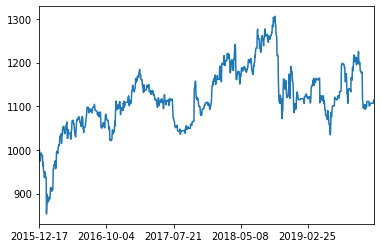

In [53]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 2s 390us/step - loss: 0.6016 - accuracy: 0.6737
Epoch 2/300
3996/3996 [==============================] - 0s 111us/step - loss: 0.5213 - accuracy: 0.7558
Epoch 3/300
3996/3996 [==============================] - 0s 102us/step - loss: 0.4834 - accuracy: 0.7770
Epoch 4/300
3996/3996 [==============================] - 0s 116us/step - loss: 0.4639 - accuracy: 0.7895
Epoch 5/300
3996/3996 [==============================] - 0s 108us/step - loss: 0.4494 - accuracy: 0.8016
Epoch 6/300
3996/3996 [==============================] - 0s 116us/step - loss: 0.4305 - accuracy: 0.8078
Epoch 7/300
3996/3996 [==============================] - 0s 100us/step - loss: 0.4178 - accuracy: 0.8206
Epoch 8/300
3996/3996 [==============================] - 0s 114us/step - loss: 0.4143 - accuracy: 0.8181
Epoch 9/300
3996/3996 [==============================] - 0s 114us/step - loss: 0.4165 - accuracy: 0.8178
Epoch 10/300
3996/3996 [==============================]

3996/3996 [==============================] - 1s 125us/step - loss: 0.1263 - accuracy: 0.9479
Epoch 78/300
3996/3996 [==============================] - 0s 114us/step - loss: 0.1373 - accuracy: 0.9397
Epoch 79/300
3996/3996 [==============================] - 0s 109us/step - loss: 0.1382 - accuracy: 0.9439
Epoch 80/300
3996/3996 [==============================] - 0s 114us/step - loss: 0.1487 - accuracy: 0.9394
Epoch 81/300
3996/3996 [==============================] - 0s 109us/step - loss: 0.1301 - accuracy: 0.9452
Epoch 82/300
3996/3996 [==============================] - 1s 129us/step - loss: 0.1217 - accuracy: 0.9472
Epoch 83/300
3996/3996 [==============================] - 0s 102us/step - loss: 0.1463 - accuracy: 0.9374
Epoch 84/300
3996/3996 [==============================] - 0s 113us/step - loss: 0.1433 - accuracy: 0.9394
Epoch 85/300
3996/3996 [==============================] - 0s 109us/step - loss: 0.1425 - accuracy: 0.9459
Epoch 86/300
3996/3996 [==============================] - 0

3996/3996 [==============================] - 1s 186us/step - loss: 0.1205 - accuracy: 0.9535
Epoch 153/300
3996/3996 [==============================] - 1s 281us/step - loss: 0.1080 - accuracy: 0.95800s - loss: 0.1331 - 
Epoch 154/300
3996/3996 [==============================] - 1s 201us/step - loss: 0.1314 - accuracy: 0.9424
Epoch 155/300
3996/3996 [==============================] - 1s 201us/step - loss: 0.1185 - accuracy: 0.9532
Epoch 156/300
3996/3996 [==============================] - 1s 248us/step - loss: 0.1119 - accuracy: 0.9535
Epoch 157/300
3996/3996 [==============================] - 1s 352us/step - loss: 0.1097 - accuracy: 0.95351s - loss: 0 - ETA: 0s - loss: 0.1005 - accura
Epoch 158/300
3996/3996 [==============================] - 1s 252us/step - loss: 0.1200 - accuracy: 0.9505
Epoch 159/300
3996/3996 [==============================] - 1s 305us/step - loss: 0.1252 - accuracy: 0.9510
Epoch 160/300
3996/3996 [==============================] - 1s 266us/step - loss: 0.1432 - ac

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105039). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3996/3996 [==============================] - 2s 390us/step - loss: 0.1190 - accuracy: 0.9497
Epoch 162/300
3996/3996 [==============================] - 1s 264us/step - loss: 0.1214 - accuracy: 0.9454
Epoch 163/300
3996/3996 [==============================] - 1s 265us/step - loss: 0.1352 - accuracy: 0.9477
Epoch 164/300
3996/3996 [==============================] - 1s 283us/step - loss: 0.1292 - accuracy: 0.9437
Epoch 165/300
3996/3996 [==============================] - 1s 249us/step - loss: 0.1124 - accuracy: 0.9550
Epoch 166/300
3996/3996 [==============================] - 1s 302us/step - loss: 0.1145 - accuracy: 0.95550s - loss: 0
Epoch 167/300
3996/3996 [==============================] - 1s 351us/step - loss: 0.1259 - accuracy: 0.9474
Epoch 168/300
3996/3996 [==============================] - 1s 271us/step - loss: 0.1165 - accuracy: 0.9525
Epoch 169/300
3996/3996 [==============================] - 1s 286us/step - loss: 0.1268 - accuracy: 0.9492
Epoch 170/300
3996/3996 [==============

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129271). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3996/3996 [==============================] - 1s 294us/step - loss: 0.1410 - accuracy: 0.9407
Epoch 230/300
3996/3996 [==============================] - 1s 287us/step - loss: 0.1225 - accuracy: 0.9489
Epoch 231/300
3996/3996 [==============================] - 1s 306us/step - loss: 0.1274 - accuracy: 0.94640s - loss: 0.1334 - accu
Epoch 232/300
3996/3996 [==============================] - 1s 263us/step - loss: 0.1258 - accuracy: 0.9462
Epoch 233/300
3996/3996 [==============================] - 1s 337us/step - loss: 0.1116 - accuracy: 0.9555
Epoch 234/300
3996/3996 [==============================] - 1s 319us/step - loss: 0.1137 - accuracy: 0.9545
Epoch 235/300
3996/3996 [==============================] - 1s 292us/step - loss: 0.1232 - accuracy: 0.9525
Epoch 236/300
3996/3996 [==============================] - 1s 345us/step - loss: 0.1125 - accuracy: 0.9520
Epoch 237/300
3996/3996 [==============================] - 1s 284us/step - loss: 0.1031 - accuracy: 0.9557
Epoch 238/300
3996/3996 [==

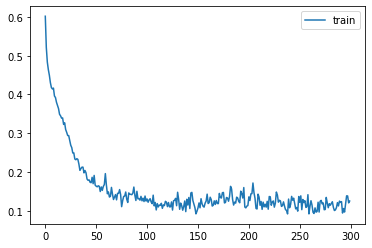

In [54]:
fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 5
Number of indicators 6
              precision    recall  f1-score   support

           S    0.98998   0.96863   0.97919       510
           B    0.96806   0.98980   0.97881       490

    accuracy                        0.97900      1000
   macro avg    0.97902   0.97921   0.97900      1000
weighted avg    0.97924   0.97900   0.97900      1000

Confusion matrix, without normalization
[[494  16]
 [  5 485]]


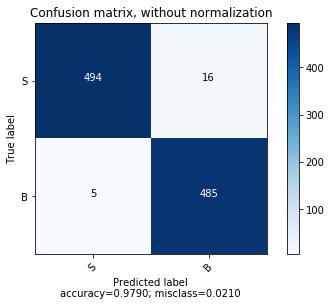

[1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 

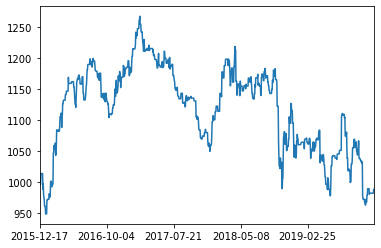

In [55]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 3s 643us/step - loss: 0.5676 - accuracy: 0.7127
Epoch 2/300
3996/3996 [==============================] - 1s 217us/step - loss: 0.5124 - accuracy: 0.7620
Epoch 3/300
3996/3996 [==============================] - 1s 158us/step - loss: 0.4954 - accuracy: 0.7743
Epoch 4/300
3996/3996 [==============================] - 1s 165us/step - loss: 0.4852 - accuracy: 0.7723
Epoch 5/300
3996/3996 [==============================] - 2s 401us/step - loss: 0.4696 - accuracy: 0.7855
Epoch 6/300
3996/3996 [==============================] - 1s 183us/step - loss: 0.4579 - accuracy: 0.7948
Epoch 7/300
3996/3996 [==============================] - 1s 196us/step - loss: 0.4481 - accuracy: 0.8003
Epoch 8/300
3996/3996 [==============================] - 1s 225us/step - loss: 0.4377 - accuracy: 0.8028
Epoch 9/300
3996/3996 [==============================] - 1s 182us/step - loss: 0.4224 - accuracy: 0.8101
Epoch 10/300
3996/3996 [==============================]

3996/3996 [==============================] - 1s 143us/step - loss: 0.2088 - accuracy: 0.9082
Epoch 75/300
3996/3996 [==============================] - 1s 159us/step - loss: 0.1938 - accuracy: 0.9199
Epoch 76/300
3996/3996 [==============================] - 1s 137us/step - loss: 0.1932 - accuracy: 0.9212
Epoch 77/300
3996/3996 [==============================] - 0s 120us/step - loss: 0.2001 - accuracy: 0.9127
Epoch 78/300
3996/3996 [==============================] - 0s 120us/step - loss: 0.2098 - accuracy: 0.9109
Epoch 79/300
3996/3996 [==============================] - 0s 117us/step - loss: 0.2157 - accuracy: 0.9089
Epoch 80/300
3996/3996 [==============================] - 0s 116us/step - loss: 0.1874 - accuracy: 0.9204
Epoch 81/300
3996/3996 [==============================] - 1s 271us/step - loss: 0.1922 - accuracy: 0.9222
Epoch 82/300
3996/3996 [==============================] - 1s 241us/step - loss: 0.1950 - accuracy: 0.92070s - loss: 0.1952 - ac
Epoch 83/300
3996/3996 [=============

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101458). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3996/3996 [==============================] - 1s 176us/step - loss: 0.1648 - accuracy: 0.9284
Epoch 127/300
3996/3996 [==============================] - 1s 160us/step - loss: 0.1585 - accuracy: 0.9319
Epoch 128/300
3996/3996 [==============================] - 1s 363us/step - loss: 0.1476 - accuracy: 0.9379
Epoch 129/300
3996/3996 [==============================] - 1s 310us/step - loss: 0.1421 - accuracy: 0.94121s - loss: 0.1556 - accuracy - ETA: 0s - loss: 0.1554 - accu
Epoch 130/300
3996/3996 [==============================] - 1s 200us/step - loss: 0.1580 - accuracy: 0.9324
Epoch 131/300
3996/3996 [==============================] - 1s 193us/step - loss: 0.1633 - accuracy: 0.9329
Epoch 132/300
3996/3996 [==============================] - 1s 223us/step - loss: 0.1650 - accuracy: 0.9317
Epoch 133/300
3996/3996 [==============================] - 1s 180us/step - loss: 0.1565 - accuracy: 0.9329
Epoch 134/300
3996/3996 [==============================] - 1s 141us/step - loss: 0.1382 - accuracy

Epoch 201/300
3996/3996 [==============================] - 1s 254us/step - loss: 0.1177 - accuracy: 0.9515
Epoch 202/300
3996/3996 [==============================] - 1s 273us/step - loss: 0.1379 - accuracy: 0.9434
Epoch 203/300
3996/3996 [==============================] - 1s 228us/step - loss: 0.1302 - accuracy: 0.9505
Epoch 204/300
3996/3996 [==============================] - 1s 253us/step - loss: 0.1311 - accuracy: 0.9462
Epoch 205/300
3996/3996 [==============================] - 1s 258us/step - loss: 0.1322 - accuracy: 0.9424
Epoch 206/300
3996/3996 [==============================] - 1s 310us/step - loss: 0.1269 - accuracy: 0.9492
Epoch 207/300
3996/3996 [==============================] - 1s 253us/step - loss: 0.1494 - accuracy: 0.9367
Epoch 208/300
3996/3996 [==============================] - 1s 254us/step - loss: 0.1153 - accuracy: 0.9505
Epoch 209/300
3996/3996 [==============================] - 1s 194us/step - loss: 0.1240 - accuracy: 0.9474
Epoch 210/300
3996/3996 [============

3996/3996 [==============================] - 1s 313us/step - loss: 0.1119 - accuracy: 0.9540
Epoch 276/300
3996/3996 [==============================] - 1s 281us/step - loss: 0.1342 - accuracy: 0.9429
Epoch 277/300
3996/3996 [==============================] - 1s 240us/step - loss: 0.1286 - accuracy: 0.94770s - loss:
Epoch 278/300
3996/3996 [==============================] - 1s 256us/step - loss: 0.1138 - accuracy: 0.9547
Epoch 279/300
3996/3996 [==============================] - 1s 312us/step - loss: 0.1201 - accuracy: 0.9525
Epoch 280/300
3996/3996 [==============================] - 1s 247us/step - loss: 0.1544 - accuracy: 0.93120s - loss: 0.1680 - ac
Epoch 281/300
3996/3996 [==============================] - 1s 185us/step - loss: 0.1113 - accuracy: 0.9525
Epoch 282/300
3996/3996 [==============================] - 1s 204us/step - loss: 0.1028 - accuracy: 0.9605
Epoch 283/300
3996/3996 [==============================] - 1s 189us/step - loss: 0.1171 - accuracy: 0.9505
Epoch 284/300
3996/

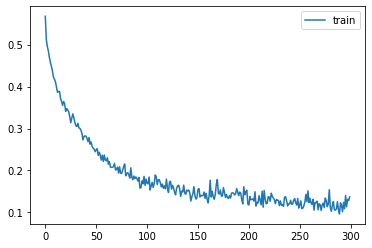

In [56]:
fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 5
Number of indicators 8
              precision    recall  f1-score   support

           S    0.92125   0.98627   0.95265       510
           B    0.98458   0.91224   0.94703       490

    accuracy                        0.95000      1000
   macro avg    0.95291   0.94926   0.94984      1000
weighted avg    0.95228   0.95000   0.94990      1000

Confusion matrix, without normalization
[[503   7]
 [ 43 447]]


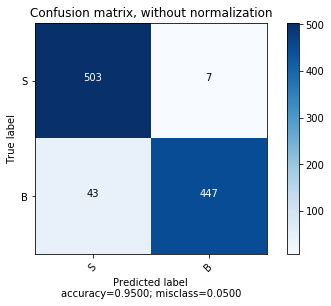

[1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 

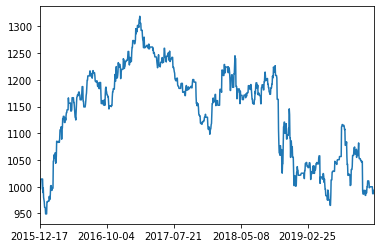

In [57]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 2s 625us/step - loss: 1.8455 - accuracy: 0.5200
Epoch 2/300
3996/3996 [==============================] - 1s 191us/step - loss: 0.7459 - accuracy: 0.5188
Epoch 3/300
3996/3996 [==============================] - 1s 215us/step - loss: 0.7077 - accuracy: 0.5378
Epoch 4/300
3996/3996 [==============================] - 1s 193us/step - loss: 0.7011 - accuracy: 0.5438
Epoch 5/300
3996/3996 [==============================] - 1s 189us/step - loss: 0.7009 - accuracy: 0.5538
Epoch 6/300
3996/3996 [==============================] - 1s 187us/step - loss: 0.6800 - accuracy: 0.5753
Epoch 7/300
3996/3996 [==============================] - 1s 197us/step - loss: 0.6720 - accuracy: 0.5868
Epoch 8/300
3996/3996 [==============================] - 0s 121us/step - loss: 0.6715 - accuracy: 0.5863
Epoch 9/300
3996/3996 [==============================] - 1s 136us/step - loss: 0.6587 - accuracy: 0.6094
Epoch 10/300
3996/3996 [==============================]

3996/3996 [==============================] - 1s 265us/step - loss: 0.4469 - accuracy: 0.79550s - loss: 0.4359 - accu
Epoch 78/300
3996/3996 [==============================] - 1s 193us/step - loss: 0.4361 - accuracy: 0.8016
Epoch 79/300
3996/3996 [==============================] - 1s 182us/step - loss: 0.4392 - accuracy: 0.7943
Epoch 80/300
3996/3996 [==============================] - 1s 224us/step - loss: 0.4376 - accuracy: 0.79380s - loss: 0.4371 - accuracy
Epoch 81/300
3996/3996 [==============================] - 1s 267us/step - loss: 0.4400 - accuracy: 0.7930
Epoch 82/300
3996/3996 [==============================] - 1s 191us/step - loss: 0.4553 - accuracy: 0.7850
Epoch 83/300
3996/3996 [==============================] - 1s 201us/step - loss: 0.4314 - accuracy: 0.8053
Epoch 84/300
3996/3996 [==============================] - 1s 197us/step - loss: 0.4343 - accuracy: 0.7940
Epoch 85/300
3996/3996 [==============================] - 1s 189us/step - loss: 0.4307 - accuracy: 0.7998
Epoch 8

3996/3996 [==============================] - 1s 148us/step - loss: 0.4174 - accuracy: 0.8108
Epoch 152/300
3996/3996 [==============================] - 1s 178us/step - loss: 0.3903 - accuracy: 0.8203
Epoch 153/300
3996/3996 [==============================] - 1s 153us/step - loss: 0.4005 - accuracy: 0.8086
Epoch 154/300
3996/3996 [==============================] - 1s 166us/step - loss: 0.3887 - accuracy: 0.8211
Epoch 155/300
3996/3996 [==============================] - 1s 186us/step - loss: 0.3988 - accuracy: 0.8146
Epoch 156/300
3996/3996 [==============================] - 1s 178us/step - loss: 0.4091 - accuracy: 0.8096
Epoch 157/300
3996/3996 [==============================] - 1s 180us/step - loss: 0.3893 - accuracy: 0.82030s - loss: 0.3771 - accu
Epoch 158/300
3996/3996 [==============================] - 1s 158us/step - loss: 0.3784 - accuracy: 0.8293
Epoch 159/300
3996/3996 [==============================] - 1s 178us/step - loss: 0.3807 - accuracy: 0.8216
Epoch 160/300
3996/3996 [==

3996/3996 [==============================] - 1s 181us/step - loss: 0.3645 - accuracy: 0.8286
Epoch 225/300
3996/3996 [==============================] - 1s 178us/step - loss: 0.3573 - accuracy: 0.83160s - loss: 0.3522 - accu
Epoch 226/300
3996/3996 [==============================] - 1s 167us/step - loss: 0.3439 - accuracy: 0.8428
Epoch 227/300
3996/3996 [==============================] - 1s 188us/step - loss: 0.3549 - accuracy: 0.8403
Epoch 228/300
3996/3996 [==============================] - 1s 192us/step - loss: 0.3557 - accuracy: 0.8368
Epoch 229/300
3996/3996 [==============================] - 1s 183us/step - loss: 0.3665 - accuracy: 0.8261
Epoch 230/300
3996/3996 [==============================] - 1s 190us/step - loss: 0.3632 - accuracy: 0.8403
Epoch 231/300
3996/3996 [==============================] - 1s 195us/step - loss: 0.3505 - accuracy: 0.8486
Epoch 232/300
3996/3996 [==============================] - 1s 172us/step - loss: 0.3480 - accuracy: 0.84430s - loss: 0.3418 - 
Epoch 2

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.128848). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3996/3996 [==============================] - 1s 279us/step - loss: 0.3164 - accuracy: 0.8579
Epoch 297/300
3996/3996 [==============================] - 1s 320us/step - loss: 0.3413 - accuracy: 0.8473
Epoch 298/300
3996/3996 [==============================] - 1s 238us/step - loss: 0.3606 - accuracy: 0.8431
Epoch 299/300
3996/3996 [==============================] - 1s 275us/step - loss: 0.3304 - accuracy: 0.85840s - loss: 0.3237 
Epoch 300/300
3996/3996 [==============================] - 1s 324us/step - loss: 0.3425 - accuracy: 0.85191s -


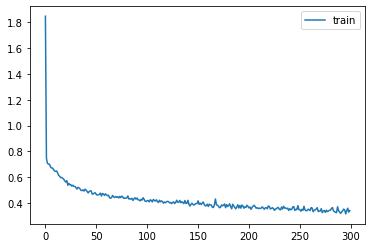

In [58]:
fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 5
Number of indicators 11
              precision    recall  f1-score   support

           S    0.82946   0.83922   0.83431       510
           B    0.83058   0.82041   0.82546       490

    accuracy                        0.83000      1000
   macro avg    0.83002   0.82981   0.82989      1000
weighted avg    0.83001   0.83000   0.82997      1000

Confusion matrix, without normalization
[[428  82]
 [ 88 402]]


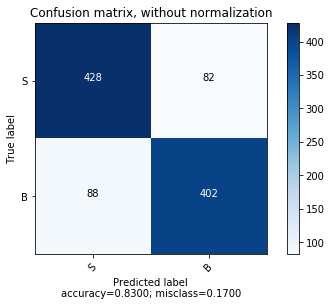

[1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 

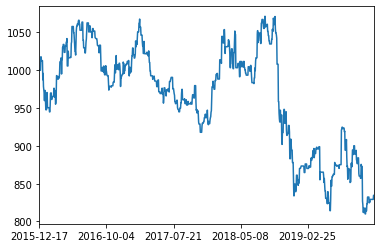

In [59]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3992/3992 [==============================] - 3s 746us/step - loss: 0.6318 - accuracy: 0.6298
Epoch 2/300
3992/3992 [==============================] - 1s 173us/step - loss: 0.5716 - accuracy: 0.72170s - loss: 0.5750 - accuracy
Epoch 3/300
3992/3992 [==============================] - 0s 112us/step - loss: 0.5480 - accuracy: 0.7260
Epoch 4/300
3992/3992 [==============================] - 1s 128us/step - loss: 0.5302 - accuracy: 0.7455
Epoch 5/300
3992/3992 [==============================] - 0s 125us/step - loss: 0.5205 - accuracy: 0.7530
Epoch 6/300
3992/3992 [==============================] - 1s 147us/step - loss: 0.5169 - accuracy: 0.75280s - loss: 0.5213 - accuracy
Epoch 7/300
3992/3992 [==============================] - 1s 149us/step - loss: 0.5148 - accuracy: 0.7558
Epoch 8/300
3992/3992 [==============================] - 1s 138us/step - loss: 0.5036 - accuracy: 0.7693
Epoch 9/300
3992/3992 [==============================] - 1s 139us/step - loss: 0.5130 - accuracy: 0.7580

3992/3992 [==============================] - 1s 128us/step - loss: 0.4435 - accuracy: 0.80360s - loss: 0.4622 - accuracy
Epoch 76/300
3992/3992 [==============================] - 0s 118us/step - loss: 0.4445 - accuracy: 0.8029
Epoch 77/300
3992/3992 [==============================] - 1s 151us/step - loss: 0.4430 - accuracy: 0.7998
Epoch 78/300
3992/3992 [==============================] - 1s 153us/step - loss: 0.4532 - accuracy: 0.7978
Epoch 79/300
3992/3992 [==============================] - 1s 137us/step - loss: 0.4472 - accuracy: 0.7981
Epoch 80/300
3992/3992 [==============================] - 0s 117us/step - loss: 0.4456 - accuracy: 0.7971
Epoch 81/300
3992/3992 [==============================] - 1s 129us/step - loss: 0.4507 - accuracy: 0.8021
Epoch 82/300
3992/3992 [==============================] - 1s 127us/step - loss: 0.4485 - accuracy: 0.7948
Epoch 83/300
3992/3992 [==============================] - 1s 129us/step - loss: 0.4473 - accuracy: 0.7976
Epoch 84/300
3992/3992 [=======

3992/3992 [==============================] - 0s 105us/step - loss: 0.4368 - accuracy: 0.8069
Epoch 152/300
3992/3992 [==============================] - 0s 108us/step - loss: 0.4331 - accuracy: 0.8076
Epoch 153/300
3992/3992 [==============================] - 0s 99us/step - loss: 0.4280 - accuracy: 0.8111
Epoch 154/300
3992/3992 [==============================] - 0s 103us/step - loss: 0.4278 - accuracy: 0.8101
Epoch 155/300
3992/3992 [==============================] - 1s 130us/step - loss: 0.4224 - accuracy: 0.8129
Epoch 156/300
3992/3992 [==============================] - 0s 115us/step - loss: 0.4212 - accuracy: 0.8131
Epoch 157/300
3992/3992 [==============================] - 0s 123us/step - loss: 0.4302 - accuracy: 0.8054
Epoch 158/300
3992/3992 [==============================] - 0s 100us/step - loss: 0.4291 - accuracy: 0.8066
Epoch 159/300
3992/3992 [==============================] - 0s 98us/step - loss: 0.4316 - accuracy: 0.8124
Epoch 160/300
3992/3992 [============================

Epoch 227/300
3992/3992 [==============================] - 1s 132us/step - loss: 0.4292 - accuracy: 0.8061
Epoch 228/300
3992/3992 [==============================] - 1s 127us/step - loss: 0.4188 - accuracy: 0.8111
Epoch 229/300
3992/3992 [==============================] - 0s 121us/step - loss: 0.4299 - accuracy: 0.8004
Epoch 230/300
3992/3992 [==============================] - 1s 151us/step - loss: 0.4176 - accuracy: 0.8116
Epoch 231/300
3992/3992 [==============================] - 1s 233us/step - loss: 0.4138 - accuracy: 0.80860s - loss: 0.4
Epoch 232/300
3992/3992 [==============================] - 1s 170us/step - loss: 0.4295 - accuracy: 0.8026
Epoch 233/300
3992/3992 [==============================] - 1s 158us/step - loss: 0.4208 - accuracy: 0.8119
Epoch 234/300
3992/3992 [==============================] - 1s 140us/step - loss: 0.4144 - accuracy: 0.8151
Epoch 235/300
3992/3992 [==============================] - 1s 156us/step - loss: 0.4193 - accuracy: 0.8119
Epoch 236/300
3992/3992

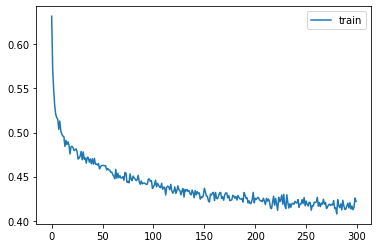

In [60]:
fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 10
Number of indicators 3
              precision    recall  f1-score   support

           S    0.85146   0.77083   0.80915       528
           B    0.76775   0.84926   0.80645       471

    accuracy                        0.80781       999
   macro avg    0.80961   0.81005   0.80780       999
weighted avg    0.81200   0.80781   0.80788       999

Confusion matrix, without normalization
[[407 121]
 [ 71 400]]


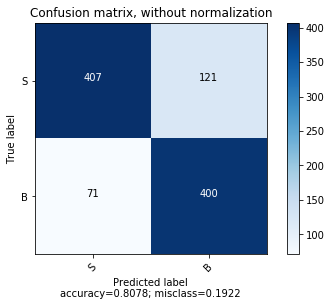

[1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 

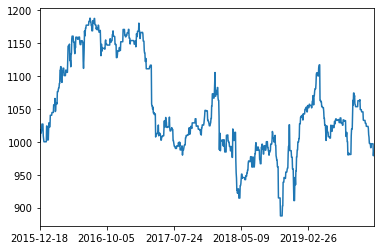

In [61]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3992/3992 [==============================] - 2s 423us/step - loss: 0.6367 - accuracy: 0.6355
Epoch 2/300
3992/3992 [==============================] - 1s 130us/step - loss: 0.5489 - accuracy: 0.7260
Epoch 3/300
3992/3992 [==============================] - 1s 138us/step - loss: 0.5031 - accuracy: 0.7595
Epoch 4/300
3992/3992 [==============================] - 1s 129us/step - loss: 0.4733 - accuracy: 0.7786
Epoch 5/300
3992/3992 [==============================] - 1s 142us/step - loss: 0.4625 - accuracy: 0.7886
Epoch 6/300
3992/3992 [==============================] - 1s 132us/step - loss: 0.4539 - accuracy: 0.7926
Epoch 7/300
3992/3992 [==============================] - 1s 140us/step - loss: 0.4402 - accuracy: 0.7986
Epoch 8/300
3992/3992 [==============================] - 1s 126us/step - loss: 0.4436 - accuracy: 0.7958
Epoch 9/300
3992/3992 [==============================] - 1s 145us/step - loss: 0.4221 - accuracy: 0.8124
Epoch 10/300
3992/3992 [==============================]

3992/3992 [==============================] - 1s 160us/step - loss: 0.2068 - accuracy: 0.9131
Epoch 78/300
3992/3992 [==============================] - 1s 143us/step - loss: 0.2150 - accuracy: 0.9066
Epoch 79/300
3992/3992 [==============================] - 1s 144us/step - loss: 0.1968 - accuracy: 0.9143
Epoch 80/300
3992/3992 [==============================] - 1s 140us/step - loss: 0.2034 - accuracy: 0.9101
Epoch 81/300
3992/3992 [==============================] - 1s 140us/step - loss: 0.2034 - accuracy: 0.9153
Epoch 82/300
3992/3992 [==============================] - 1s 141us/step - loss: 0.2258 - accuracy: 0.9036
Epoch 83/300
3992/3992 [==============================] - 1s 133us/step - loss: 0.2176 - accuracy: 0.9093
Epoch 84/300
3992/3992 [==============================] - 1s 151us/step - loss: 0.2180 - accuracy: 0.9068
Epoch 85/300
3992/3992 [==============================] - 1s 128us/step - loss: 0.2398 - accuracy: 0.8968
Epoch 86/300
3992/3992 [==============================] - 1

3992/3992 [==============================] - 1s 159us/step - loss: 0.1955 - accuracy: 0.9213
Epoch 153/300
3992/3992 [==============================] - 1s 196us/step - loss: 0.1893 - accuracy: 0.9203
Epoch 154/300
3992/3992 [==============================] - 1s 149us/step - loss: 0.1749 - accuracy: 0.9281
Epoch 155/300
3992/3992 [==============================] - 1s 155us/step - loss: 0.1547 - accuracy: 0.9371
Epoch 156/300
3992/3992 [==============================] - 1s 125us/step - loss: 0.1754 - accuracy: 0.9314
Epoch 157/300
3992/3992 [==============================] - 0s 108us/step - loss: 0.1773 - accuracy: 0.9238
Epoch 158/300
3992/3992 [==============================] - 0s 110us/step - loss: 0.1993 - accuracy: 0.9161
Epoch 159/300
3992/3992 [==============================] - 1s 203us/step - loss: 0.1764 - accuracy: 0.9206
Epoch 160/300
3992/3992 [==============================] - 1s 156us/step - loss: 0.2445 - accuracy: 0.8905
Epoch 161/300
3992/3992 [==========================

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135813). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3992/3992 [==============================] - 1s 306us/step - loss: 0.2380 - accuracy: 0.8943
Epoch 200/300
3992/3992 [==============================] - 1s 252us/step - loss: 0.1531 - accuracy: 0.9384
Epoch 201/300
3992/3992 [==============================] - 1s 265us/step - loss: 0.1506 - accuracy: 0.9431
Epoch 202/300
3992/3992 [==============================] - 1s 305us/step - loss: 0.1563 - accuracy: 0.9399
Epoch 203/300
3992/3992 [==============================] - 1s 295us/step - loss: 0.2311 - accuracy: 0.9043
Epoch 204/300
3992/3992 [==============================] - 1s 297us/step - loss: 0.2037 - accuracy: 0.91531s - l
Epoch 205/300
3992/3992 [==============================] - 1s 235us/step - loss: 0.1998 - accuracy: 0.9118
Epoch 206/300
3992/3992 [==============================] - 1s 300us/step - loss: 0.1497 - accuracy: 0.9391
Epoch 207/300
3992/3992 [==============================] - 1s 283us/step - loss: 0.1724 - accuracy: 0.9289
Epoch 208/300
3992/3992 [====================

3992/3992 [==============================] - 1s 185us/step - loss: 0.1837 - accuracy: 0.9248
Epoch 274/300
3992/3992 [==============================] - 1s 171us/step - loss: 0.1492 - accuracy: 0.9409
Epoch 275/300
3992/3992 [==============================] - 1s 169us/step - loss: 0.1597 - accuracy: 0.9326
Epoch 276/300
3992/3992 [==============================] - 1s 206us/step - loss: 0.1972 - accuracy: 0.9106
Epoch 277/300
3992/3992 [==============================] - 1s 166us/step - loss: 0.1877 - accuracy: 0.9063
Epoch 278/300
3992/3992 [==============================] - 1s 172us/step - loss: 0.2010 - accuracy: 0.8955
Epoch 279/300
3992/3992 [==============================] - 1s 182us/step - loss: 0.2244 - accuracy: 0.8923
Epoch 280/300
3992/3992 [==============================] - 1s 191us/step - loss: 0.2397 - accuracy: 0.8930
Epoch 281/300
3992/3992 [==============================] - 1s 170us/step - loss: 0.2098 - accuracy: 0.8963
Epoch 282/300
3992/3992 [==========================

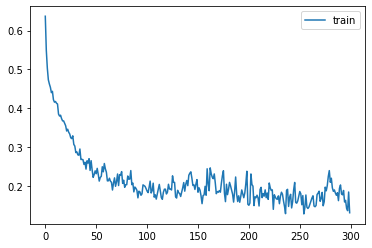

In [62]:
fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 10
Number of indicators 6
              precision    recall  f1-score   support

           S    0.88870   0.99811   0.94023       528
           B    0.99754   0.85987   0.92360       471

    accuracy                        0.93293       999
   macro avg    0.94312   0.92899   0.93192       999
weighted avg    0.94001   0.93293   0.93239       999

Confusion matrix, without normalization
[[527   1]
 [ 66 405]]


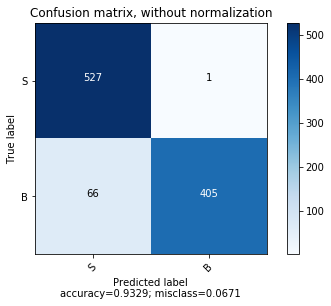

[1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 

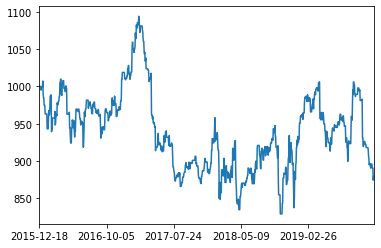

In [63]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3992/3992 [==============================] - 6s 1ms/step - loss: 0.5972 - accuracy: 0.7014
Epoch 2/300
3992/3992 [==============================] - 1s 270us/step - loss: 0.5375 - accuracy: 0.7410
Epoch 3/300
3992/3992 [==============================] - 1s 279us/step - loss: 0.5157 - accuracy: 0.7558
Epoch 4/300
3992/3992 [==============================] - 1s 259us/step - loss: 0.5108 - accuracy: 0.7638
Epoch 5/300
3992/3992 [==============================] - 1s 224us/step - loss: 0.4927 - accuracy: 0.77430s - loss: 0.4949 - accura
Epoch 6/300
3992/3992 [==============================] - 1s 255us/step - loss: 0.4863 - accuracy: 0.77730s - loss: 0.4
Epoch 7/300
3992/3992 [==============================] - 1s 219us/step - loss: 0.4729 - accuracy: 0.7823
Epoch 8/300
3992/3992 [==============================] - 1s 193us/step - loss: 0.4706 - accuracy: 0.7783
Epoch 9/300
3992/3992 [==============================] - 1s 202us/step - loss: 0.4586 - accuracy: 0.7876
Epoch 10/300
3992

3992/3992 [==============================] - 1s 173us/step - loss: 0.2696 - accuracy: 0.8810
Epoch 77/300
3992/3992 [==============================] - 1s 165us/step - loss: 0.2633 - accuracy: 0.8865
Epoch 78/300
3992/3992 [==============================] - 1s 163us/step - loss: 0.2686 - accuracy: 0.8825
Epoch 79/300
3992/3992 [==============================] - 1s 159us/step - loss: 0.2705 - accuracy: 0.8855
Epoch 80/300
3992/3992 [==============================] - 1s 232us/step - loss: 0.2528 - accuracy: 0.8918
Epoch 81/300
3992/3992 [==============================] - 1s 156us/step - loss: 0.2650 - accuracy: 0.88480s - loss: 0.256
Epoch 82/300
3992/3992 [==============================] - 1s 157us/step - loss: 0.2633 - accuracy: 0.8823
Epoch 83/300
3992/3992 [==============================] - 1s 184us/step - loss: 0.2623 - accuracy: 0.88700s - loss: 0
Epoch 84/300
3992/3992 [==============================] - 1s 153us/step - loss: 0.2653 - accuracy: 0.8825
Epoch 85/300
3992/3992 [=======

Epoch 150/300
3992/3992 [==============================] - 0s 118us/step - loss: 0.1984 - accuracy: 0.9161
Epoch 151/300
3992/3992 [==============================] - 0s 123us/step - loss: 0.1868 - accuracy: 0.9256
Epoch 152/300
3992/3992 [==============================] - 0s 121us/step - loss: 0.1991 - accuracy: 0.9166
Epoch 153/300
3992/3992 [==============================] - 1s 139us/step - loss: 0.1923 - accuracy: 0.9198
Epoch 154/300
3992/3992 [==============================] - 1s 126us/step - loss: 0.2053 - accuracy: 0.9108
Epoch 155/300
3992/3992 [==============================] - 1s 206us/step - loss: 0.2050 - accuracy: 0.91110s - loss: 0.2035 - accura
Epoch 156/300
3992/3992 [==============================] - 1s 171us/step - loss: 0.1906 - accuracy: 0.9198
Epoch 157/300
3992/3992 [==============================] - 1s 179us/step - loss: 0.1866 - accuracy: 0.9201
Epoch 158/300
3992/3992 [==============================] - 1s 178us/step - loss: 0.1905 - accuracy: 0.9163
Epoch 159/3

3992/3992 [==============================] - 1s 267us/step - loss: 0.1736 - accuracy: 0.9221
Epoch 226/300
3992/3992 [==============================] - 1s 159us/step - loss: 0.1734 - accuracy: 0.9246
Epoch 227/300
3992/3992 [==============================] - 1s 147us/step - loss: 0.1496 - accuracy: 0.9394
Epoch 228/300
3992/3992 [==============================] - 1s 158us/step - loss: 0.1586 - accuracy: 0.9336
Epoch 229/300
3992/3992 [==============================] - 1s 128us/step - loss: 0.1744 - accuracy: 0.9291
Epoch 230/300
3992/3992 [==============================] - 0s 119us/step - loss: 0.1535 - accuracy: 0.9341
Epoch 231/300
3992/3992 [==============================] - 0s 124us/step - loss: 0.1719 - accuracy: 0.9286
Epoch 232/300
3992/3992 [==============================] - 0s 121us/step - loss: 0.1492 - accuracy: 0.9401
Epoch 233/300
3992/3992 [==============================] - 1s 128us/step - loss: 0.1598 - accuracy: 0.9334
Epoch 234/300
3992/3992 [==========================

3992/3992 [==============================] - 1s 339us/step - loss: 0.1464 - accuracy: 0.93760s - loss: 0.1456 - accuracy: 0.93
Epoch 300/300
3992/3992 [==============================] - 1s 248us/step - loss: 0.1452 - accuracy: 0.9351


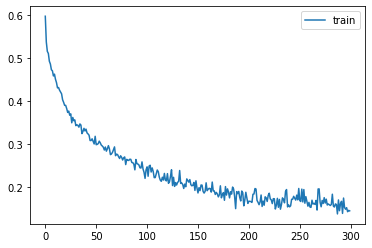

In [64]:
fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 10
Number of indicators 8
              precision    recall  f1-score   support

           S    0.93204   0.90909   0.92042       528
           B    0.90083   0.92569   0.91309       471

    accuracy                        0.91692       999
   macro avg    0.91643   0.91739   0.91676       999
weighted avg    0.91732   0.91692   0.91696       999

Confusion matrix, without normalization
[[480  48]
 [ 35 436]]


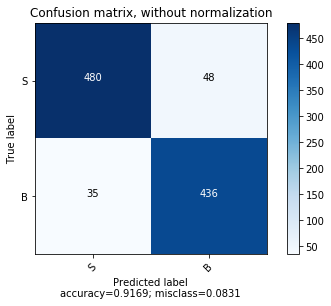

[1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 

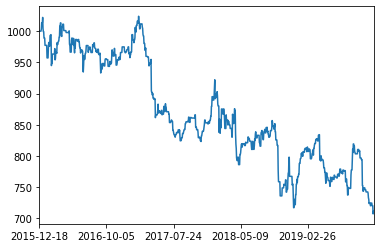

In [65]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3992/3992 [==============================] - 2s 589us/step - loss: 2.5149 - accuracy: 0.5178
Epoch 2/300
3992/3992 [==============================] - 1s 188us/step - loss: 0.7158 - accuracy: 0.5163
Epoch 3/300
3992/3992 [==============================] - 1s 219us/step - loss: 0.7005 - accuracy: 0.5378
Epoch 4/300
3992/3992 [==============================] - 1s 260us/step - loss: 0.6977 - accuracy: 0.5338
Epoch 5/300
3992/3992 [==============================] - 1s 222us/step - loss: 0.6909 - accuracy: 0.5371
Epoch 6/300
3992/3992 [==============================] - 1s 241us/step - loss: 0.6872 - accuracy: 0.5451
Epoch 7/300
3992/3992 [==============================] - 1s 240us/step - loss: 0.6747 - accuracy: 0.57210s - loss: 0.6780 - accu
Epoch 8/300
3992/3992 [==============================] - 1s 238us/step - loss: 0.6692 - accuracy: 0.5887
Epoch 9/300
3992/3992 [==============================] - 1s 188us/step - loss: 0.6606 - accuracy: 0.5834
Epoch 10/300
3992/3992 [=======

3992/3992 [==============================] - 1s 188us/step - loss: 0.4603 - accuracy: 0.7763
Epoch 78/300
3992/3992 [==============================] - 1s 219us/step - loss: 0.4675 - accuracy: 0.7653
Epoch 79/300
3992/3992 [==============================] - 1s 209us/step - loss: 0.4687 - accuracy: 0.7803
Epoch 80/300
3992/3992 [==============================] - 1s 206us/step - loss: 0.4586 - accuracy: 0.7821
Epoch 81/300
3992/3992 [==============================] - 1s 199us/step - loss: 0.4614 - accuracy: 0.7833
Epoch 82/300
3992/3992 [==============================] - 1s 282us/step - loss: 0.4568 - accuracy: 0.77560s
Epoch 83/300
3992/3992 [==============================] - 1s 239us/step - loss: 0.4507 - accuracy: 0.78260s - loss: 0.4
Epoch 84/300
3992/3992 [==============================] - 1s 267us/step - loss: 0.4534 - accuracy: 0.7843
Epoch 85/300
3992/3992 [==============================] - 1s 291us/step - loss: 0.4641 - accuracy: 0.7776
Epoch 86/300
3992/3992 [===================

3992/3992 [==============================] - 1s 197us/step - loss: 0.3773 - accuracy: 0.8219
Epoch 153/300
3992/3992 [==============================] - 1s 169us/step - loss: 0.3664 - accuracy: 0.8282
Epoch 154/300
3992/3992 [==============================] - 1s 214us/step - loss: 0.3700 - accuracy: 0.8297
Epoch 155/300
3992/3992 [==============================] - 1s 264us/step - loss: 0.3579 - accuracy: 0.8347
Epoch 156/300
3992/3992 [==============================] - 2s 432us/step - loss: 0.3667 - accuracy: 0.8259
Epoch 157/300
3992/3992 [==============================] - 2s 458us/step - loss: 0.3797 - accuracy: 0.8262
Epoch 158/300
3992/3992 [==============================] - 2s 457us/step - loss: 0.3667 - accuracy: 0.82841s - loss: 0.3669 - ac - ETA: 0s - loss: 0
Epoch 159/300
3992/3992 [==============================] - 2s 401us/step - loss: 0.3724 - accuracy: 0.82290s - loss: 0.3688 - 
Epoch 160/300
3992/3992 [==============================] - 1s 259us/step - loss: 0.3750 - accura

3992/3992 [==============================] - 1s 304us/step - loss: 0.3110 - accuracy: 0.8642
Epoch 225/300
3992/3992 [==============================] - 1s 259us/step - loss: 0.3174 - accuracy: 0.8580
Epoch 226/300
3992/3992 [==============================] - 1s 312us/step - loss: 0.3104 - accuracy: 0.8612
Epoch 227/300
3992/3992 [==============================] - 1s 308us/step - loss: 0.3232 - accuracy: 0.8565
Epoch 228/300
3992/3992 [==============================] - 1s 314us/step - loss: 0.3324 - accuracy: 0.8449
Epoch 229/300
3992/3992 [==============================] - 1s 277us/step - loss: 0.3206 - accuracy: 0.8512
Epoch 230/300
3992/3992 [==============================] - 1s 281us/step - loss: 0.3120 - accuracy: 0.8590
Epoch 231/300
3992/3992 [==============================] - 1s 245us/step - loss: 0.3081 - accuracy: 0.8562
Epoch 232/300
3992/3992 [==============================] - 1s 290us/step - loss: 0.3117 - accuracy: 0.8577
Epoch 233/300
3992/3992 [==========================

3992/3992 [==============================] - 1s 185us/step - loss: 0.3021 - accuracy: 0.8695
Epoch 300/300
3992/3992 [==============================] - 1s 163us/step - loss: 0.2732 - accuracy: 0.8783


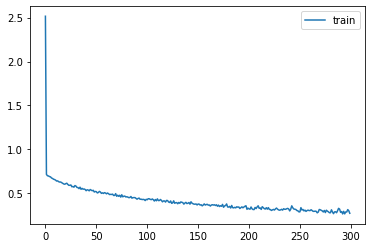

In [66]:
fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 10
Number of indicators 11
              precision    recall  f1-score   support

           S    0.80451   0.81061   0.80755       528
           B    0.78587   0.77919   0.78252       471

    accuracy                        0.79580       999
   macro avg    0.79519   0.79490   0.79503       999
weighted avg    0.79572   0.79580   0.79575       999

Confusion matrix, without normalization
[[428 100]
 [104 367]]


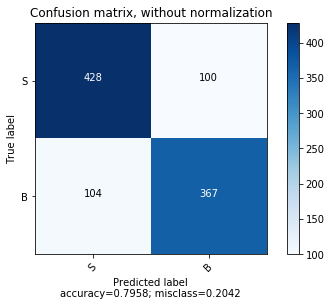

[1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 

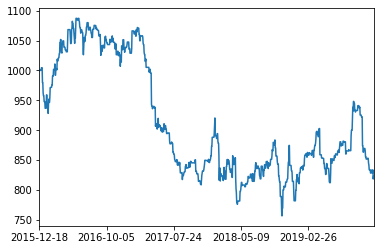

In [67]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3999/3999 [==============================] - 2s 391us/step - loss: 2.0383 - accuracy: 0.1833
Epoch 2/300
3999/3999 [==============================] - 1s 134us/step - loss: 1.9907 - accuracy: 0.1933
Epoch 3/300
3999/3999 [==============================] - 1s 127us/step - loss: 1.9780 - accuracy: 0.1905
Epoch 4/300
3999/3999 [==============================] - 1s 131us/step - loss: 1.9771 - accuracy: 0.1943
Epoch 5/300
3999/3999 [==============================] - 1s 176us/step - loss: 1.9729 - accuracy: 0.1970
Epoch 6/300
3999/3999 [==============================] - 1s 128us/step - loss: 1.9631 - accuracy: 0.1935
Epoch 7/300
3999/3999 [==============================] - 1s 141us/step - loss: 1.9569 - accuracy: 0.1995
Epoch 8/300
3999/3999 [==============================] - 1s 153us/step - loss: 1.9604 - accuracy: 0.1908
Epoch 9/300
3999/3999 [==============================] - 0s 107us/step - loss: 1.9535 - accuracy: 0.2016
Epoch 10/300
3999/3999 [==============================]

3999/3999 [==============================] - 1s 155us/step - loss: 1.7597 - accuracy: 0.2968
Epoch 76/300
3999/3999 [==============================] - 0s 112us/step - loss: 1.7649 - accuracy: 0.2828
Epoch 77/300
3999/3999 [==============================] - 1s 168us/step - loss: 1.7629 - accuracy: 0.2883
Epoch 78/300
3999/3999 [==============================] - 1s 149us/step - loss: 1.7586 - accuracy: 0.2906
Epoch 79/300
3999/3999 [==============================] - 1s 203us/step - loss: 1.7562 - accuracy: 0.2936
Epoch 80/300
3999/3999 [==============================] - 0s 122us/step - loss: 1.7685 - accuracy: 0.2798
Epoch 81/300
3999/3999 [==============================] - 0s 120us/step - loss: 1.7617 - accuracy: 0.2808
Epoch 82/300
3999/3999 [==============================] - 0s 116us/step - loss: 1.7586 - accuracy: 0.2966
Epoch 83/300
3999/3999 [==============================] - 1s 127us/step - loss: 1.7675 - accuracy: 0.2883
Epoch 84/300
3999/3999 [==============================] - 1

3999/3999 [==============================] - 2s 413us/step - loss: 1.7368 - accuracy: 0.3088
Epoch 150/300
3999/3999 [==============================] - 1s 232us/step - loss: 1.7418 - accuracy: 0.2988
Epoch 151/300
3999/3999 [==============================] - 2s 394us/step - loss: 1.7421 - accuracy: 0.2953
Epoch 152/300
3999/3999 [==============================] - 1s 261us/step - loss: 1.7481 - accuracy: 0.30730s - loss: 1.7517 - accura
Epoch 153/300
3999/3999 [==============================] - 1s 269us/step - loss: 1.7422 - accuracy: 0.2993
Epoch 154/300
3999/3999 [==============================] - 1s 181us/step - loss: 1.7388 - accuracy: 0.3063
Epoch 155/300
3999/3999 [==============================] - 1s 331us/step - loss: 1.7440 - accuracy: 0.3011
Epoch 156/300
3999/3999 [==============================] - 1s 306us/step - loss: 1.7492 - accuracy: 0.3058
Epoch 157/300
 928/3999 [=====>........................] - ETA: 1s - loss: 1.7129 - accuracy: 0.3125

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138194). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.106434). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


3999/3999 [==============================] - 1s 210us/step - loss: 1.7358 - accuracy: 0.3136
Epoch 158/300
3999/3999 [==============================] - 0s 107us/step - loss: 1.7490 - accuracy: 0.3028
Epoch 159/300
3999/3999 [==============================] - 0s 96us/step - loss: 1.7340 - accuracy: 0.2981
Epoch 160/300
3999/3999 [==============================] - 0s 103us/step - loss: 1.7424 - accuracy: 0.3023
Epoch 161/300
3999/3999 [==============================] - 0s 101us/step - loss: 1.7392 - accuracy: 0.3018
Epoch 162/300
3999/3999 [==============================] - 1s 153us/step - loss: 1.7540 - accuracy: 0.2908
Epoch 163/300
3999/3999 [==============================] - 1s 134us/step - loss: 1.7451 - accuracy: 0.2958
Epoch 164/300
3999/3999 [==============================] - 0s 97us/step - loss: 1.7278 - accuracy: 0.3028 0s - loss: 1.7266 - accuracy: 0.
Epoch 165/300
3999/3999 [==============================] - 0s 104us/step - loss: 1.7419 - accuracy: 0.3066
Epoch 166/300
3999/3

3999/3999 [==============================] - 0s 106us/step - loss: 1.7296 - accuracy: 0.3056
Epoch 233/300
3999/3999 [==============================] - 0s 113us/step - loss: 1.7284 - accuracy: 0.2938
Epoch 234/300
3999/3999 [==============================] - 0s 96us/step - loss: 1.7308 - accuracy: 0.3053
Epoch 235/300
3999/3999 [==============================] - 0s 106us/step - loss: 1.7325 - accuracy: 0.3021
Epoch 236/300
3999/3999 [==============================] - 0s 99us/step - loss: 1.7191 - accuracy: 0.3061
Epoch 237/300
3999/3999 [==============================] - 0s 122us/step - loss: 1.7289 - accuracy: 0.3133
Epoch 238/300
3999/3999 [==============================] - 0s 102us/step - loss: 1.7254 - accuracy: 0.3068
Epoch 239/300
3999/3999 [==============================] - 0s 100us/step - loss: 1.7367 - accuracy: 0.3073
Epoch 240/300
3999/3999 [==============================] - 0s 79us/step - loss: 1.7325 - accuracy: 0.3051
Epoch 241/300
3999/3999 [=============================

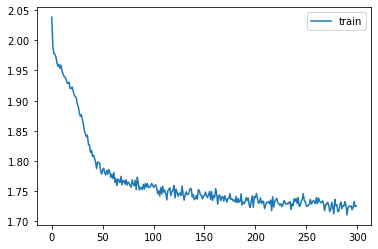

In [68]:
fit(m, c, s, i)

Model mlp
Number of classes 8
Number of steps 2
Number of indicators 3
              precision    recall  f1-score   support

          B3    0.77778   0.10294   0.18182        68
          B2    0.00000   0.00000   0.00000       111
          B1    0.00000   0.00000   0.00000       119
          B0    0.00000   0.00000   0.00000       192
          S0    0.00000   0.00000   0.00000       179
          S1    0.00000   0.00000   0.00000       140
          S2    0.00000   0.00000   0.00000       125
          S3    0.87500   0.10606   0.18919        66

   micro avg    0.82353   0.01400   0.02753      1000
   macro avg    0.20660   0.02613   0.04638      1000
weighted avg    0.11064   0.01400   0.02485      1000
 samples avg    0.01400   0.01400   0.01400      1000

Confusion matrix, without normalization
[[ 68   0   0   0   0   0   0   0]
 [110   0   0   0   0   0   0   1]
 [119   0   0   0   0   0   0   0]
 [192   0   0   0   0   0   0   0]
 [179   0   0   0   0   0   0   0]
 [140   0

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


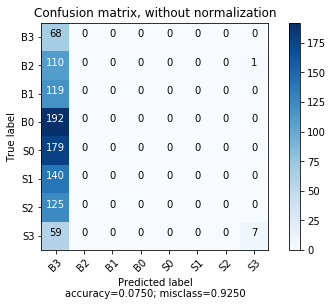

[3, 4, 3, 6, 6, 1, 6, 4, 3, 4, 6, 4, 4, 3, 0, 1, 1, 3, 4, 4, 7, 4, 3, 4, 4, 3, 6, 3, 4, 6, 4, 6, 4, 4, 6, 1, 6, 1, 3, 6, 3, 6, 3, 6, 4, 4, 6, 6, 3, 4, 6, 3, 4, 4, 4, 4, 3, 1, 6, 1, 3, 4, 6, 4, 3, 6, 6, 3, 3, 3, 3, 3, 4, 6, 3, 4, 1, 4, 4, 4, 7, 1, 6, 4, 4, 3, 3, 6, 6, 6, 1, 4, 1, 0, 3, 4, 4, 6, 4, 6, 3, 4, 3, 6, 6, 4, 1, 3, 6, 4, 4, 3, 6, 3, 4, 1, 4, 3, 6, 4, 3, 3, 1, 0, 3, 6, 3, 3, 3, 4, 4, 1, 4, 4, 6, 4, 6, 4, 3, 3, 6, 6, 3, 4, 1, 4, 4, 3, 7, 3, 3, 6, 1, 6, 6, 4, 3, 3, 6, 3, 6, 4, 6, 0, 1, 3, 1, 0, 4, 3, 3, 1, 4, 4, 4, 4, 6, 3, 4, 3, 1, 6, 1, 6, 4, 4, 4, 6, 4, 6, 1, 3, 1, 6, 1, 6, 3, 6, 1, 6, 6, 4, 6, 4, 4, 5, 3, 6, 6, 4, 6, 3, 4, 3, 3, 4, 6, 3, 3, 4, 3, 3, 3, 4, 3, 7, 6, 3, 3, 4, 3, 4, 6, 3, 4, 1, 6, 6, 6, 4, 4, 3, 4, 1, 3, 6, 1, 3, 3, 1, 6, 4, 3, 6, 6, 4, 3, 6, 1, 1, 3, 6, 4, 6, 4, 4, 4, 3, 4, 3, 6, 1, 4, 1, 3, 4, 6, 6, 6, 4, 3, 3, 6, 6, 4, 6, 1, 4, 4, 3, 6, 6, 4, 4, 3, 6, 6, 6, 6, 3, 3, 3, 3, 0, 6, 6, 4, 4, 7, 6, 6, 6, 6, 1, 3, 6, 4, 3, 3, 4, 3, 1, 1, 3, 4, 6, 4, 6, 1, 3, 3, 4, 3, 

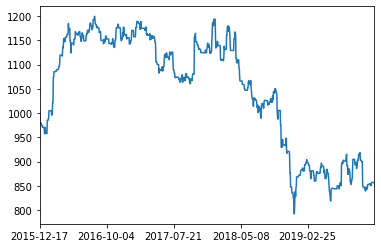

In [69]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3999/3999 [==============================] - 1s 210us/step - loss: 2.0067 - accuracy: 0.1848
Epoch 2/300
3999/3999 [==============================] - 0s 87us/step - loss: 1.9510 - accuracy: 0.1940
Epoch 3/300
3999/3999 [==============================] - 0s 123us/step - loss: 1.9303 - accuracy: 0.2071
Epoch 4/300
3999/3999 [==============================] - 0s 123us/step - loss: 1.8980 - accuracy: 0.2103
Epoch 5/300
3999/3999 [==============================] - 1s 151us/step - loss: 1.8580 - accuracy: 0.2383
Epoch 6/300
3999/3999 [==============================] - 0s 83us/step - loss: 1.8264 - accuracy: 0.2451
Epoch 7/300
3999/3999 [==============================] - 0s 82us/step - loss: 1.7844 - accuracy: 0.2608
Epoch 8/300
3999/3999 [==============================] - 0s 84us/step - loss: 1.7196 - accuracy: 0.2898
Epoch 9/300
3999/3999 [==============================] - 0s 85us/step - loss: 1.6669 - accuracy: 0.3146
Epoch 10/300
3999/3999 [==============================] - 0s

3999/3999 [==============================] - 1s 134us/step - loss: 1.0276 - accuracy: 0.5601
Epoch 78/300
3999/3999 [==============================] - 1s 218us/step - loss: 1.0349 - accuracy: 0.55711s - loss: 1.0292 
Epoch 79/300
3999/3999 [==============================] - 1s 233us/step - loss: 1.0081 - accuracy: 0.5616
Epoch 80/300
3999/3999 [==============================] - 1s 216us/step - loss: 1.0217 - accuracy: 0.5649
Epoch 81/300
3999/3999 [==============================] - 1s 148us/step - loss: 1.0215 - accuracy: 0.56410s - loss: 1.0105 - accu
Epoch 82/300
3999/3999 [==============================] - 1s 167us/step - loss: 1.0129 - accuracy: 0.56640s - loss: 1.013
Epoch 83/300
3999/3999 [==============================] - 1s 170us/step - loss: 1.0111 - accuracy: 0.5646
Epoch 84/300
3999/3999 [==============================] - 1s 154us/step - loss: 1.0420 - accuracy: 0.5484
Epoch 85/300
3999/3999 [==============================] - 0s 124us/step - loss: 1.0180 - accuracy: 0.5621
E

3999/3999 [==============================] - 0s 90us/step - loss: 0.9767 - accuracy: 0.5879
Epoch 152/300
3999/3999 [==============================] - 0s 90us/step - loss: 0.9660 - accuracy: 0.5856
Epoch 153/300
3999/3999 [==============================] - 0s 96us/step - loss: 0.9679 - accuracy: 0.5901
Epoch 154/300
3999/3999 [==============================] - 0s 84us/step - loss: 0.9463 - accuracy: 0.5929
Epoch 155/300
3999/3999 [==============================] - 0s 77us/step - loss: 0.9552 - accuracy: 0.5916
Epoch 156/300
3999/3999 [==============================] - 0s 87us/step - loss: 0.9608 - accuracy: 0.5989
Epoch 157/300
3999/3999 [==============================] - 0s 80us/step - loss: 0.9750 - accuracy: 0.5836
Epoch 158/300
3999/3999 [==============================] - 0s 72us/step - loss: 0.9507 - accuracy: 0.5874
Epoch 159/300
3999/3999 [==============================] - 0s 74us/step - loss: 0.9482 - accuracy: 0.5979
Epoch 160/300
3999/3999 [==============================] - 0

3999/3999 [==============================] - 0s 87us/step - loss: 0.9581 - accuracy: 0.5856
Epoch 229/300
3999/3999 [==============================] - 0s 97us/step - loss: 0.9317 - accuracy: 0.6057
Epoch 230/300
3999/3999 [==============================] - 0s 98us/step - loss: 0.9344 - accuracy: 0.6047
Epoch 231/300
3999/3999 [==============================] - 0s 78us/step - loss: 0.9358 - accuracy: 0.5964
Epoch 232/300
3999/3999 [==============================] - 0s 82us/step - loss: 0.9222 - accuracy: 0.6082
Epoch 233/300
3999/3999 [==============================] - 0s 96us/step - loss: 0.9283 - accuracy: 0.6024
Epoch 234/300
3999/3999 [==============================] - 0s 84us/step - loss: 0.9171 - accuracy: 0.6079
Epoch 235/300
3999/3999 [==============================] - 0s 89us/step - loss: 0.9336 - accuracy: 0.6019
Epoch 236/300
3999/3999 [==============================] - 0s 80us/step - loss: 0.9348 - accuracy: 0.5949
Epoch 237/300
3999/3999 [==============================] - 0

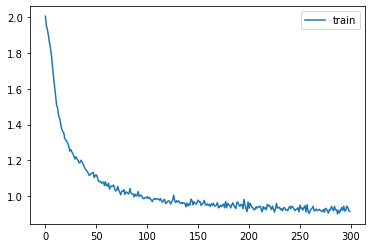

In [70]:
fit(m, c, s, i)

Model mlp
Number of classes 8
Number of steps 2
Number of indicators 6
              precision    recall  f1-score   support

          B3    0.93750   0.44118   0.60000        68
          B2    0.72152   0.51351   0.60000       111
          B1    0.66667   0.05042   0.09375       119
          B0    0.87079   0.80729   0.83784       192
          S0    0.87151   0.87151   0.87151       179
          S1    0.73469   0.25714   0.38095       140
          S2    0.73529   0.40000   0.51813       125
          S3    0.87179   0.51515   0.64762        66

   micro avg    0.82780   0.52400   0.64176      1000
   macro avg    0.80122   0.48203   0.56873      1000
weighted avg    0.79867   0.52400   0.59626      1000
 samples avg    0.52400   0.52400   0.52400      1000

Confusion matrix, without normalization
[[ 54  12   0   2   0   0   0   0]
 [ 52  57   0   2   0   0   0   0]
 [ 88  10   6  15   0   0   0   0]
 [ 33   0   3 155   1   0   0   0]
 [ 16   0   0   3 156   4   0   0]
 [ 77   0

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


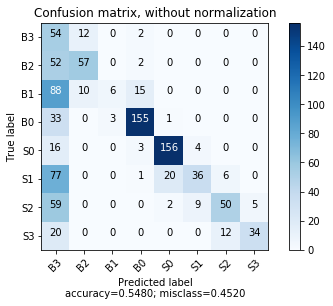

[0, 4, 1, 5, 4, 3, 6, 4, 4, 5, 5, 2, 4, 2, 1, 0, 4, 2, 2, 1, 7, 2, 3, 5, 3, 4, 6, 2, 4, 5, 2, 5, 3, 4, 6, 1, 6, 0, 5, 4, 1, 7, 3, 7, 4, 4, 6, 6, 3, 5, 6, 2, 3, 5, 3, 2, 4, 0, 7, 1, 1, 5, 5, 2, 2, 5, 4, 3, 1, 2, 6, 1, 4, 6, 3, 6, 1, 5, 4, 5, 6, 3, 7, 5, 6, 1, 2, 4, 3, 5, 1, 6, 4, 0, 2, 6, 5, 6, 4, 5, 2, 6, 1, 5, 2, 2, 1, 4, 7, 4, 3, 2, 7, 4, 5, 1, 1, 5, 6, 5, 2, 1, 1, 0, 6, 4, 4, 2, 2, 6, 3, 0, 5, 4, 6, 5, 6, 2, 3, 1, 4, 6, 4, 5, 1, 4, 6, 2, 7, 2, 2, 2, 2, 4, 6, 4, 3, 3, 2, 3, 7, 6, 6, 0, 1, 2, 4, 0, 2, 1, 2, 1, 3, 4, 4, 3, 5, 4, 3, 2, 1, 5, 1, 6, 2, 5, 4, 3, 3, 7, 0, 3, 0, 6, 0, 6, 1, 6, 3, 6, 6, 2, 1, 3, 3, 4, 5, 2, 4, 5, 6, 3, 1, 1, 1, 5, 6, 4, 3, 3, 3, 5, 5, 2, 4, 7, 7, 2, 2, 7, 5, 6, 6, 3, 4, 1, 5, 4, 6, 3, 3, 1, 4, 1, 4, 6, 3, 1, 3, 5, 4, 1, 2, 6, 3, 3, 2, 6, 3, 1, 3, 6, 4, 7, 5, 4, 4, 3, 4, 1, 6, 0, 4, 1, 2, 3, 6, 4, 4, 4, 1, 3, 7, 7, 3, 4, 1, 4, 3, 2, 6, 4, 4, 5, 2, 5, 5, 5, 4, 0, 2, 1, 1, 1, 4, 6, 5, 6, 7, 6, 6, 6, 6, 1, 1, 5, 3, 1, 3, 5, 2, 2, 1, 4, 3, 6, 4, 7, 0, 1, 1, 3, 4, 

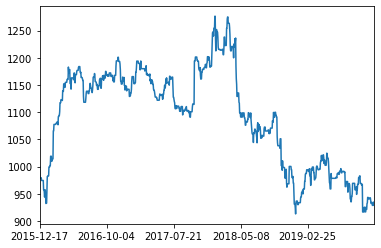

In [71]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3999/3999 [==============================] - 2s 506us/step - loss: 1.9715 - accuracy: 0.1945
Epoch 2/300
3999/3999 [==============================] - 1s 132us/step - loss: 1.8853 - accuracy: 0.2148
Epoch 3/300
3999/3999 [==============================] - 0s 91us/step - loss: 1.8449 - accuracy: 0.2343
Epoch 4/300
3999/3999 [==============================] - 0s 103us/step - loss: 1.8131 - accuracy: 0.2456
Epoch 5/300
3999/3999 [==============================] - 1s 126us/step - loss: 1.7808 - accuracy: 0.25260s - loss: 1.7835 - accuracy: 0.
Epoch 6/300
3999/3999 [==============================] - 0s 120us/step - loss: 1.7523 - accuracy: 0.2713
Epoch 7/300
3999/3999 [==============================] - 0s 102us/step - loss: 1.7209 - accuracy: 0.2783
Epoch 8/300
3999/3999 [==============================] - 0s 122us/step - loss: 1.6934 - accuracy: 0.2886
Epoch 9/300
3999/3999 [==============================] - 0s 85us/step - loss: 1.6643 - accuracy: 0.3076
Epoch 10/300
3999/3999 [=

3999/3999 [==============================] - 0s 99us/step - loss: 1.0420 - accuracy: 0.5506
Epoch 79/300
3999/3999 [==============================] - 0s 93us/step - loss: 1.0456 - accuracy: 0.5531
Epoch 80/300
3999/3999 [==============================] - 0s 96us/step - loss: 1.0223 - accuracy: 0.5634
Epoch 81/300
3999/3999 [==============================] - 0s 89us/step - loss: 1.0245 - accuracy: 0.5589
Epoch 82/300
3999/3999 [==============================] - 0s 97us/step - loss: 1.0301 - accuracy: 0.5536
Epoch 83/300
3999/3999 [==============================] - 0s 98us/step - loss: 1.0123 - accuracy: 0.5751
Epoch 84/300
3999/3999 [==============================] - 0s 92us/step - loss: 1.0239 - accuracy: 0.5561
Epoch 85/300
3999/3999 [==============================] - 0s 93us/step - loss: 1.0308 - accuracy: 0.5604
Epoch 86/300
3999/3999 [==============================] - 0s 91us/step - loss: 1.0068 - accuracy: 0.5714
Epoch 87/300
3999/3999 [==============================] - 0s 87us/st

3999/3999 [==============================] - 0s 84us/step - loss: 0.9046 - accuracy: 0.6057
Epoch 156/300
3999/3999 [==============================] - 0s 95us/step - loss: 0.9151 - accuracy: 0.6117
Epoch 157/300
3999/3999 [==============================] - 0s 89us/step - loss: 0.9149 - accuracy: 0.6152
Epoch 158/300
3999/3999 [==============================] - 0s 85us/step - loss: 0.9098 - accuracy: 0.6117
Epoch 159/300
3999/3999 [==============================] - 0s 90us/step - loss: 0.9012 - accuracy: 0.6179
Epoch 160/300
3999/3999 [==============================] - 0s 88us/step - loss: 0.9107 - accuracy: 0.6029
Epoch 161/300
3999/3999 [==============================] - 0s 89us/step - loss: 0.9055 - accuracy: 0.6122
Epoch 162/300
3999/3999 [==============================] - 0s 94us/step - loss: 0.9160 - accuracy: 0.6052
Epoch 163/300
3999/3999 [==============================] - 0s 86us/step - loss: 0.9031 - accuracy: 0.6119
Epoch 164/300
3999/3999 [==============================] - 0

3999/3999 [==============================] - 1s 152us/step - loss: 0.8643 - accuracy: 0.6234
Epoch 232/300
3999/3999 [==============================] - 1s 159us/step - loss: 0.8630 - accuracy: 0.6347
Epoch 233/300
3999/3999 [==============================] - 1s 158us/step - loss: 0.8486 - accuracy: 0.6279
Epoch 234/300
3999/3999 [==============================] - 1s 128us/step - loss: 0.8631 - accuracy: 0.6374
Epoch 235/300
3999/3999 [==============================] - 1s 165us/step - loss: 0.8541 - accuracy: 0.63690s - loss: 0.873
Epoch 236/300
3999/3999 [==============================] - 1s 136us/step - loss: 0.8716 - accuracy: 0.6362
Epoch 237/300
3999/3999 [==============================] - 0s 102us/step - loss: 0.8453 - accuracy: 0.6382
Epoch 238/300
3999/3999 [==============================] - 0s 89us/step - loss: 0.8571 - accuracy: 0.6392
Epoch 239/300
3999/3999 [==============================] - 0s 98us/step - loss: 0.8672 - accuracy: 0.6309
Epoch 240/300
3999/3999 [============

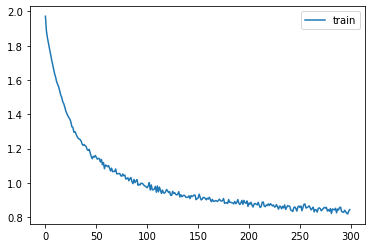

In [72]:
fit(m, c, s, i)

Model mlp
Number of classes 8
Number of steps 2
Number of indicators 8


/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

          B3    0.83333   0.51471   0.63636        68
          B2    0.72222   0.35135   0.47273       111
          B1    0.61616   0.51261   0.55963       119
          B0    0.88199   0.73958   0.80453       192
          S0    0.91034   0.73743   0.81481       179
          S1    0.68831   0.37857   0.48848       140
          S2    0.60741   0.65600   0.63077       125
          S3    0.78947   0.68182   0.73171        66

   micro avg    0.76494   0.58900   0.66554      1000
   macro avg    0.75616   0.57151   0.64238      1000
weighted avg    0.76684   0.58900   0.65819      1000
 samples avg    0.58900   0.58900   0.58900      1000

Confusion matrix, without normalization
[[ 53   9   5   0   1   0   0   0]
 [ 51  39  20   1   0   0   0   0]
 [ 41   6  61  11   0   0   0   0]
 [ 37   0  13 142   0   0   0   0]
 [ 25   0   0   7 132  15   0   0]
 [ 39   0   0   0  11  53  37   0]
 [ 21   0   0   0   1   9  82  12]
 [  5   0 

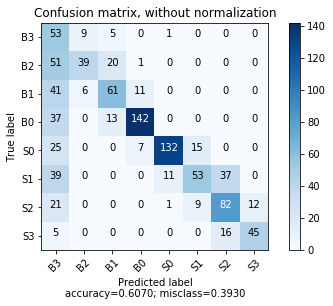

[0, 4, 1, 5, 4, 2, 6, 4, 4, 6, 5, 2, 4, 2, 1, 1, 4, 2, 2, 1, 7, 2, 3, 5, 3, 4, 6, 2, 5, 6, 2, 5, 3, 4, 6, 0, 6, 0, 4, 4, 1, 7, 3, 7, 4, 4, 6, 6, 3, 6, 7, 2, 3, 6, 3, 2, 4, 0, 6, 1, 1, 5, 6, 2, 2, 5, 5, 3, 1, 2, 6, 1, 4, 6, 3, 6, 1, 5, 4, 5, 7, 2, 7, 5, 6, 2, 2, 4, 3, 5, 1, 6, 4, 0, 2, 6, 5, 7, 4, 5, 2, 6, 1, 6, 2, 2, 1, 4, 7, 4, 3, 2, 7, 5, 5, 1, 1, 5, 7, 5, 3, 2, 1, 0, 6, 4, 4, 2, 2, 6, 3, 0, 5, 4, 6, 5, 6, 2, 2, 1, 3, 6, 5, 5, 1, 4, 6, 2, 7, 2, 2, 2, 0, 5, 6, 4, 3, 3, 2, 3, 7, 6, 6, 0, 2, 1, 5, 0, 2, 2, 2, 1, 3, 4, 4, 3, 6, 4, 3, 2, 1, 6, 1, 6, 2, 5, 4, 2, 3, 7, 0, 3, 0, 6, 0, 7, 2, 6, 3, 6, 6, 2, 1, 3, 3, 5, 6, 2, 5, 5, 6, 3, 1, 1, 2, 5, 6, 4, 3, 3, 2, 6, 6, 3, 4, 7, 7, 2, 2, 7, 6, 6, 6, 3, 4, 1, 6, 4, 6, 3, 3, 1, 4, 1, 4, 7, 1, 1, 3, 4, 4, 1, 2, 6, 3, 2, 2, 6, 3, 1, 3, 6, 5, 7, 5, 4, 3, 3, 4, 0, 6, 0, 4, 0, 2, 3, 6, 4, 4, 5, 1, 3, 7, 7, 3, 4, 1, 4, 3, 2, 6, 4, 4, 6, 2, 6, 6, 5, 5, 0, 2, 1, 2, 1, 4, 6, 5, 5, 7, 6, 6, 7, 6, 1, 1, 5, 3, 1, 3, 5, 2, 2, 1, 5, 3, 6, 4, 7, 0, 1, 1, 3, 5, 

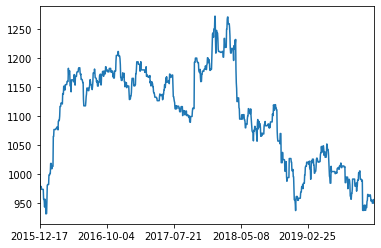

In [73]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3999/3999 [==============================] - 2s 564us/step - loss: 3.2968 - accuracy: 0.1703
Epoch 2/300
3999/3999 [==============================] - 1s 186us/step - loss: 2.0635 - accuracy: 0.1748
Epoch 3/300
3999/3999 [==============================] - 1s 269us/step - loss: 2.0579 - accuracy: 0.1733
Epoch 4/300
3999/3999 [==============================] - 1s 281us/step - loss: 2.0293 - accuracy: 0.1833
Epoch 5/300
3999/3999 [==============================] - 1s 250us/step - loss: 1.9991 - accuracy: 0.18930s - loss:
Epoch 6/300
3999/3999 [==============================] - 1s 187us/step - loss: 1.9859 - accuracy: 0.1895
Epoch 7/300
3999/3999 [==============================] - 1s 270us/step - loss: 1.9834 - accuracy: 0.18880s - los
Epoch 8/300
3999/3999 [==============================] - 1s 275us/step - loss: 1.9626 - accuracy: 0.2031
Epoch 9/300
3999/3999 [==============================] - 1s 207us/step - loss: 1.9541 - accuracy: 0.2068
Epoch 10/300
3999/3999 [=============

3999/3999 [==============================] - 1s 140us/step - loss: 1.6486 - accuracy: 0.32660s - loss: 1.6476 - accuracy
Epoch 77/300
3999/3999 [==============================] - 1s 126us/step - loss: 1.6535 - accuracy: 0.3268
Epoch 78/300
3999/3999 [==============================] - 1s 133us/step - loss: 1.6466 - accuracy: 0.3276
Epoch 79/300
3999/3999 [==============================] - 0s 103us/step - loss: 1.6484 - accuracy: 0.3088
Epoch 80/300
3999/3999 [==============================] - 0s 114us/step - loss: 1.6392 - accuracy: 0.3203
Epoch 81/300
3999/3999 [==============================] - 0s 104us/step - loss: 1.6356 - accuracy: 0.3241
Epoch 82/300
3999/3999 [==============================] - 1s 146us/step - loss: 1.6054 - accuracy: 0.3366
Epoch 83/300
3999/3999 [==============================] - 0s 97us/step - loss: 1.6049 - accuracy: 0.3358
Epoch 84/300
3999/3999 [==============================] - 0s 96us/step - loss: 1.6495 - accuracy: 0.3256
Epoch 85/300
3999/3999 [=========

3999/3999 [==============================] - 0s 80us/step - loss: 1.5040 - accuracy: 0.3768
Epoch 153/300
3999/3999 [==============================] - 0s 75us/step - loss: 1.5116 - accuracy: 0.3738
Epoch 154/300
3999/3999 [==============================] - 0s 76us/step - loss: 1.5071 - accuracy: 0.3731
Epoch 155/300
3999/3999 [==============================] - 0s 80us/step - loss: 1.4886 - accuracy: 0.3846
Epoch 156/300
3999/3999 [==============================] - 0s 115us/step - loss: 1.5016 - accuracy: 0.3861
Epoch 157/300
3999/3999 [==============================] - 0s 101us/step - loss: 1.4935 - accuracy: 0.3703
Epoch 158/300
3999/3999 [==============================] - 0s 85us/step - loss: 1.4985 - accuracy: 0.3806
Epoch 159/300
3999/3999 [==============================] - 0s 88us/step - loss: 1.4880 - accuracy: 0.3798
Epoch 160/300
3999/3999 [==============================] - 1s 173us/step - loss: 1.4917 - accuracy: 0.3741
Epoch 161/300
3999/3999 [==============================] 

3999/3999 [==============================] - 0s 109us/step - loss: 1.3813 - accuracy: 0.4131
Epoch 229/300
3999/3999 [==============================] - 0s 88us/step - loss: 1.4467 - accuracy: 0.3996
Epoch 230/300
3999/3999 [==============================] - 0s 94us/step - loss: 1.3786 - accuracy: 0.4201
Epoch 231/300
3999/3999 [==============================] - 0s 86us/step - loss: 1.4151 - accuracy: 0.4066
Epoch 232/300
3999/3999 [==============================] - 0s 76us/step - loss: 1.4137 - accuracy: 0.4006
Epoch 233/300
3999/3999 [==============================] - 0s 80us/step - loss: 1.3757 - accuracy: 0.4146
Epoch 234/300
3999/3999 [==============================] - 0s 78us/step - loss: 1.4330 - accuracy: 0.3941
Epoch 235/300
3999/3999 [==============================] - 0s 84us/step - loss: 1.4262 - accuracy: 0.3981
Epoch 236/300
3999/3999 [==============================] - 0s 121us/step - loss: 1.4125 - accuracy: 0.4089
Epoch 237/300
3999/3999 [==============================] -

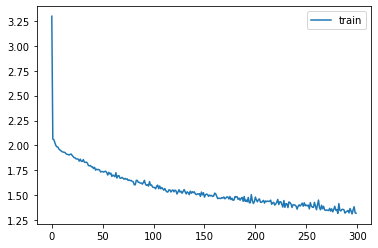

In [74]:
fit(m, c, s, i)

Model mlp
Number of classes 8
Number of steps 2
Number of indicators 11
              precision    recall  f1-score   support

          B3    0.65714   0.33824   0.44660        68
          B2    0.41176   0.06306   0.10937       111
          B1    0.00000   0.00000   0.00000       119
          B0    0.63158   0.06250   0.11374       192
          S0    0.50000   0.01676   0.03243       179
          S1    0.00000   0.00000   0.00000       140
          S2    0.37500   0.02400   0.04511       125
          S3    0.65116   0.42424   0.51376        66

   micro avg    0.59375   0.07600   0.13475      1000
   macro avg    0.40333   0.11610   0.15763      1000
weighted avg    0.39101   0.07600   0.10970      1000
 samples avg    0.07600   0.07600   0.07600      1000

Confusion matrix, without normalization
[[ 63   5   0   0   0   0   0   0]
 [103   7   0   1   0   0   0   0]
 [114   4   0   1   0   0   0   0]
 [178   1   0  12   1   0   0   0]
 [171   0   0   5   3   0   0   0]
 [133   

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


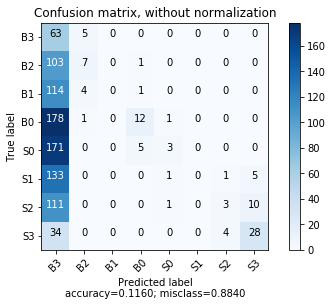

[0, 4, 0, 6, 3, 6, 4, 4, 4, 4, 4, 3, 4, 3, 0, 1, 1, 3, 3, 1, 7, 1, 4, 6, 3, 4, 6, 1, 6, 7, 3, 6, 3, 4, 4, 1, 4, 1, 6, 3, 2, 7, 3, 6, 3, 3, 6, 7, 3, 4, 6, 1, 3, 7, 3, 3, 4, 0, 4, 0, 1, 4, 4, 3, 3, 4, 4, 3, 1, 3, 4, 2, 4, 5, 3, 6, 1, 6, 4, 6, 7, 1, 6, 4, 4, 1, 3, 7, 4, 6, 3, 6, 3, 0, 1, 4, 4, 5, 4, 4, 1, 4, 1, 6, 3, 1, 3, 5, 7, 3, 3, 3, 6, 3, 4, 1, 3, 4, 7, 4, 3, 2, 1, 0, 4, 3, 4, 3, 1, 7, 1, 0, 4, 4, 6, 4, 6, 3, 1, 1, 4, 4, 4, 4, 0, 4, 5, 3, 7, 4, 1, 3, 1, 4, 6, 4, 3, 3, 1, 3, 6, 4, 4, 1, 1, 0, 3, 0, 3, 1, 3, 0, 3, 4, 4, 3, 6, 3, 4, 3, 4, 3, 3, 7, 3, 6, 4, 3, 3, 6, 1, 3, 0, 6, 0, 7, 1, 4, 3, 6, 4, 3, 0, 3, 3, 4, 4, 3, 4, 4, 6, 3, 1, 1, 3, 4, 7, 4, 4, 4, 1, 6, 6, 1, 3, 6, 6, 3, 3, 6, 4, 6, 5, 3, 4, 0, 5, 4, 6, 3, 4, 1, 4, 1, 4, 7, 0, 3, 3, 4, 4, 1, 3, 6, 3, 3, 1, 4, 3, 3, 3, 6, 6, 4, 5, 4, 4, 3, 4, 1, 6, 0, 4, 0, 3, 3, 6, 4, 4, 4, 3, 3, 7, 7, 4, 6, 0, 4, 3, 1, 4, 4, 6, 6, 2, 7, 4, 6, 4, 1, 3, 1, 1, 0, 4, 4, 4, 3, 7, 4, 7, 6, 6, 1, 3, 5, 5, 1, 1, 6, 1, 2, 0, 4, 3, 4, 4, 6, 1, 1, 1, 3, 4, 

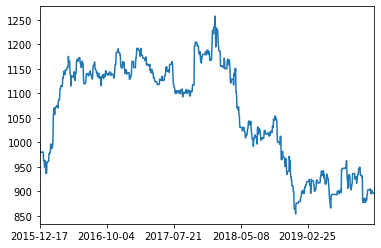

In [75]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 1s 197us/step - loss: 2.0051 - accuracy: 0.1797
Epoch 2/300
3996/3996 [==============================] - 0s 84us/step - loss: 1.9281 - accuracy: 0.2147
Epoch 3/300
3996/3996 [==============================] - 0s 90us/step - loss: 1.8805 - accuracy: 0.2260
Epoch 4/300
3996/3996 [==============================] - 0s 95us/step - loss: 1.8632 - accuracy: 0.2417
Epoch 5/300
3996/3996 [==============================] - 0s 85us/step - loss: 1.8357 - accuracy: 0.2462
Epoch 6/300
3996/3996 [==============================] - 0s 108us/step - loss: 1.8225 - accuracy: 0.25500s - loss: 1.8175 - accu
Epoch 7/300
3996/3996 [==============================] - 0s 103us/step - loss: 1.7995 - accuracy: 0.2540
Epoch 8/300
3996/3996 [==============================] - 0s 94us/step - loss: 1.7885 - accuracy: 0.2590
Epoch 9/300
3996/3996 [==============================] - 0s 121us/step - loss: 1.7855 - accuracy: 0.2628
Epoch 10/300
3996/3996 [============

3996/3996 [==============================] - 0s 118us/step - loss: 1.6201 - accuracy: 0.3363
Epoch 78/300
3996/3996 [==============================] - 1s 132us/step - loss: 1.6139 - accuracy: 0.3391
Epoch 79/300
3996/3996 [==============================] - 0s 120us/step - loss: 1.6125 - accuracy: 0.3283
Epoch 80/300
3996/3996 [==============================] - 0s 99us/step - loss: 1.6153 - accuracy: 0.3456
Epoch 81/300
3996/3996 [==============================] - 0s 112us/step - loss: 1.6070 - accuracy: 0.3381
Epoch 82/300
3996/3996 [==============================] - 0s 110us/step - loss: 1.6049 - accuracy: 0.3511
Epoch 83/300
3996/3996 [==============================] - 1s 127us/step - loss: 1.5981 - accuracy: 0.3481
Epoch 84/300
3996/3996 [==============================] - 1s 188us/step - loss: 1.6108 - accuracy: 0.3436
Epoch 85/300
3996/3996 [==============================] - 1s 155us/step - loss: 1.6049 - accuracy: 0.3366
Epoch 86/300
3996/3996 [==============================] - 1s

Epoch 154/300
3996/3996 [==============================] - 0s 93us/step - loss: 1.5700 - accuracy: 0.3594
Epoch 155/300
3996/3996 [==============================] - 0s 94us/step - loss: 1.5656 - accuracy: 0.3634
Epoch 156/300
3996/3996 [==============================] - 0s 75us/step - loss: 1.5693 - accuracy: 0.3571
Epoch 157/300
3996/3996 [==============================] - 0s 90us/step - loss: 1.5703 - accuracy: 0.3594
Epoch 158/300
3996/3996 [==============================] - 0s 110us/step - loss: 1.5733 - accuracy: 0.3519
Epoch 159/300
3996/3996 [==============================] - 0s 98us/step - loss: 1.5644 - accuracy: 0.3619
Epoch 160/300
3996/3996 [==============================] - 0s 82us/step - loss: 1.5638 - accuracy: 0.3664
Epoch 161/300
3996/3996 [==============================] - 0s 96us/step - loss: 1.5592 - accuracy: 0.3546
Epoch 162/300
3996/3996 [==============================] - 0s 82us/step - loss: 1.5701 - accuracy: 0.3666
Epoch 163/300
3996/3996 [====================

3996/3996 [==============================] - 1s 139us/step - loss: 1.5421 - accuracy: 0.3694
Epoch 231/300
3996/3996 [==============================] - 1s 126us/step - loss: 1.5541 - accuracy: 0.3496
Epoch 232/300
3996/3996 [==============================] - 0s 91us/step - loss: 1.5596 - accuracy: 0.3579
Epoch 233/300
3996/3996 [==============================] - 0s 97us/step - loss: 1.5445 - accuracy: 0.3619
Epoch 234/300
3996/3996 [==============================] - 0s 78us/step - loss: 1.5448 - accuracy: 0.3599
Epoch 235/300
3996/3996 [==============================] - 0s 86us/step - loss: 1.5582 - accuracy: 0.3556
Epoch 236/300
3996/3996 [==============================] - 0s 84us/step - loss: 1.5494 - accuracy: 0.3616
Epoch 237/300
3996/3996 [==============================] - 0s 81us/step - loss: 1.5541 - accuracy: 0.3626
Epoch 238/300
3996/3996 [==============================] - 0s 83us/step - loss: 1.5657 - accuracy: 0.3509
Epoch 239/300
3996/3996 [==============================] -

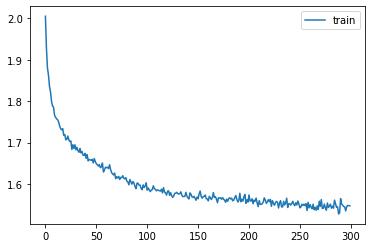

In [76]:
fit(m, c, s, i)

Model mlp
Number of classes 8
Number of steps 5
Number of indicators 3
              precision    recall  f1-score   support

          B3    0.88235   0.19737   0.32258        76
          B2    0.00000   0.00000   0.00000        95
          B1    0.00000   0.00000   0.00000       120
          B0    0.00000   0.00000   0.00000       199
          S0    0.00000   0.00000   0.00000       189
          S1    0.00000   0.00000   0.00000       125
          S2    0.00000   0.00000   0.00000       137
          S3    0.64000   0.27119   0.38095        59

   micro avg    0.73810   0.03100   0.05950      1000
   macro avg    0.19029   0.05857   0.08794      1000
weighted avg    0.10482   0.03100   0.04699      1000
 samples avg    0.03100   0.03100   0.03100      1000

Confusion matrix, without normalization
[[ 76   0   0   0   0   0   0   0]
 [ 94   0   0   0   0   0   0   1]
 [119   0   0   0   0   0   0   1]
 [199   0   0   0   0   0   0   0]
 [188   0   0   0   0   0   0   1]
 [124   0

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


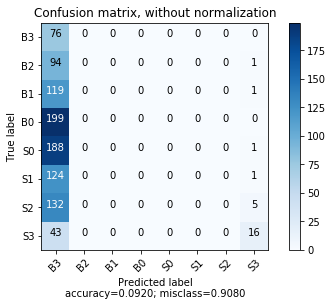

[3, 4, 2, 4, 4, 5, 1, 2, 2, 3, 6, 5, 3, 4, 4, 4, 5, 3, 3, 2, 4, 4, 3, 3, 3, 4, 3, 0, 4, 6, 3, 4, 4, 4, 4, 3, 1, 5, 2, 2, 3, 1, 4, 3, 3, 0, 5, 5, 7, 4, 7, 3, 3, 3, 4, 4, 3, 3, 4, 3, 4, 1, 3, 6, 6, 6, 7, 3, 7, 4, 6, 1, 2, 3, 3, 4, 6, 3, 3, 6, 3, 7, 5, 0, 1, 6, 6, 1, 3, 1, 1, 3, 4, 3, 3, 1, 3, 3, 3, 2, 1, 6, 0, 4, 7, 6, 3, 4, 6, 6, 6, 3, 6, 1, 4, 6, 6, 1, 4, 4, 6, 3, 3, 3, 3, 6, 4, 3, 3, 6, 1, 6, 4, 2, 1, 4, 4, 6, 4, 4, 5, 4, 3, 3, 2, 0, 3, 3, 1, 5, 1, 1, 4, 3, 1, 4, 7, 4, 3, 3, 3, 1, 3, 4, 4, 4, 0, 7, 6, 1, 1, 7, 4, 6, 4, 6, 4, 4, 4, 6, 1, 2, 4, 3, 0, 1, 3, 4, 6, 4, 3, 4, 7, 5, 6, 4, 7, 6, 6, 4, 3, 3, 1, 3, 4, 4, 7, 7, 1, 2, 3, 7, 1, 6, 4, 0, 1, 6, 3, 4, 2, 3, 4, 4, 4, 4, 3, 4, 4, 6, 4, 1, 3, 6, 1, 4, 3, 4, 4, 1, 4, 4, 4, 3, 6, 3, 3, 1, 3, 4, 6, 5, 4, 4, 0, 4, 3, 6, 3, 1, 0, 2, 3, 4, 2, 4, 3, 4, 6, 4, 7, 5, 5, 3, 6, 6, 1, 6, 0, 4, 1, 7, 3, 3, 4, 4, 5, 3, 4, 3, 6, 3, 2, 3, 3, 4, 6, 1, 6, 4, 1, 1, 3, 3, 3, 6, 7, 4, 3, 7, 1, 4, 7, 1, 4, 3, 1, 1, 1, 4, 6, 4, 1, 7, 4, 4, 4, 3, 6, 2, 3, 5, 4, 

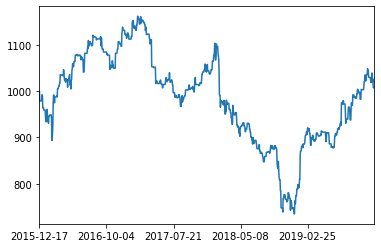

In [77]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 1s 296us/step - loss: 1.9573 - accuracy: 0.1992
Epoch 2/300
3996/3996 [==============================] - 0s 83us/step - loss: 1.8233 - accuracy: 0.2415
Epoch 3/300
3996/3996 [==============================] - 1s 167us/step - loss: 1.7458 - accuracy: 0.2790
Epoch 4/300
3996/3996 [==============================] - 1s 155us/step - loss: 1.6983 - accuracy: 0.2845
Epoch 5/300
3996/3996 [==============================] - 1s 185us/step - loss: 1.6642 - accuracy: 0.3048
Epoch 6/300
3996/3996 [==============================] - 0s 124us/step - loss: 1.6378 - accuracy: 0.3131
Epoch 7/300
3996/3996 [==============================] - 1s 219us/step - loss: 1.6071 - accuracy: 0.3378
Epoch 8/300
3996/3996 [==============================] - 1s 149us/step - loss: 1.5881 - accuracy: 0.3386
Epoch 9/300
3996/3996 [==============================] - 1s 181us/step - loss: 1.5676 - accuracy: 0.3403
Epoch 10/300
3996/3996 [==============================] 

3996/3996 [==============================] - 0s 84us/step - loss: 0.9422 - accuracy: 0.5968
Epoch 79/300
3996/3996 [==============================] - 0s 83us/step - loss: 0.9360 - accuracy: 0.6001
Epoch 80/300
3996/3996 [==============================] - 0s 96us/step - loss: 0.9416 - accuracy: 0.5998
Epoch 81/300
3996/3996 [==============================] - 1s 140us/step - loss: 0.9423 - accuracy: 0.5871
Epoch 82/300
3996/3996 [==============================] - 0s 100us/step - loss: 0.9407 - accuracy: 0.5946
Epoch 83/300
3996/3996 [==============================] - 0s 100us/step - loss: 0.9316 - accuracy: 0.6031
Epoch 84/300
3996/3996 [==============================] - 0s 97us/step - loss: 0.9299 - accuracy: 0.6111
Epoch 85/300
3996/3996 [==============================] - 0s 95us/step - loss: 0.9131 - accuracy: 0.6084
Epoch 86/300
3996/3996 [==============================] - 0s 90us/step - loss: 0.9205 - accuracy: 0.6071
Epoch 87/300
3996/3996 [==============================] - 0s 81us

3996/3996 [==============================] - 0s 98us/step - loss: 0.8674 - accuracy: 0.6264
Epoch 155/300
3996/3996 [==============================] - 0s 90us/step - loss: 0.8470 - accuracy: 0.6311
Epoch 156/300
3996/3996 [==============================] - 0s 85us/step - loss: 0.8527 - accuracy: 0.6326
Epoch 157/300
3996/3996 [==============================] - 0s 95us/step - loss: 0.8586 - accuracy: 0.6369
Epoch 158/300
3996/3996 [==============================] - 0s 89us/step - loss: 0.8504 - accuracy: 0.6401
Epoch 159/300
3996/3996 [==============================] - 0s 86us/step - loss: 0.8397 - accuracy: 0.6469
Epoch 160/300
3996/3996 [==============================] - 0s 89us/step - loss: 0.8324 - accuracy: 0.6592
Epoch 161/300
3996/3996 [==============================] - 1s 182us/step - loss: 0.8321 - accuracy: 0.6354
Epoch 162/300
3996/3996 [==============================] - 0s 115us/step - loss: 0.8499 - accuracy: 0.6459
Epoch 163/300
3996/3996 [==============================] -

3996/3996 [==============================] - 0s 92us/step - loss: 0.8103 - accuracy: 0.6557
Epoch 231/300
3996/3996 [==============================] - 0s 88us/step - loss: 0.8026 - accuracy: 0.6689
Epoch 232/300
3996/3996 [==============================] - 0s 94us/step - loss: 0.8219 - accuracy: 0.6552
Epoch 233/300
3996/3996 [==============================] - 0s 94us/step - loss: 0.8035 - accuracy: 0.6539
Epoch 234/300
3996/3996 [==============================] - 0s 88us/step - loss: 0.8110 - accuracy: 0.6499
Epoch 235/300
3996/3996 [==============================] - 0s 84us/step - loss: 0.7983 - accuracy: 0.6604
Epoch 236/300
3996/3996 [==============================] - 0s 116us/step - loss: 0.8281 - accuracy: 0.6486
Epoch 237/300
3996/3996 [==============================] - 0s 105us/step - loss: 0.8188 - accuracy: 0.6499
Epoch 238/300
3996/3996 [==============================] - 0s 110us/step - loss: 0.8316 - accuracy: 0.6569
Epoch 239/300
3996/3996 [==============================] 

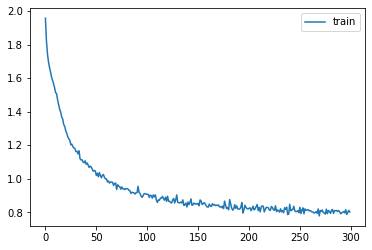

In [78]:
fit(m, c, s, i)

Model mlp
Number of classes 8
Number of steps 5
Number of indicators 6
              precision    recall  f1-score   support

          B3    0.93023   0.52632   0.67227        76
          B2    0.63303   0.72632   0.67647        95
          B1    0.72222   0.43333   0.54167       120
          B0    0.86813   0.79397   0.82940       199
          S0    0.83060   0.80423   0.81720       189
          S1    0.60938   0.62400   0.61660       125
          S2    0.71200   0.64964   0.67939       137
          S3    0.80392   0.69492   0.74545        59

   micro avg    0.76036   0.67900   0.71738      1000
   macro avg    0.76369   0.65659   0.69731      1000
weighted avg    0.76839   0.67900   0.71399      1000
 samples avg    0.67900   0.67900   0.67900      1000

Confusion matrix, without normalization
[[ 50  25   1   0   0   0   0   0]
 [ 19  69   5   2   0   0   0   0]
 [ 31  15  52  21   0   1   0   0]
 [  9   0  14 158  18   0   0   0]
 [  8   0   0   1 152  28   0   0]
 [ 15   0

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


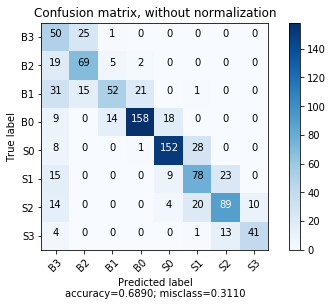

[3, 5, 2, 4, 3, 3, 1, 2, 3, 4, 6, 5, 4, 4, 5, 3, 4, 6, 3, 2, 2, 4, 2, 3, 4, 3, 3, 0, 5, 5, 3, 4, 5, 6, 3, 4, 2, 4, 2, 2, 4, 1, 6, 4, 2, 1, 4, 6, 7, 4, 7, 3, 4, 3, 3, 2, 3, 4, 5, 5, 6, 3, 2, 6, 7, 6, 7, 3, 7, 3, 7, 1, 1, 4, 3, 4, 6, 4, 4, 7, 3, 4, 2, 0, 1, 5, 5, 2, 1, 1, 1, 5, 4, 3, 1, 4, 4, 3, 3, 1, 2, 6, 0, 5, 7, 4, 3, 4, 7, 6, 6, 5, 4, 1, 5, 5, 6, 1, 4, 5, 6, 3, 3, 1, 4, 3, 5, 2, 3, 6, 1, 4, 3, 1, 2, 2, 5, 6, 4, 4, 5, 5, 2, 4, 1, 0, 3, 2, 1, 6, 1, 4, 4, 3, 2, 5, 7, 5, 4, 1, 4, 1, 3, 3, 4, 4, 4, 3, 6, 0, 4, 7, 4, 6, 4, 6, 4, 6, 5, 6, 2, 1, 5, 4, 0, 2, 1, 6, 4, 3, 4, 4, 5, 4, 4, 3, 6, 6, 7, 7, 5, 5, 1, 5, 5, 4, 6, 7, 3, 3, 3, 7, 1, 6, 4, 0, 4, 5, 2, 6, 3, 3, 4, 4, 6, 6, 3, 4, 5, 6, 5, 1, 5, 5, 4, 5, 4, 4, 5, 4, 4, 6, 4, 3, 5, 3, 3, 3, 3, 4, 6, 3, 6, 5, 0, 4, 3, 5, 4, 1, 0, 3, 4, 4, 3, 3, 5, 4, 6, 6, 7, 6, 5, 2, 6, 5, 1, 7, 3, 2, 1, 6, 4, 1, 5, 4, 5, 6, 6, 3, 7, 6, 3, 3, 2, 3, 5, 1, 6, 4, 1, 1, 4, 3, 3, 6, 7, 5, 5, 7, 1, 4, 6, 4, 4, 1, 2, 2, 2, 3, 6, 5, 2, 3, 4, 4, 5, 3, 6, 3, 3, 4, 2, 

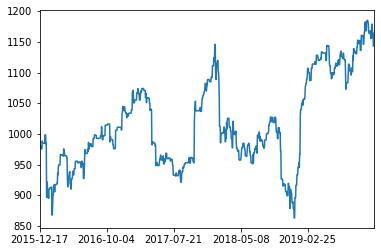

In [79]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 2s 438us/step - loss: 1.9290 - accuracy: 0.2117
Epoch 2/300
3996/3996 [==============================] - 1s 166us/step - loss: 1.7937 - accuracy: 0.2640
Epoch 3/300
3996/3996 [==============================] - 1s 127us/step - loss: 1.7546 - accuracy: 0.2710
Epoch 4/300
3996/3996 [==============================] - 0s 119us/step - loss: 1.7315 - accuracy: 0.2798
Epoch 5/300
3996/3996 [==============================] - 0s 113us/step - loss: 1.7042 - accuracy: 0.2878
Epoch 6/300
3996/3996 [==============================] - 0s 97us/step - loss: 1.6710 - accuracy: 0.2995
Epoch 7/300
3996/3996 [==============================] - 0s 96us/step - loss: 1.6585 - accuracy: 0.3118
Epoch 8/300
3996/3996 [==============================] - 0s 93us/step - loss: 1.6295 - accuracy: 0.3298
Epoch 9/300
3996/3996 [==============================] - 0s 107us/step - loss: 1.6165 - accuracy: 0.3273
Epoch 10/300
3996/3996 [==============================] - 

3996/3996 [==============================] - 1s 132us/step - loss: 1.0292 - accuracy: 0.5593
Epoch 79/300
3996/3996 [==============================] - 1s 148us/step - loss: 1.0036 - accuracy: 0.5701
Epoch 80/300
3996/3996 [==============================] - 0s 91us/step - loss: 0.9993 - accuracy: 0.5736
Epoch 81/300
3996/3996 [==============================] - 1s 132us/step - loss: 1.0000 - accuracy: 0.5741
Epoch 82/300
3996/3996 [==============================] - 1s 171us/step - loss: 1.0077 - accuracy: 0.5661
Epoch 83/300
3996/3996 [==============================] - 1s 136us/step - loss: 0.9811 - accuracy: 0.58060s - loss: 0.9839 - accuracy: 0.57
Epoch 84/300
3996/3996 [==============================] - 1s 130us/step - loss: 0.9979 - accuracy: 0.5768
Epoch 85/300
3996/3996 [==============================] - 1s 155us/step - loss: 0.9828 - accuracy: 0.5758
Epoch 86/300
3996/3996 [==============================] - 0s 122us/step - loss: 0.9916 - accuracy: 0.5888
Epoch 87/300
3996/3996 [==

3996/3996 [==============================] - 0s 110us/step - loss: 0.8756 - accuracy: 0.6321
Epoch 154/300
3996/3996 [==============================] - 0s 99us/step - loss: 0.8756 - accuracy: 0.6284
Epoch 155/300
3996/3996 [==============================] - 0s 103us/step - loss: 0.8527 - accuracy: 0.6379
Epoch 156/300
3996/3996 [==============================] - 0s 102us/step - loss: 0.8714 - accuracy: 0.61890s - loss: 0.8753 - accu
Epoch 157/300
3996/3996 [==============================] - 0s 109us/step - loss: 0.8601 - accuracy: 0.6286
Epoch 158/300
3996/3996 [==============================] - 0s 91us/step - loss: 0.8751 - accuracy: 0.6259
Epoch 159/300
3996/3996 [==============================] - 0s 93us/step - loss: 0.8753 - accuracy: 0.6271
Epoch 160/300
3996/3996 [==============================] - 0s 96us/step - loss: 0.8758 - accuracy: 0.6316
Epoch 161/300
3996/3996 [==============================] - 0s 97us/step - loss: 0.8740 - accuracy: 0.6319
Epoch 162/300
3996/3996 [=======

3996/3996 [==============================] - 0s 93us/step - loss: 0.8368 - accuracy: 0.6454
Epoch 230/300
3996/3996 [==============================] - 0s 97us/step - loss: 0.8167 - accuracy: 0.6617
Epoch 231/300
3996/3996 [==============================] - 0s 111us/step - loss: 0.8321 - accuracy: 0.6469
Epoch 232/300
3996/3996 [==============================] - 1s 135us/step - loss: 0.7991 - accuracy: 0.6697
Epoch 233/300
3996/3996 [==============================] - 0s 118us/step - loss: 0.8125 - accuracy: 0.6514
Epoch 234/300
3996/3996 [==============================] - 0s 114us/step - loss: 0.7955 - accuracy: 0.6624
Epoch 235/300
3996/3996 [==============================] - 0s 119us/step - loss: 0.7932 - accuracy: 0.6679
Epoch 236/300
3996/3996 [==============================] - 1s 126us/step - loss: 0.8247 - accuracy: 0.6444
Epoch 237/300
3996/3996 [==============================] - 1s 132us/step - loss: 0.8107 - accuracy: 0.6502
Epoch 238/300
3996/3996 [============================

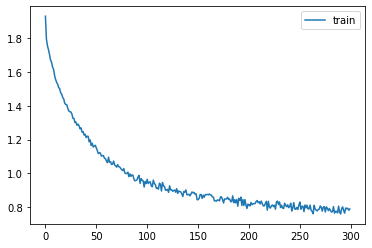

In [80]:
fit(m, c, s, i)

Model mlp
Number of classes 8
Number of steps 5
Number of indicators 8
              precision    recall  f1-score   support

          B3    0.94595   0.46053   0.61947        76
          B2    0.57692   0.47368   0.52023        95
          B1    0.65882   0.46667   0.54634       120
          B0    0.80000   0.74372   0.77083       199
          S0    0.77540   0.76720   0.77128       189
          S1    0.62609   0.57600   0.60000       125
          S2    0.73276   0.62044   0.67194       137
          S3    0.78261   0.61017   0.68571        59

   micro avg    0.73263   0.62200   0.67280      1000
   macro avg    0.73732   0.58980   0.64823      1000
weighted avg    0.73633   0.62200   0.66874      1000
 samples avg    0.62200   0.62200   0.62200      1000

Confusion matrix, without normalization
[[ 47  28   1   0   0   0   0   0]
 [ 25  45  21   4   0   0   0   0]
 [ 28   5  56  31   0   0   0   0]
 [ 11   0   7 148  33   0   0   0]
 [ 23   0   0   2 145  19   0   0]
 [ 29   0

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


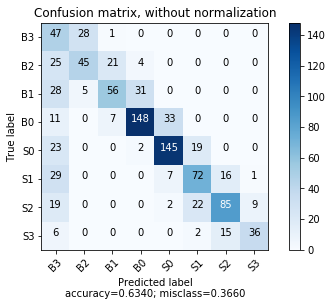

[3, 5, 3, 4, 4, 3, 1, 2, 3, 4, 6, 6, 4, 4, 4, 3, 4, 6, 3, 2, 2, 4, 3, 3, 4, 3, 3, 0, 4, 5, 3, 4, 5, 6, 3, 4, 2, 4, 2, 2, 4, 2, 6, 4, 2, 1, 4, 6, 7, 4, 7, 3, 4, 3, 3, 2, 3, 4, 5, 6, 6, 3, 2, 6, 6, 7, 7, 3, 7, 4, 6, 1, 2, 4, 3, 4, 6, 4, 4, 6, 3, 4, 3, 1, 2, 5, 5, 2, 2, 1, 1, 5, 4, 3, 2, 4, 4, 3, 3, 2, 3, 6, 1, 5, 7, 4, 3, 4, 6, 6, 6, 5, 4, 1, 5, 5, 6, 1, 4, 5, 6, 3, 3, 2, 4, 4, 5, 2, 3, 6, 1, 4, 3, 2, 3, 3, 5, 6, 4, 4, 5, 5, 2, 4, 1, 0, 3, 3, 1, 6, 2, 4, 4, 3, 2, 4, 7, 5, 4, 1, 4, 1, 3, 3, 4, 4, 4, 2, 6, 0, 4, 7, 4, 6, 4, 5, 4, 6, 5, 6, 3, 1, 5, 4, 0, 2, 2, 6, 4, 3, 4, 4, 2, 5, 5, 4, 6, 6, 7, 6, 5, 5, 1, 5, 5, 4, 6, 7, 3, 3, 3, 7, 0, 5, 4, 0, 3, 6, 3, 6, 3, 3, 4, 4, 7, 6, 3, 4, 5, 7, 5, 1, 4, 5, 4, 5, 4, 4, 5, 4, 3, 6, 4, 3, 5, 3, 3, 3, 4, 4, 6, 3, 7, 5, 0, 4, 3, 4, 4, 2, 1, 4, 4, 4, 3, 3, 4, 4, 6, 5, 7, 6, 5, 3, 6, 6, 1, 7, 2, 2, 1, 7, 3, 2, 5, 4, 5, 5, 5, 3, 7, 6, 4, 3, 2, 3, 5, 1, 6, 4, 1, 2, 4, 3, 3, 6, 7, 5, 5, 7, 1, 4, 6, 3, 4, 1, 2, 3, 2, 3, 6, 5, 2, 3, 4, 4, 5, 3, 5, 3, 3, 4, 3, 

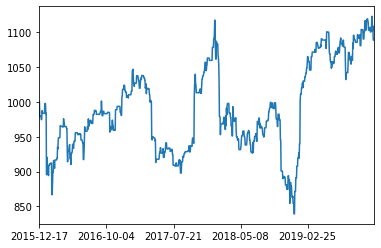

In [81]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 2s 434us/step - loss: 4.3081 - accuracy: 0.1491
Epoch 2/300
3996/3996 [==============================] - 0s 113us/step - loss: 2.0763 - accuracy: 0.1784
Epoch 3/300
3996/3996 [==============================] - 0s 95us/step - loss: 2.0398 - accuracy: 0.1732
Epoch 4/300
3996/3996 [==============================] - 0s 115us/step - loss: 2.0225 - accuracy: 0.1832
Epoch 5/300
3996/3996 [==============================] - 0s 99us/step - loss: 1.9941 - accuracy: 0.1947
Epoch 6/300
3996/3996 [==============================] - 0s 115us/step - loss: 1.9858 - accuracy: 0.1959
Epoch 7/300
3996/3996 [==============================] - 0s 101us/step - loss: 1.9665 - accuracy: 0.1989
Epoch 8/300
3996/3996 [==============================] - 1s 177us/step - loss: 1.9608 - accuracy: 0.2040
Epoch 9/300
3996/3996 [==============================] - 1s 196us/step - loss: 1.9561 - accuracy: 0.2047
Epoch 10/300
3996/3996 [==============================] -

3996/3996 [==============================] - 1s 135us/step - loss: 1.5874 - accuracy: 0.3471
Epoch 79/300
3996/3996 [==============================] - 1s 137us/step - loss: 1.6030 - accuracy: 0.3466
Epoch 80/300
3996/3996 [==============================] - 0s 120us/step - loss: 1.5913 - accuracy: 0.3516
Epoch 81/300
3996/3996 [==============================] - 1s 155us/step - loss: 1.5741 - accuracy: 0.3486
Epoch 82/300
3996/3996 [==============================] - 1s 215us/step - loss: 1.5841 - accuracy: 0.3521
Epoch 83/300
3996/3996 [==============================] - 1s 191us/step - loss: 1.5896 - accuracy: 0.3436
Epoch 84/300
3996/3996 [==============================] - 1s 145us/step - loss: 1.5869 - accuracy: 0.3514
Epoch 85/300
3996/3996 [==============================] - 1s 172us/step - loss: 1.5974 - accuracy: 0.3378
Epoch 86/300
3996/3996 [==============================] - 1s 144us/step - loss: 1.5978 - accuracy: 0.3488
Epoch 87/300
3996/3996 [==============================] - 1

3996/3996 [==============================] - 0s 96us/step - loss: 1.4611 - accuracy: 0.3849
Epoch 155/300
3996/3996 [==============================] - 1s 179us/step - loss: 1.4690 - accuracy: 0.3886
Epoch 156/300
3996/3996 [==============================] - 1s 129us/step - loss: 1.4559 - accuracy: 0.3919
Epoch 157/300
3996/3996 [==============================] - 1s 126us/step - loss: 1.4403 - accuracy: 0.3981
Epoch 158/300
3996/3996 [==============================] - 2s 429us/step - loss: 1.4542 - accuracy: 0.3919
Epoch 159/300
3996/3996 [==============================] - 1s 256us/step - loss: 1.4530 - accuracy: 0.3924
Epoch 160/300
3996/3996 [==============================] - 0s 106us/step - loss: 1.4419 - accuracy: 0.4124
Epoch 161/300
3996/3996 [==============================] - 1s 169us/step - loss: 1.4720 - accuracy: 0.4037
Epoch 162/300
3996/3996 [==============================] - 1s 136us/step - loss: 1.4722 - accuracy: 0.3829
Epoch 163/300
3996/3996 [===========================

3996/3996 [==============================] - 0s 89us/step - loss: 1.3918 - accuracy: 0.4222
Epoch 231/300
3996/3996 [==============================] - 0s 86us/step - loss: 1.3816 - accuracy: 0.4244
Epoch 232/300
3996/3996 [==============================] - 0s 87us/step - loss: 1.4058 - accuracy: 0.4119
Epoch 233/300
3996/3996 [==============================] - 0s 87us/step - loss: 1.3885 - accuracy: 0.4199
Epoch 234/300
3996/3996 [==============================] - 0s 92us/step - loss: 1.3793 - accuracy: 0.4294
Epoch 235/300
3996/3996 [==============================] - 0s 86us/step - loss: 1.4094 - accuracy: 0.4139
Epoch 236/300
3996/3996 [==============================] - 0s 83us/step - loss: 1.3650 - accuracy: 0.4244
Epoch 237/300
3996/3996 [==============================] - 0s 85us/step - loss: 1.3980 - accuracy: 0.4309
Epoch 238/300
3996/3996 [==============================] - 0s 82us/step - loss: 1.4242 - accuracy: 0.3981
Epoch 239/300
3996/3996 [==============================] - 0

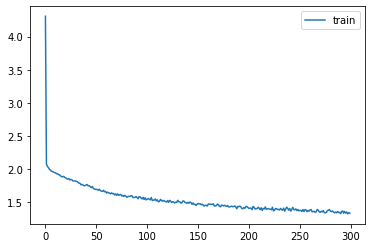

In [82]:
fit(m, c, s, i)

Model mlp
Number of classes 8
Number of steps 5
Number of indicators 11
              precision    recall  f1-score   support

          B3    0.76471   0.34211   0.47273        76
          B2    0.30233   0.13684   0.18841        95
          B1    0.33333   0.00833   0.01626       120
          B0    0.43750   0.03518   0.06512       199
          S0    0.26316   0.02646   0.04808       189
          S1    0.00000   0.00000   0.00000       125
          S2    0.33333   0.09489   0.14773       137
          S3    0.62500   0.25424   0.36145        59

   micro avg    0.44444   0.08000   0.13559      1000
   macro avg    0.38242   0.11225   0.16247      1000
weighted avg    0.34618   0.08000   0.11939      1000
 samples avg    0.08000   0.08000   0.08000      1000

Confusion matrix, without normalization
[[ 61  15   0   0   0   0   0   0]
 [ 79  13   1   1   0   1   0   0]
 [101  10   1   5   2   0   0   1]
 [184   4   1   7   3   0   0   0]
 [174   0   0   2   5   1   7   0]
 [106   

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


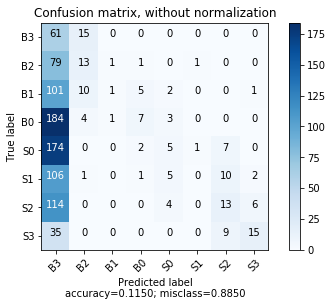

[3, 3, 2, 3, 4, 3, 2, 1, 3, 4, 5, 6, 4, 4, 4, 5, 4, 3, 4, 0, 0, 4, 1, 4, 4, 3, 3, 0, 4, 4, 3, 4, 4, 4, 1, 6, 1, 6, 3, 3, 6, 1, 4, 3, 3, 1, 6, 4, 7, 6, 6, 3, 4, 3, 6, 3, 4, 1, 4, 6, 5, 1, 3, 6, 6, 7, 6, 1, 6, 4, 4, 1, 1, 4, 3, 6, 6, 3, 1, 6, 3, 4, 4, 1, 4, 6, 6, 3, 3, 2, 1, 5, 3, 1, 4, 4, 6, 2, 3, 4, 1, 4, 1, 4, 6, 4, 3, 4, 6, 6, 6, 1, 6, 2, 4, 4, 6, 1, 4, 4, 6, 1, 1, 3, 3, 3, 5, 1, 1, 4, 1, 3, 3, 1, 3, 4, 3, 5, 6, 4, 4, 5, 5, 3, 3, 0, 3, 2, 1, 5, 1, 3, 4, 3, 2, 3, 6, 4, 4, 3, 4, 4, 1, 2, 3, 5, 4, 7, 5, 0, 4, 7, 6, 6, 6, 4, 4, 6, 6, 7, 1, 2, 5, 5, 1, 1, 3, 5, 1, 3, 4, 4, 4, 4, 5, 4, 4, 6, 7, 6, 1, 4, 1, 3, 3, 4, 7, 7, 2, 1, 3, 7, 0, 6, 4, 0, 1, 4, 1, 4, 3, 3, 4, 4, 5, 6, 0, 4, 5, 6, 4, 1, 3, 6, 3, 4, 3, 3, 4, 3, 3, 5, 4, 2, 6, 3, 2, 1, 4, 4, 6, 3, 6, 4, 0, 4, 3, 4, 3, 0, 0, 2, 3, 3, 3, 4, 3, 4, 4, 5, 6, 5, 3, 3, 7, 6, 1, 6, 0, 5, 0, 6, 4, 2, 4, 4, 5, 4, 3, 3, 7, 6, 2, 1, 1, 3, 5, 3, 6, 4, 1, 2, 4, 3, 3, 6, 7, 4, 4, 6, 3, 4, 6, 4, 3, 0, 3, 1, 1, 4, 4, 6, 1, 5, 5, 4, 6, 3, 5, 3, 4, 6, 4, 

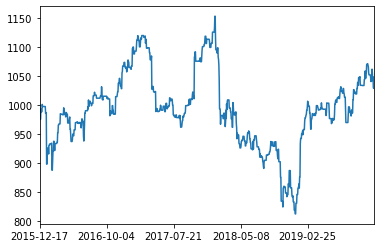

In [83]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3992/3992 [==============================] - 1s 211us/step - loss: 1.9952 - accuracy: 0.1926
Epoch 2/300
3992/3992 [==============================] - 0s 87us/step - loss: 1.9076 - accuracy: 0.2194
Epoch 3/300
3992/3992 [==============================] - 0s 90us/step - loss: 1.8458 - accuracy: 0.2412
Epoch 4/300
3992/3992 [==============================] - 0s 96us/step - loss: 1.8168 - accuracy: 0.2540
Epoch 5/300
3992/3992 [==============================] - 0s 102us/step - loss: 1.7899 - accuracy: 0.2540
Epoch 6/300
3992/3992 [==============================] - 0s 95us/step - loss: 1.7637 - accuracy: 0.2803
Epoch 7/300
3992/3992 [==============================] - 0s 101us/step - loss: 1.7569 - accuracy: 0.2796
Epoch 8/300
3992/3992 [==============================] - 0s 94us/step - loss: 1.7504 - accuracy: 0.2843
Epoch 9/300
3992/3992 [==============================] - 0s 92us/step - loss: 1.7429 - accuracy: 0.2853
Epoch 10/300
3992/3992 [==============================] - 0s 

3992/3992 [==============================] - 1s 135us/step - loss: 1.5727 - accuracy: 0.3560
Epoch 78/300
3992/3992 [==============================] - 1s 128us/step - loss: 1.5670 - accuracy: 0.3527
Epoch 79/300
3992/3992 [==============================] - 0s 117us/step - loss: 1.5720 - accuracy: 0.3582
Epoch 80/300
3992/3992 [==============================] - 1s 141us/step - loss: 1.5829 - accuracy: 0.3454
Epoch 81/300
3992/3992 [==============================] - 1s 131us/step - loss: 1.5660 - accuracy: 0.3662
Epoch 82/300
3992/3992 [==============================] - 0s 92us/step - loss: 1.5597 - accuracy: 0.3650
Epoch 83/300
3992/3992 [==============================] - 0s 91us/step - loss: 1.5543 - accuracy: 0.3758
Epoch 84/300
3992/3992 [==============================] - 1s 139us/step - loss: 1.5617 - accuracy: 0.3632
Epoch 85/300
3992/3992 [==============================] - 1s 141us/step - loss: 1.5531 - accuracy: 0.3627
Epoch 86/300
3992/3992 [==============================] - 1s 

3992/3992 [==============================] - 0s 87us/step - loss: 1.5072 - accuracy: 0.3780
Epoch 153/300
3992/3992 [==============================] - 0s 91us/step - loss: 1.5274 - accuracy: 0.3758
Epoch 154/300
3992/3992 [==============================] - 0s 100us/step - loss: 1.5217 - accuracy: 0.3815
Epoch 155/300
3992/3992 [==============================] - 0s 104us/step - loss: 1.5192 - accuracy: 0.3677
Epoch 156/300
3992/3992 [==============================] - 0s 119us/step - loss: 1.5261 - accuracy: 0.3730
Epoch 157/300
3992/3992 [==============================] - 0s 108us/step - loss: 1.5118 - accuracy: 0.3680
Epoch 158/300
3992/3992 [==============================] - 0s 100us/step - loss: 1.5137 - accuracy: 0.3695
Epoch 159/300
3992/3992 [==============================] - 0s 97us/step - loss: 1.5057 - accuracy: 0.3783
Epoch 160/300
3992/3992 [==============================] - 0s 90us/step - loss: 1.5163 - accuracy: 0.3737
Epoch 161/300
3992/3992 [==============================

3992/3992 [==============================] - 0s 74us/step - loss: 1.4945 - accuracy: 0.3790
Epoch 230/300
3992/3992 [==============================] - 0s 74us/step - loss: 1.4988 - accuracy: 0.3840
Epoch 231/300
3992/3992 [==============================] - 0s 82us/step - loss: 1.4874 - accuracy: 0.3870
Epoch 232/300
3992/3992 [==============================] - 0s 73us/step - loss: 1.4968 - accuracy: 0.3737
Epoch 233/300
3992/3992 [==============================] - 0s 73us/step - loss: 1.4953 - accuracy: 0.3770
Epoch 234/300
3992/3992 [==============================] - 0s 74us/step - loss: 1.4971 - accuracy: 0.3848
Epoch 235/300
3992/3992 [==============================] - 0s 74us/step - loss: 1.4992 - accuracy: 0.3828
Epoch 236/300
3992/3992 [==============================] - 0s 80us/step - loss: 1.4870 - accuracy: 0.3820
Epoch 237/300
3992/3992 [==============================] - 0s 70us/step - loss: 1.4914 - accuracy: 0.3770
Epoch 238/300
3992/3992 [==============================] - 0

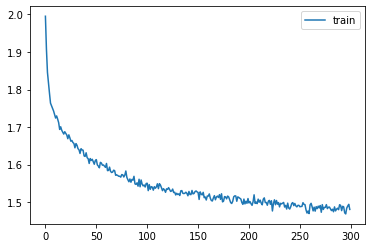

In [84]:
fit(m, c, s, i)

Model mlp
Number of classes 8
Number of steps 10
Number of indicators 3
              precision    recall  f1-score   support

          B3    0.75000   0.41538   0.53465        65
          B2    0.42857   0.05714   0.10084       105
          B1    0.00000   0.00000   0.00000       125
          B0    0.00000   0.00000   0.00000       176
          S0    0.00000   0.00000   0.00000       169
          S1    0.00000   0.00000   0.00000       148
          S2    0.00000   0.00000   0.00000       143
          S3    0.94737   0.26471   0.41379        68

   micro avg    0.71831   0.05105   0.09533       999
   macro avg    0.26574   0.09215   0.13116       999
weighted avg    0.15833   0.05105   0.07355       999
 samples avg    0.05105   0.05105   0.05105       999

Confusion matrix, without normalization
[[ 61   4   0   0   0   0   0   0]
 [ 98   6   0   1   0   0   0   0]
 [122   3   0   0   0   0   0   0]
 [175   1   0   0   0   0   0   0]
 [169   0   0   0   0   0   0   0]
 [148   

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


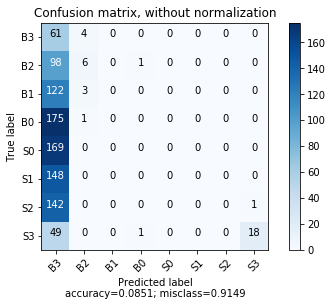

[1, 0, 5, 6, 4, 5, 4, 3, 2, 4, 6, 4, 4, 0, 1, 1, 4, 3, 0, 1, 4, 1, 6, 3, 3, 3, 4, 6, 4, 3, 1, 4, 4, 3, 4, 3, 4, 1, 4, 0, 1, 4, 1, 0, 1, 4, 4, 4, 4, 3, 2, 5, 4, 3, 1, 6, 6, 1, 5, 1, 6, 0, 4, 4, 6, 1, 5, 6, 5, 5, 3, 3, 4, 1, 6, 3, 3, 4, 0, 6, 0, 3, 3, 4, 4, 1, 1, 4, 6, 5, 6, 4, 4, 4, 3, 6, 4, 3, 3, 0, 6, 4, 4, 6, 5, 5, 7, 4, 3, 1, 3, 1, 6, 3, 1, 6, 4, 3, 4, 7, 6, 2, 1, 5, 1, 4, 4, 5, 1, 6, 7, 5, 4, 5, 6, 5, 6, 0, 6, 1, 1, 3, 0, 2, 1, 3, 5, 3, 1, 6, 0, 5, 6, 4, 1, 5, 1, 1, 4, 6, 4, 5, 4, 0, 4, 4, 5, 1, 4, 7, 5, 1, 3, 0, 5, 6, 7, 1, 1, 0, 5, 4, 4, 4, 0, 4, 6, 4, 4, 1, 1, 4, 3, 6, 3, 6, 7, 4, 2, 3, 4, 1, 3, 4, 1, 3, 3, 6, 1, 7, 4, 4, 3, 5, 6, 4, 7, 3, 5, 4, 1, 1, 1, 3, 6, 3, 1, 3, 5, 5, 1, 4, 6, 4, 3, 6, 3, 6, 5, 1, 1, 4, 2, 5, 3, 3, 1, 1, 4, 1, 2, 4, 4, 4, 1, 4, 4, 4, 1, 1, 6, 3, 1, 1, 4, 1, 4, 2, 4, 4, 5, 1, 4, 4, 1, 4, 3, 4, 3, 3, 6, 6, 3, 1, 6, 1, 5, 4, 7, 4, 0, 4, 3, 3, 1, 5, 6, 1, 6, 1, 4, 0, 1, 0, 4, 1, 4, 4, 7, 3, 3, 4, 6, 3, 5, 0, 6, 7, 1, 4, 3, 2, 3, 4, 1, 3, 4, 4, 2, 5, 4, 3, 1, 

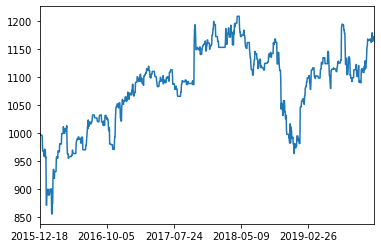

In [85]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3992/3992 [==============================] - 1s 186us/step - loss: 2.0229 - accuracy: 0.1774
Epoch 2/300
3992/3992 [==============================] - 0s 89us/step - loss: 1.9346 - accuracy: 0.2047
Epoch 3/300
3992/3992 [==============================] - 0s 91us/step - loss: 1.8571 - accuracy: 0.2332
Epoch 4/300
3992/3992 [==============================] - 0s 89us/step - loss: 1.8148 - accuracy: 0.2560
Epoch 5/300
3992/3992 [==============================] - 0s 87us/step - loss: 1.7598 - accuracy: 0.2638
Epoch 6/300
3992/3992 [==============================] - 0s 89us/step - loss: 1.7375 - accuracy: 0.2888
Epoch 7/300
3992/3992 [==============================] - 0s 95us/step - loss: 1.7055 - accuracy: 0.2831
Epoch 8/300
3992/3992 [==============================] - 0s 91us/step - loss: 1.6662 - accuracy: 0.3036
Epoch 9/300
3992/3992 [==============================] - 0s 94us/step - loss: 1.6554 - accuracy: 0.3069
Epoch 10/300
3992/3992 [==============================] - 0s 94

3992/3992 [==============================] - 0s 84us/step - loss: 1.0584 - accuracy: 0.5356
Epoch 80/300
3992/3992 [==============================] - 0s 89us/step - loss: 1.0730 - accuracy: 0.5348
Epoch 81/300
3992/3992 [==============================] - 0s 90us/step - loss: 1.0319 - accuracy: 0.5529
Epoch 82/300
3992/3992 [==============================] - 0s 89us/step - loss: 1.0302 - accuracy: 0.5604
Epoch 83/300
3992/3992 [==============================] - 0s 90us/step - loss: 1.0346 - accuracy: 0.5614
Epoch 84/300
3992/3992 [==============================] - 0s 90us/step - loss: 1.0305 - accuracy: 0.5549
Epoch 85/300
3992/3992 [==============================] - 0s 91us/step - loss: 1.0307 - accuracy: 0.5689
Epoch 86/300
3992/3992 [==============================] - 0s 87us/step - loss: 1.0114 - accuracy: 0.5664
Epoch 87/300
3992/3992 [==============================] - 0s 89us/step - loss: 1.0267 - accuracy: 0.5519
Epoch 88/300
3992/3992 [==============================] - 0s 87us/st

3992/3992 [==============================] - 0s 94us/step - loss: 0.9183 - accuracy: 0.6197
Epoch 157/300
3992/3992 [==============================] - 0s 97us/step - loss: 0.8983 - accuracy: 0.6180
Epoch 158/300
3992/3992 [==============================] - 0s 95us/step - loss: 0.9242 - accuracy: 0.6162
Epoch 159/300
3992/3992 [==============================] - 0s 101us/step - loss: 0.9356 - accuracy: 0.5984
Epoch 160/300
3992/3992 [==============================] - 0s 101us/step - loss: 0.8940 - accuracy: 0.6232
Epoch 161/300
3992/3992 [==============================] - 0s 98us/step - loss: 0.8780 - accuracy: 0.6250
Epoch 162/300
3992/3992 [==============================] - 0s 93us/step - loss: 0.9006 - accuracy: 0.6142
Epoch 163/300
3992/3992 [==============================] - 0s 94us/step - loss: 0.9259 - accuracy: 0.6065
Epoch 164/300
3992/3992 [==============================] - 0s 93us/step - loss: 0.8958 - accuracy: 0.6150
Epoch 165/300
3992/3992 [==============================] -

3992/3992 [==============================] - 0s 85us/step - loss: 0.8724 - accuracy: 0.6323
Epoch 234/300
3992/3992 [==============================] - 0s 83us/step - loss: 0.8737 - accuracy: 0.6212
Epoch 235/300
3992/3992 [==============================] - 0s 84us/step - loss: 0.8684 - accuracy: 0.6370
Epoch 236/300
3992/3992 [==============================] - 0s 90us/step - loss: 0.9108 - accuracy: 0.6130
Epoch 237/300
3992/3992 [==============================] - 0s 84us/step - loss: 0.9004 - accuracy: 0.6155
Epoch 238/300
3992/3992 [==============================] - 0s 81us/step - loss: 0.8654 - accuracy: 0.6350
Epoch 239/300
3992/3992 [==============================] - 0s 85us/step - loss: 0.8854 - accuracy: 0.6165
Epoch 240/300
3992/3992 [==============================] - 0s 83us/step - loss: 0.8994 - accuracy: 0.6132
Epoch 241/300
3992/3992 [==============================] - 0s 87us/step - loss: 0.8682 - accuracy: 0.6273
Epoch 242/300
3992/3992 [==============================] - 0

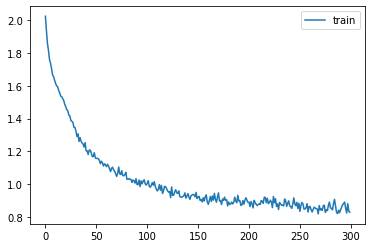

In [86]:
fit(m, c, s, i)

Model mlp
Number of classes 8
Number of steps 10
Number of indicators 6
              precision    recall  f1-score   support

          B3    0.80435   0.56923   0.66667        65
          B2    0.58511   0.52381   0.55276       105
          B1    0.68269   0.56800   0.62009       125
          B0    0.81287   0.78977   0.80115       176
          S0    0.69149   0.76923   0.72829       169
          S1    0.67532   0.35135   0.46222       148
          S2    0.76800   0.67133   0.71642       143
          S3    0.88636   0.57353   0.69643        68

   micro avg    0.72909   0.61962   0.66991       999
   macro avg    0.73827   0.60203   0.65550       999
weighted avg    0.72976   0.61962   0.66184       999
 samples avg    0.61962   0.61962   0.61962       999

Confusion matrix, without normalization
[[ 44  21   0   0   0   0   0   0]
 [ 28  55  22   0   0   0   0   0]
 [ 30  18  71   6   0   0   0   0]
 [ 24   0  11 139   2   0   0   0]
 [ 10   0   0  26 130   3   0   0]
 [ 30   

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


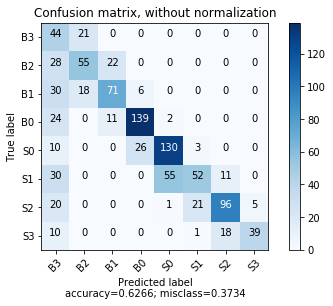

[2, 0, 2, 2, 3, 5, 3, 3, 3, 4, 5, 5, 2, 5, 1, 1, 4, 2, 1, 2, 3, 1, 6, 2, 3, 1, 4, 6, 4, 1, 3, 5, 5, 4, 2, 4, 5, 1, 4, 0, 2, 3, 2, 0, 2, 4, 5, 4, 4, 3, 3, 6, 4, 6, 1, 6, 6, 0, 5, 1, 6, 0, 4, 3, 6, 1, 4, 4, 7, 4, 2, 1, 4, 1, 6, 3, 4, 4, 3, 6, 0, 3, 3, 3, 2, 1, 1, 3, 6, 5, 5, 6, 4, 1, 2, 5, 6, 3, 7, 0, 6, 4, 5, 6, 4, 4, 6, 4, 4, 2, 3, 3, 6, 3, 2, 6, 6, 4, 2, 7, 6, 2, 4, 6, 1, 2, 3, 4, 2, 6, 3, 5, 3, 3, 5, 4, 7, 1, 5, 7, 2, 2, 1, 1, 1, 4, 4, 3, 2, 4, 0, 5, 6, 4, 1, 3, 2, 0, 3, 4, 6, 6, 7, 1, 4, 4, 4, 1, 5, 6, 5, 1, 5, 3, 5, 6, 6, 1, 0, 0, 6, 4, 5, 4, 0, 4, 5, 6, 4, 2, 2, 3, 1, 6, 3, 6, 7, 2, 2, 4, 6, 0, 2, 4, 4, 2, 3, 2, 3, 7, 4, 4, 4, 4, 5, 4, 7, 5, 6, 4, 2, 2, 0, 4, 6, 2, 2, 3, 5, 5, 2, 4, 4, 3, 3, 5, 2, 4, 5, 3, 1, 6, 1, 3, 3, 2, 4, 2, 3, 2, 3, 0, 2, 4, 0, 5, 4, 5, 2, 1, 6, 3, 3, 3, 4, 2, 4, 1, 4, 4, 5, 1, 4, 2, 1, 5, 3, 3, 4, 3, 3, 6, 4, 1, 6, 4, 6, 3, 7, 4, 1, 4, 2, 3, 5, 6, 6, 1, 6, 2, 5, 3, 2, 0, 4, 2, 4, 5, 7, 4, 2, 5, 6, 3, 3, 0, 6, 7, 2, 3, 2, 1, 3, 4, 2, 4, 4, 6, 2, 6, 3, 3, 4, 

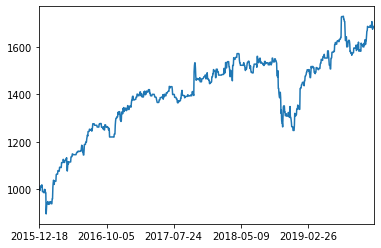

In [87]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3992/3992 [==============================] - 1s 241us/step - loss: 1.9381 - accuracy: 0.2182
Epoch 2/300
3992/3992 [==============================] - 0s 124us/step - loss: 1.8069 - accuracy: 0.2520
Epoch 3/300
3992/3992 [==============================] - 0s 120us/step - loss: 1.7621 - accuracy: 0.2748
Epoch 4/300
3992/3992 [==============================] - 0s 117us/step - loss: 1.7441 - accuracy: 0.2730
Epoch 5/300
3992/3992 [==============================] - 1s 126us/step - loss: 1.7170 - accuracy: 0.2883
Epoch 6/300
3992/3992 [==============================] - 1s 130us/step - loss: 1.6986 - accuracy: 0.2938
Epoch 7/300
3992/3992 [==============================] - 0s 125us/step - loss: 1.6837 - accuracy: 0.2991
Epoch 8/300
3992/3992 [==============================] - 1s 144us/step - loss: 1.6616 - accuracy: 0.3116
Epoch 9/300
3992/3992 [==============================] - 0s 116us/step - loss: 1.6586 - accuracy: 0.3101
Epoch 10/300
3992/3992 [==============================]

3992/3992 [==============================] - 0s 115us/step - loss: 1.0470 - accuracy: 0.5641
Epoch 79/300
3992/3992 [==============================] - 1s 142us/step - loss: 1.0529 - accuracy: 0.5443
Epoch 80/300
3992/3992 [==============================] - 0s 115us/step - loss: 1.0426 - accuracy: 0.5554
Epoch 81/300
3992/3992 [==============================] - 0s 116us/step - loss: 1.0526 - accuracy: 0.5509
Epoch 82/300
3992/3992 [==============================] - 0s 114us/step - loss: 1.0469 - accuracy: 0.5534
Epoch 83/300
3992/3992 [==============================] - 0s 121us/step - loss: 1.0484 - accuracy: 0.5549
Epoch 84/300
3992/3992 [==============================] - 0s 120us/step - loss: 1.0428 - accuracy: 0.5599
Epoch 85/300
3992/3992 [==============================] - 0s 120us/step - loss: 1.0339 - accuracy: 0.5506
Epoch 86/300
3992/3992 [==============================] - 0s 123us/step - loss: 1.0380 - accuracy: 0.5591
Epoch 87/300
3992/3992 [==============================] - 1

Epoch 155/300
3992/3992 [==============================] - 1s 137us/step - loss: 0.8794 - accuracy: 0.6270
Epoch 156/300
3992/3992 [==============================] - 1s 137us/step - loss: 0.8846 - accuracy: 0.6323
Epoch 157/300
3992/3992 [==============================] - 1s 199us/step - loss: 0.8950 - accuracy: 0.6275
Epoch 158/300
3992/3992 [==============================] - 1s 129us/step - loss: 0.9181 - accuracy: 0.6132
Epoch 159/300
3992/3992 [==============================] - 0s 119us/step - loss: 0.8674 - accuracy: 0.6250
Epoch 160/300
3992/3992 [==============================] - 1s 126us/step - loss: 0.8788 - accuracy: 0.6240
Epoch 161/300
3992/3992 [==============================] - 0s 120us/step - loss: 0.8872 - accuracy: 0.6273
Epoch 162/300
3992/3992 [==============================] - 1s 146us/step - loss: 0.8724 - accuracy: 0.6242
Epoch 163/300
3992/3992 [==============================] - 1s 145us/step - loss: 0.8549 - accuracy: 0.6323
Epoch 164/300
3992/3992 [============

3992/3992 [==============================] - 1s 126us/step - loss: 0.8555 - accuracy: 0.6480
Epoch 232/300
3992/3992 [==============================] - 0s 121us/step - loss: 0.8079 - accuracy: 0.6551
Epoch 233/300
3992/3992 [==============================] - 0s 125us/step - loss: 0.8050 - accuracy: 0.6626
Epoch 234/300
3992/3992 [==============================] - 0s 119us/step - loss: 0.7926 - accuracy: 0.6718
Epoch 235/300
3992/3992 [==============================] - 0s 97us/step - loss: 0.7941 - accuracy: 0.6711
Epoch 236/300
3992/3992 [==============================] - 0s 98us/step - loss: 0.8173 - accuracy: 0.6536
Epoch 237/300
3992/3992 [==============================] - 0s 95us/step - loss: 0.8323 - accuracy: 0.6473
Epoch 238/300
3992/3992 [==============================] - 0s 98us/step - loss: 0.8104 - accuracy: 0.6621
Epoch 239/300
3992/3992 [==============================] - 0s 95us/step - loss: 0.8152 - accuracy: 0.6578
Epoch 240/300
3992/3992 [==============================]

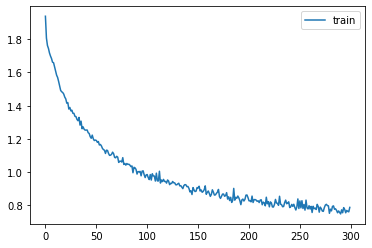

In [88]:
fit(m, c, s, i)

Model mlp
Number of classes 8
Number of steps 10
Number of indicators 8
              precision    recall  f1-score   support

          B3    0.73529   0.76923   0.75188        65
          B2    0.56701   0.52381   0.54455       105
          B1    0.54955   0.48800   0.51695       125
          B0    0.69643   0.66477   0.68023       176
          S0    0.58462   0.67456   0.62637       169
          S1    0.45205   0.22297   0.29864       148
          S2    0.66019   0.47552   0.55285       143
          S3    0.77778   0.51471   0.61947        68

   micro avg    0.61977   0.53353   0.57343       999
   macro avg    0.62787   0.54170   0.57387       999
weighted avg    0.61221   0.53353   0.56219       999
 samples avg    0.53353   0.53353   0.53353       999

Confusion matrix, without normalization
[[ 54  11   0   0   0   0   0   0]
 [ 29  55  20   1   0   0   0   0]
 [ 26  30  61   8   0   0   0   0]
 [ 26   1  29 117   3   0   0   0]
 [ 13   0   1  39 114   2   0   0]
 [ 22   

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


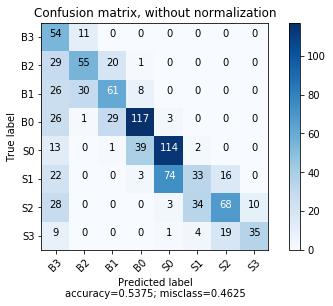

[1, 0, 2, 3, 3, 4, 2, 2, 3, 4, 4, 5, 2, 4, 1, 0, 4, 2, 0, 2, 3, 1, 6, 2, 3, 2, 4, 5, 4, 1, 2, 4, 6, 4, 2, 4, 4, 0, 4, 0, 2, 2, 1, 0, 1, 4, 4, 4, 4, 2, 3, 5, 4, 6, 1, 6, 6, 0, 5, 1, 6, 0, 3, 2, 6, 0, 4, 5, 7, 4, 2, 2, 4, 0, 5, 3, 4, 4, 3, 6, 0, 3, 2, 3, 2, 1, 1, 3, 7, 4, 6, 4, 3, 1, 2, 5, 5, 3, 6, 0, 6, 4, 6, 6, 4, 4, 6, 4, 4, 2, 3, 2, 6, 2, 1, 6, 6, 4, 2, 6, 7, 2, 4, 6, 1, 3, 2, 4, 1, 6, 2, 5, 3, 3, 4, 4, 7, 0, 4, 6, 2, 2, 0, 1, 1, 3, 5, 2, 2, 4, 0, 5, 6, 4, 1, 4, 2, 0, 3, 4, 6, 6, 7, 2, 4, 4, 4, 0, 4, 7, 5, 1, 6, 2, 4, 6, 6, 1, 0, 0, 6, 4, 4, 3, 0, 4, 5, 6, 4, 1, 2, 3, 1, 6, 4, 5, 7, 2, 2, 4, 6, 0, 2, 4, 6, 2, 3, 3, 2, 7, 4, 4, 3, 4, 5, 4, 7, 5, 6, 4, 1, 1, 0, 4, 6, 2, 2, 2, 4, 5, 2, 4, 4, 3, 3, 5, 1, 4, 5, 2, 1, 6, 1, 3, 2, 2, 4, 2, 3, 1, 2, 2, 2, 4, 0, 5, 4, 5, 1, 0, 6, 3, 2, 2, 4, 2, 4, 1, 4, 3, 5, 1, 4, 2, 1, 5, 3, 2, 4, 3, 4, 6, 4, 1, 5, 4, 6, 3, 4, 3, 1, 4, 1, 3, 4, 6, 6, 1, 6, 1, 4, 4, 1, 0, 4, 2, 4, 5, 7, 4, 2, 5, 5, 3, 3, 0, 6, 7, 1, 3, 2, 1, 3, 4, 2, 4, 4, 6, 2, 5, 3, 3, 4, 

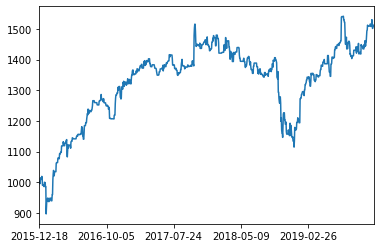

In [89]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3992/3992 [==============================] - 1s 281us/step - loss: 5.0339 - accuracy: 0.1658
Epoch 2/300
3992/3992 [==============================] - 1s 151us/step - loss: 2.0549 - accuracy: 0.1809
Epoch 3/300
3992/3992 [==============================] - 1s 139us/step - loss: 2.0223 - accuracy: 0.1904
Epoch 4/300
3992/3992 [==============================] - 1s 142us/step - loss: 2.0122 - accuracy: 0.1969
Epoch 5/300
3992/3992 [==============================] - 1s 141us/step - loss: 2.0061 - accuracy: 0.1991
Epoch 6/300
3992/3992 [==============================] - 1s 141us/step - loss: 2.0081 - accuracy: 0.2019
Epoch 7/300
3992/3992 [==============================] - 1s 151us/step - loss: 1.9844 - accuracy: 0.1994
Epoch 8/300
3992/3992 [==============================] - 1s 134us/step - loss: 1.9754 - accuracy: 0.2032
Epoch 9/300
3992/3992 [==============================] - 1s 142us/step - loss: 1.9567 - accuracy: 0.2037
Epoch 10/300
3992/3992 [==============================]

3992/3992 [==============================] - 1s 146us/step - loss: 1.6583 - accuracy: 0.3262
Epoch 78/300
3992/3992 [==============================] - 1s 147us/step - loss: 1.6594 - accuracy: 0.3209
Epoch 79/300
3992/3992 [==============================] - 1s 142us/step - loss: 1.6460 - accuracy: 0.3359
Epoch 80/300
3992/3992 [==============================] - 1s 139us/step - loss: 1.6441 - accuracy: 0.3374
Epoch 81/300
3992/3992 [==============================] - 1s 138us/step - loss: 1.6499 - accuracy: 0.3339
Epoch 82/300
3992/3992 [==============================] - 1s 134us/step - loss: 1.6401 - accuracy: 0.3352
Epoch 83/300
3992/3992 [==============================] - 1s 148us/step - loss: 1.6283 - accuracy: 0.3337
Epoch 84/300
3992/3992 [==============================] - 1s 178us/step - loss: 1.6355 - accuracy: 0.3429
Epoch 85/300
3992/3992 [==============================] - 1s 163us/step - loss: 1.6288 - accuracy: 0.3492
Epoch 86/300
3992/3992 [==============================] - 1

3992/3992 [==============================] - 1s 142us/step - loss: 1.4472 - accuracy: 0.4254
Epoch 154/300
3992/3992 [==============================] - 1s 150us/step - loss: 1.4432 - accuracy: 0.4269
Epoch 155/300
3992/3992 [==============================] - 1s 156us/step - loss: 1.4371 - accuracy: 0.4254
Epoch 156/300
3992/3992 [==============================] - 1s 149us/step - loss: 1.4608 - accuracy: 0.4173
Epoch 157/300
3992/3992 [==============================] - 1s 148us/step - loss: 1.4304 - accuracy: 0.4326
Epoch 158/300
3992/3992 [==============================] - 1s 146us/step - loss: 1.4297 - accuracy: 0.4256
Epoch 159/300
3992/3992 [==============================] - 1s 151us/step - loss: 1.4216 - accuracy: 0.4296
Epoch 160/300
3992/3992 [==============================] - 1s 147us/step - loss: 1.4387 - accuracy: 0.4279
Epoch 161/300
3992/3992 [==============================] - 1s 155us/step - loss: 1.4579 - accuracy: 0.4304
Epoch 162/300
3992/3992 [==========================

3992/3992 [==============================] - 1s 142us/step - loss: 1.3319 - accuracy: 0.4727
Epoch 230/300
3992/3992 [==============================] - 1s 142us/step - loss: 1.3489 - accuracy: 0.4652
Epoch 231/300
3992/3992 [==============================] - 1s 144us/step - loss: 1.3300 - accuracy: 0.4654
Epoch 232/300
3992/3992 [==============================] - 1s 143us/step - loss: 1.3205 - accuracy: 0.4724
Epoch 233/300
3992/3992 [==============================] - 1s 147us/step - loss: 1.3286 - accuracy: 0.4659
Epoch 234/300
3992/3992 [==============================] - 1s 150us/step - loss: 1.3149 - accuracy: 0.4832
Epoch 235/300
3992/3992 [==============================] - 1s 144us/step - loss: 1.3385 - accuracy: 0.4659
Epoch 236/300
3992/3992 [==============================] - 1s 141us/step - loss: 1.3152 - accuracy: 0.4770
Epoch 237/300
3992/3992 [==============================] - 1s 141us/step - loss: 1.3296 - accuracy: 0.4767
Epoch 238/300
3992/3992 [==========================

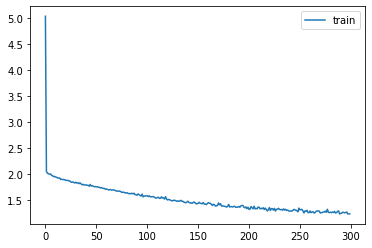

In [90]:
fit(m, c, s, i)

Model mlp
Number of classes 8
Number of steps 10
Number of indicators 11
              precision    recall  f1-score   support

          B3    0.50000   0.41538   0.45378        65
          B2    0.29032   0.08571   0.13235       105
          B1    0.13514   0.04000   0.06173       125
          B0    0.32653   0.09091   0.14222       176
          S0    0.15385   0.03550   0.05769       169
          S1    0.34483   0.06757   0.11299       148
          S2    0.36842   0.09790   0.15470       143
          S3    0.73913   0.25000   0.37363        68

   micro avg    0.34667   0.10410   0.16012       999
   macro avg    0.35728   0.13537   0.18614       999
weighted avg    0.31764   0.10410   0.15029       999
 samples avg    0.10410   0.10410   0.10410       999

Confusion matrix, without normalization
[[ 48   6   7   3   0   1   0   0]
 [ 79   9   6   8   1   1   0   1]
 [ 94   9   5   8   5   3   1   0]
 [139   5   9  16   2   3   2   0]
 [139   2   4   7   6   3   5   3]
 [117  

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


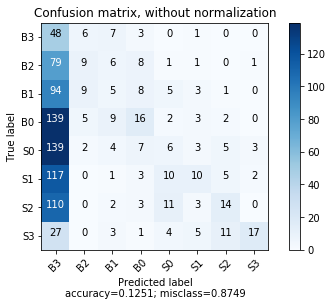

[3, 1, 3, 4, 3, 2, 4, 3, 4, 1, 3, 3, 3, 1, 0, 3, 3, 3, 0, 2, 3, 2, 6, 2, 3, 3, 4, 4, 6, 0, 6, 3, 4, 3, 3, 0, 4, 0, 3, 1, 3, 5, 4, 0, 0, 7, 4, 4, 4, 3, 3, 3, 4, 6, 3, 6, 7, 0, 3, 0, 3, 0, 3, 5, 4, 1, 4, 6, 3, 3, 3, 2, 3, 2, 4, 3, 3, 5, 3, 4, 2, 3, 4, 3, 3, 0, 2, 3, 2, 1, 3, 3, 5, 0, 3, 3, 5, 3, 5, 1, 4, 3, 4, 7, 4, 4, 4, 3, 3, 3, 3, 2, 4, 4, 1, 6, 6, 3, 3, 6, 3, 3, 5, 4, 2, 6, 3, 3, 1, 6, 7, 4, 4, 3, 3, 3, 6, 2, 4, 4, 3, 3, 2, 3, 2, 2, 3, 3, 3, 3, 0, 4, 4, 4, 3, 2, 2, 0, 4, 4, 4, 3, 4, 1, 3, 3, 5, 0, 6, 7, 5, 3, 4, 3, 3, 4, 6, 3, 2, 0, 3, 4, 4, 3, 0, 3, 7, 6, 5, 1, 1, 5, 2, 4, 6, 2, 7, 4, 3, 4, 4, 0, 3, 3, 1, 3, 0, 5, 1, 7, 3, 4, 3, 3, 6, 3, 7, 3, 6, 3, 1, 5, 3, 3, 4, 3, 6, 4, 4, 7, 1, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 4, 3, 3, 3, 3, 1, 4, 4, 2, 3, 4, 3, 3, 0, 3, 3, 6, 3, 2, 3, 4, 2, 1, 3, 3, 4, 3, 4, 3, 4, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 6, 2, 3, 6, 3, 7, 3, 4, 4, 2, 3, 3, 3, 3, 5, 6, 3, 6, 3, 4, 1, 3, 0, 6, 3, 4, 2, 5, 3, 3, 3, 6, 3, 3, 1, 3, 6, 3, 3, 3, 1, 3, 3, 3, 3, 5, 3, 1, 3, 3, 3, 1, 

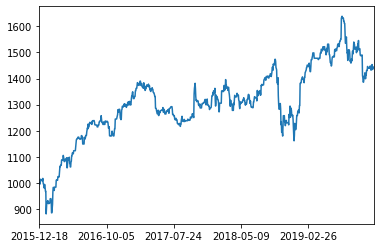

In [91]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3999/3999 [==============================] - 4s 886us/step - loss: 0.6660 - accuracy: 0.5934
Epoch 2/300
3999/3999 [==============================] - 1s 213us/step - loss: 0.6512 - accuracy: 0.6169
Epoch 3/300
3999/3999 [==============================] - 1s 234us/step - loss: 0.6494 - accuracy: 0.6219
Epoch 4/300
3999/3999 [==============================] - 1s 227us/step - loss: 0.6446 - accuracy: 0.6244
Epoch 5/300
3999/3999 [==============================] - 1s 229us/step - loss: 0.6407 - accuracy: 0.6302
Epoch 6/300
3999/3999 [==============================] - 1s 230us/step - loss: 0.6366 - accuracy: 0.6357
Epoch 7/300
3999/3999 [==============================] - 1s 231us/step - loss: 0.6314 - accuracy: 0.6409
Epoch 8/300
3999/3999 [==============================] - 1s 236us/step - loss: 0.6261 - accuracy: 0.6512
Epoch 9/300
3999/3999 [==============================] - 1s 223us/step - loss: 0.6221 - accuracy: 0.6504
Epoch 10/300
3999/3999 [==============================]

3999/3999 [==============================] - 1s 177us/step - loss: 0.5191 - accuracy: 0.7567
Epoch 79/300
3999/3999 [==============================] - 1s 194us/step - loss: 0.5190 - accuracy: 0.7514
Epoch 80/300
3999/3999 [==============================] - 1s 204us/step - loss: 0.5191 - accuracy: 0.7542
Epoch 81/300
3999/3999 [==============================] - 1s 215us/step - loss: 0.5212 - accuracy: 0.7562
Epoch 82/300
3999/3999 [==============================] - 1s 198us/step - loss: 0.5195 - accuracy: 0.7547
Epoch 83/300
3999/3999 [==============================] - 1s 194us/step - loss: 0.5192 - accuracy: 0.7524
Epoch 84/300
3999/3999 [==============================] - 1s 187us/step - loss: 0.5173 - accuracy: 0.7599
Epoch 85/300
3999/3999 [==============================] - 1s 181us/step - loss: 0.5202 - accuracy: 0.7547
Epoch 86/300
3999/3999 [==============================] - 1s 182us/step - loss: 0.5188 - accuracy: 0.7547
Epoch 87/300
3999/3999 [==============================] - 1

3999/3999 [==============================] - 1s 317us/step - loss: 0.5150 - accuracy: 0.7537
Epoch 155/300
3999/3999 [==============================] - 1s 231us/step - loss: 0.5172 - accuracy: 0.7594
Epoch 156/300
3999/3999 [==============================] - 1s 212us/step - loss: 0.5162 - accuracy: 0.7562
Epoch 157/300
3999/3999 [==============================] - 1s 298us/step - loss: 0.5161 - accuracy: 0.7609
Epoch 158/300
3999/3999 [==============================] - 1s 329us/step - loss: 0.5148 - accuracy: 0.7592
Epoch 159/300
3999/3999 [==============================] - 1s 353us/step - loss: 0.5169 - accuracy: 0.7557
Epoch 160/300
3999/3999 [==============================] - 2s 438us/step - loss: 0.5140 - accuracy: 0.75790s - loss: 0.5159 - accuracy: 
Epoch 161/300
3999/3999 [==============================] - 2s 486us/step - loss: 0.5153 - accuracy: 0.7549
Epoch 162/300
3999/3999 [==============================] - 2s 487us/step - loss: 0.5141 - accuracy: 0.7607
Epoch 163/300
3999/39

3999/3999 [==============================] - 1s 293us/step - loss: 0.5111 - accuracy: 0.7617
Epoch 231/300
3999/3999 [==============================] - 1s 258us/step - loss: 0.5130 - accuracy: 0.7617
Epoch 232/300
3999/3999 [==============================] - 1s 234us/step - loss: 0.5124 - accuracy: 0.7569
Epoch 233/300
3999/3999 [==============================] - 1s 251us/step - loss: 0.5139 - accuracy: 0.7574
Epoch 234/300
3999/3999 [==============================] - 1s 225us/step - loss: 0.5136 - accuracy: 0.7559
Epoch 235/300
3999/3999 [==============================] - 1s 219us/step - loss: 0.5109 - accuracy: 0.7607
Epoch 236/300
3999/3999 [==============================] - 1s 331us/step - loss: 0.5112 - accuracy: 0.7629
Epoch 237/300
3999/3999 [==============================] - 1s 297us/step - loss: 0.5132 - accuracy: 0.7602
Epoch 238/300
3999/3999 [==============================] - 1s 268us/step - loss: 0.5116 - accuracy: 0.7599
Epoch 239/300
3999/3999 [==========================

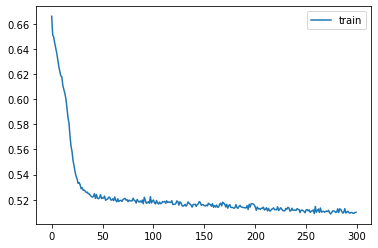

In [92]:
fit(m, c, s, i)

Model lstm
Number of classes 2
Number of steps 2
Number of indicators 3
              precision    recall  f1-score   support

           S    0.71885   0.88583   0.79365       508
           B    0.84492   0.64228   0.72979       492

    accuracy                        0.76600      1000
   macro avg    0.78188   0.76405   0.76172      1000
weighted avg    0.78088   0.76600   0.76223      1000

Confusion matrix, without normalization
[[450  58]
 [176 316]]


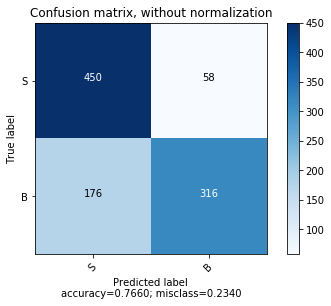

[0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 

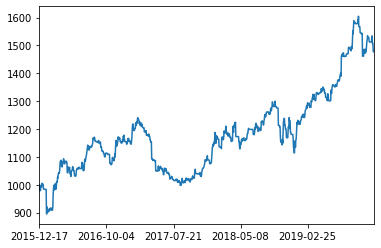

In [93]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3999/3999 [==============================] - 5s 1ms/step - loss: 0.6532 - accuracy: 0.6177
Epoch 2/300
3999/3999 [==============================] - 1s 232us/step - loss: 0.6317 - accuracy: 0.6514
Epoch 3/300
3999/3999 [==============================] - 1s 235us/step - loss: 0.5938 - accuracy: 0.6864
Epoch 4/300
3999/3999 [==============================] - 1s 232us/step - loss: 0.5364 - accuracy: 0.7354
Epoch 5/300
3999/3999 [==============================] - 1s 231us/step - loss: 0.4725 - accuracy: 0.7862
Epoch 6/300
3999/3999 [==============================] - 1s 329us/step - loss: 0.4076 - accuracy: 0.8432
Epoch 7/300
3999/3999 [==============================] - 1s 239us/step - loss: 0.3586 - accuracy: 0.8700
Epoch 8/300
3999/3999 [==============================] - 1s 242us/step - loss: 0.3197 - accuracy: 0.8910
Epoch 9/300
3999/3999 [==============================] - 1s 237us/step - loss: 0.3062 - accuracy: 0.8887
Epoch 10/300
3999/3999 [==============================] -

3999/3999 [==============================] - 1s 206us/step - loss: 0.0746 - accuracy: 0.9737
Epoch 79/300
3999/3999 [==============================] - 1s 254us/step - loss: 0.0795 - accuracy: 0.9715
Epoch 80/300
3999/3999 [==============================] - 1s 275us/step - loss: 0.0715 - accuracy: 0.9795
Epoch 81/300
3999/3999 [==============================] - 1s 227us/step - loss: 0.0708 - accuracy: 0.9787
Epoch 82/300
3999/3999 [==============================] - 1s 221us/step - loss: 0.0689 - accuracy: 0.9785
Epoch 83/300
3999/3999 [==============================] - 1s 207us/step - loss: 0.0673 - accuracy: 0.9797
Epoch 84/300
3999/3999 [==============================] - 1s 220us/step - loss: 0.0694 - accuracy: 0.9805
Epoch 85/300
3999/3999 [==============================] - 1s 309us/step - loss: 0.0659 - accuracy: 0.9835
Epoch 86/300
3999/3999 [==============================] - 1s 269us/step - loss: 0.0683 - accuracy: 0.9790
Epoch 87/300
3999/3999 [==============================] - 1

3999/3999 [==============================] - 1s 337us/step - loss: 0.0457 - accuracy: 0.9877
Epoch 155/300
3999/3999 [==============================] - 2s 407us/step - loss: 0.0473 - accuracy: 0.9865
Epoch 156/300
3999/3999 [==============================] - 1s 352us/step - loss: 0.0488 - accuracy: 0.9822
Epoch 157/300
3999/3999 [==============================] - 1s 365us/step - loss: 0.0496 - accuracy: 0.9835
Epoch 158/300
3999/3999 [==============================] - 1s 288us/step - loss: 0.0561 - accuracy: 0.9757
Epoch 159/300
3999/3999 [==============================] - 1s 246us/step - loss: 0.0473 - accuracy: 0.9832
Epoch 160/300
3999/3999 [==============================] - 1s 241us/step - loss: 0.0473 - accuracy: 0.9812
Epoch 161/300
3999/3999 [==============================] - 1s 234us/step - loss: 0.0573 - accuracy: 0.9742
Epoch 162/300
3999/3999 [==============================] - 1s 219us/step - loss: 0.0524 - accuracy: 0.9805
Epoch 163/300
3999/3999 [==========================

3999/3999 [==============================] - 1s 234us/step - loss: 0.0438 - accuracy: 0.9842
Epoch 231/300
3999/3999 [==============================] - 1s 236us/step - loss: 0.0423 - accuracy: 0.9860
Epoch 232/300
3999/3999 [==============================] - 1s 299us/step - loss: 0.0447 - accuracy: 0.9812
Epoch 233/300
3999/3999 [==============================] - 1s 262us/step - loss: 0.0460 - accuracy: 0.9820
Epoch 234/300
3999/3999 [==============================] - 1s 282us/step - loss: 0.0507 - accuracy: 0.9787
Epoch 235/300
3999/3999 [==============================] - 1s 320us/step - loss: 0.0386 - accuracy: 0.9852
Epoch 236/300
3999/3999 [==============================] - 1s 295us/step - loss: 0.0425 - accuracy: 0.9855
Epoch 237/300
3999/3999 [==============================] - 1s 318us/step - loss: 0.0395 - accuracy: 0.9885
Epoch 238/300
3999/3999 [==============================] - 1s 278us/step - loss: 0.0406 - accuracy: 0.9852
Epoch 239/300
3999/3999 [==========================

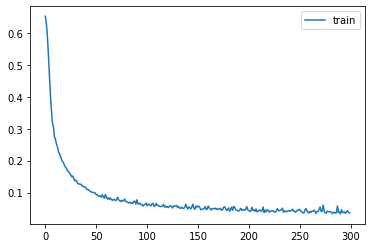

In [94]:
fit(m, c, s, i)

Model lstm
Number of classes 2
Number of steps 2
Number of indicators 6
              precision    recall  f1-score   support

           S    0.98235   0.98622   0.98428       508
           B    0.98571   0.98171   0.98371       492

    accuracy                        0.98400      1000
   macro avg    0.98403   0.98396   0.98399      1000
weighted avg    0.98401   0.98400   0.98400      1000

Confusion matrix, without normalization
[[501   7]
 [  9 483]]


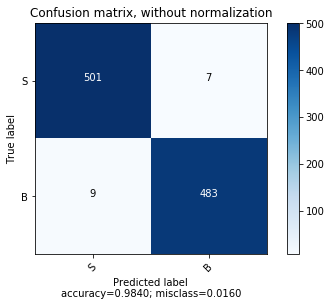

[0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 

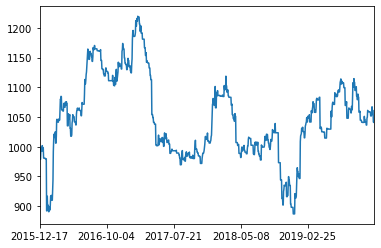

In [95]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3999/3999 [==============================] - 6s 1ms/step - loss: 0.6147 - accuracy: 0.6634TA: 41
Epoch 2/300
3999/3999 [==============================] - 1s 313us/step - loss: 0.5599 - accuracy: 0.7294
Epoch 3/300
3999/3999 [==============================] - 3s 689us/step - loss: 0.4806 - accuracy: 0.7912
Epoch 4/300
3999/3999 [==============================] - 3s 696us/step - loss: 0.4164 - accuracy: 0.8260
Epoch 5/300
3999/3999 [==============================] - 2s 446us/step - loss: 0.3844 - accuracy: 0.8430
Epoch 6/300
3999/3999 [==============================] - 1s 370us/step - loss: 0.3678 - accuracy: 0.8437
Epoch 7/300
3999/3999 [==============================] - 2s 525us/step - loss: 0.3454 - accuracy: 0.8585
Epoch 8/300
3999/3999 [==============================] - 2s 411us/step - loss: 0.3335 - accuracy: 0.8637
Epoch 9/300
3999/3999 [==============================] - 1s 304us/step - loss: 0.3181 - accuracy: 0.8715
Epoch 10/300
3999/3999 [===========================

3999/3999 [==============================] - 1s 199us/step - loss: 0.0742 - accuracy: 0.9742
Epoch 79/300
3999/3999 [==============================] - 1s 196us/step - loss: 0.0710 - accuracy: 0.9767
Epoch 80/300
3999/3999 [==============================] - 1s 187us/step - loss: 0.0654 - accuracy: 0.9797
Epoch 81/300
3999/3999 [==============================] - 1s 222us/step - loss: 0.0787 - accuracy: 0.9707
Epoch 82/300
3999/3999 [==============================] - 1s 209us/step - loss: 0.0756 - accuracy: 0.9700
Epoch 83/300
3999/3999 [==============================] - 1s 197us/step - loss: 0.0746 - accuracy: 0.9750
Epoch 84/300
3999/3999 [==============================] - 1s 224us/step - loss: 0.0640 - accuracy: 0.9790
Epoch 85/300
3999/3999 [==============================] - 1s 249us/step - loss: 0.0691 - accuracy: 0.9757
Epoch 86/300
3999/3999 [==============================] - 1s 207us/step - loss: 0.0625 - accuracy: 0.9807
Epoch 87/300
3999/3999 [==============================] - 1

3999/3999 [==============================] - 1s 307us/step - loss: 0.0480 - accuracy: 0.9797
Epoch 155/300
3999/3999 [==============================] - 1s 314us/step - loss: 0.0509 - accuracy: 0.9802
Epoch 156/300
3999/3999 [==============================] - 1s 309us/step - loss: 0.0503 - accuracy: 0.9815
Epoch 157/300
3999/3999 [==============================] - 1s 298us/step - loss: 0.0560 - accuracy: 0.9752
Epoch 158/300
3999/3999 [==============================] - 1s 289us/step - loss: 0.0461 - accuracy: 0.9840
Epoch 159/300
3999/3999 [==============================] - 1s 269us/step - loss: 0.0436 - accuracy: 0.9867
Epoch 160/300
3999/3999 [==============================] - 1s 243us/step - loss: 0.0482 - accuracy: 0.9827
Epoch 161/300
3999/3999 [==============================] - 1s 318us/step - loss: 0.0415 - accuracy: 0.9890
Epoch 162/300
3999/3999 [==============================] - 1s 248us/step - loss: 0.0434 - accuracy: 0.9860
Epoch 163/300
3999/3999 [==========================

3999/3999 [==============================] - 1s 259us/step - loss: 0.0621 - accuracy: 0.9745
Epoch 231/300
3999/3999 [==============================] - 1s 261us/step - loss: 0.0475 - accuracy: 0.9812
Epoch 232/300
3999/3999 [==============================] - 1s 256us/step - loss: 0.0399 - accuracy: 0.9850
Epoch 233/300
3999/3999 [==============================] - 1s 237us/step - loss: 0.0483 - accuracy: 0.9770
Epoch 234/300
3999/3999 [==============================] - 1s 235us/step - loss: 0.0604 - accuracy: 0.9742
Epoch 235/300
3999/3999 [==============================] - 1s 251us/step - loss: 0.0408 - accuracy: 0.9872
Epoch 236/300
3999/3999 [==============================] - 1s 258us/step - loss: 0.0379 - accuracy: 0.9865
Epoch 237/300
3999/3999 [==============================] - 1s 246us/step - loss: 0.0362 - accuracy: 0.9875
Epoch 238/300
3999/3999 [==============================] - 1s 236us/step - loss: 0.0363 - accuracy: 0.9855
Epoch 239/300
3999/3999 [==========================

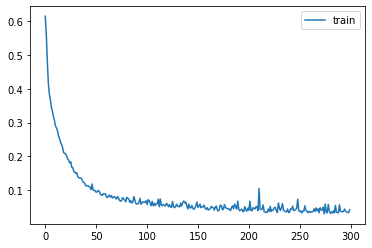

In [96]:
fit(m, c, s, i)

Model lstm
Number of classes 2
Number of steps 2
Number of indicators 8
              precision    recall  f1-score   support

           S    0.99197   0.97244   0.98211       508
           B    0.97211   0.99187   0.98189       492

    accuracy                        0.98200      1000
   macro avg    0.98204   0.98216   0.98200      1000
weighted avg    0.98220   0.98200   0.98200      1000

Confusion matrix, without normalization
[[494  14]
 [  4 488]]


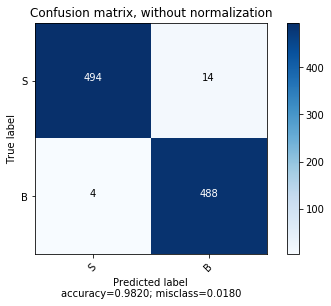

[0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 

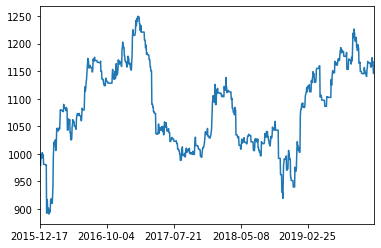

In [97]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3999/3999 [==============================] - 6s 2ms/step - loss: 0.6899 - accuracy: 0.6157
Epoch 2/300
3999/3999 [==============================] - 1s 315us/step - loss: 0.5900 - accuracy: 0.6892
Epoch 3/300
3999/3999 [==============================] - 1s 296us/step - loss: 0.5375 - accuracy: 0.7294
Epoch 4/300
3999/3999 [==============================] - 1s 293us/step - loss: 0.4763 - accuracy: 0.7742
Epoch 5/300
3999/3999 [==============================] - 1s 295us/step - loss: 0.4374 - accuracy: 0.8045
Epoch 6/300
3999/3999 [==============================] - 1s 290us/step - loss: 0.3927 - accuracy: 0.8257
Epoch 7/300
3999/3999 [==============================] - 1s 299us/step - loss: 0.3534 - accuracy: 0.8470
Epoch 8/300
3999/3999 [==============================] - 1s 296us/step - loss: 0.3240 - accuracy: 0.8687
Epoch 9/300
3999/3999 [==============================] - 1s 327us/step - loss: 0.3016 - accuracy: 0.8712
Epoch 10/300
3999/3999 [==============================] -

3999/3999 [==============================] - 2s 450us/step - loss: 0.0388 - accuracy: 0.9895
Epoch 79/300
3999/3999 [==============================] - 1s 362us/step - loss: 0.0373 - accuracy: 0.9885
Epoch 80/300
3999/3999 [==============================] - 1s 366us/step - loss: 0.0334 - accuracy: 0.9885
Epoch 81/300
3999/3999 [==============================] - 1s 355us/step - loss: 0.0378 - accuracy: 0.9897
Epoch 82/300
3999/3999 [==============================] - 1s 272us/step - loss: 0.0342 - accuracy: 0.9892
Epoch 83/300
3999/3999 [==============================] - 2s 377us/step - loss: 0.0698 - accuracy: 0.9787
Epoch 84/300
3999/3999 [==============================] - 1s 335us/step - loss: 0.0701 - accuracy: 0.9772
Epoch 85/300
3999/3999 [==============================] - 1s 319us/step - loss: 0.0702 - accuracy: 0.9750
Epoch 86/300
3999/3999 [==============================] - 1s 343us/step - loss: 0.0546 - accuracy: 0.9845
Epoch 87/300
3999/3999 [==============================] - 1

3999/3999 [==============================] - 2s 392us/step - loss: 0.0778 - accuracy: 0.9762
Epoch 155/300
3999/3999 [==============================] - 2s 448us/step - loss: 0.0427 - accuracy: 0.9862
Epoch 156/300
3999/3999 [==============================] - 2s 429us/step - loss: 0.0394 - accuracy: 0.9885
Epoch 157/300
3999/3999 [==============================] - 1s 337us/step - loss: 0.0407 - accuracy: 0.9885
Epoch 158/300
3999/3999 [==============================] - 1s 287us/step - loss: 0.0195 - accuracy: 0.9962
Epoch 159/300
3999/3999 [==============================] - 1s 298us/step - loss: 0.0184 - accuracy: 0.9942
Epoch 160/300
3999/3999 [==============================] - 1s 292us/step - loss: 0.0207 - accuracy: 0.9950
Epoch 161/300
3999/3999 [==============================] - 1s 284us/step - loss: 0.0344 - accuracy: 0.9902
Epoch 162/300
3999/3999 [==============================] - 1s 278us/step - loss: 0.0397 - accuracy: 0.98670s
Epoch 163/300
3999/3999 [========================

3999/3999 [==============================] - 1s 335us/step - loss: 0.0398 - accuracy: 0.9880
Epoch 231/300
3999/3999 [==============================] - 1s 302us/step - loss: 0.0525 - accuracy: 0.9815
Epoch 232/300
3999/3999 [==============================] - 1s 371us/step - loss: 0.0286 - accuracy: 0.9935
Epoch 233/300
3999/3999 [==============================] - 2s 450us/step - loss: 0.0609 - accuracy: 0.9817
Epoch 234/300
3999/3999 [==============================] - 1s 334us/step - loss: 0.0661 - accuracy: 0.9842
Epoch 235/300
3999/3999 [==============================] - 1s 292us/step - loss: 0.0429 - accuracy: 0.9867
Epoch 236/300
3999/3999 [==============================] - 1s 271us/step - loss: 0.0171 - accuracy: 0.9962
Epoch 237/300
3999/3999 [==============================] - 2s 401us/step - loss: 0.0142 - accuracy: 0.9955
Epoch 238/300
3999/3999 [==============================] - 2s 503us/step - loss: 0.0118 - accuracy: 0.9972
Epoch 239/300
3999/3999 [==========================

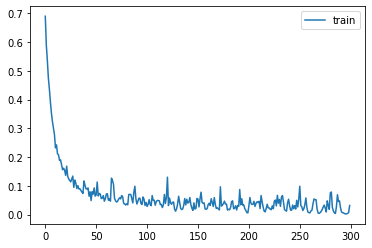

In [98]:
fit(m, c, s, i)

Model lstm
Number of classes 2
Number of steps 2
Number of indicators 11
              precision    recall  f1-score   support

           S    0.94050   0.96457   0.95238       508
           B    0.96242   0.93699   0.94954       492

    accuracy                        0.95100      1000
   macro avg    0.95146   0.95078   0.95096      1000
weighted avg    0.95128   0.95100   0.95098      1000

Confusion matrix, without normalization
[[490  18]
 [ 31 461]]


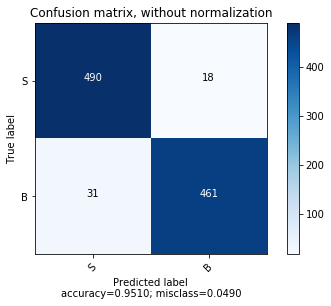

[0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 

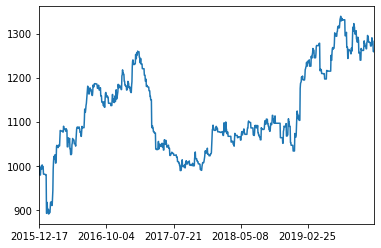

In [99]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 8s 2ms/step - loss: 0.6641 - accuracy: 0.5958
Epoch 2/300
3996/3996 [==============================] - 3s 789us/step - loss: 0.5811 - accuracy: 0.7075
Epoch 3/300
3996/3996 [==============================] - 3s 657us/step - loss: 0.5473 - accuracy: 0.7295
Epoch 4/300
3996/3996 [==============================] - 2s 607us/step - loss: 0.5268 - accuracy: 0.7497
Epoch 5/300
3996/3996 [==============================] - 3s 711us/step - loss: 0.5221 - accuracy: 0.7465
Epoch 6/300
3996/3996 [==============================] - 2s 470us/step - loss: 0.5077 - accuracy: 0.7625
Epoch 7/300
3996/3996 [==============================] - 3s 673us/step - loss: 0.5038 - accuracy: 0.7660
Epoch 8/300
3996/3996 [==============================] - 3s 722us/step - loss: 0.5071 - accuracy: 0.7668
Epoch 9/300
3996/3996 [==============================] - 3s 754us/step - loss: 0.5015 - accuracy: 0.7633
Epoch 10/300
3996/3996 [==============================] -

Epoch 78/300
3996/3996 [==============================] - 2s 603us/step - loss: 0.4354 - accuracy: 0.8008
Epoch 79/300
3996/3996 [==============================] - 2s 506us/step - loss: 0.4356 - accuracy: 0.8003
Epoch 80/300
3996/3996 [==============================] - 2s 623us/step - loss: 0.4367 - accuracy: 0.8018
Epoch 81/300
3996/3996 [==============================] - 2s 554us/step - loss: 0.4314 - accuracy: 0.7970
Epoch 82/300
3996/3996 [==============================] - 2s 553us/step - loss: 0.4331 - accuracy: 0.8011
Epoch 83/300
3996/3996 [==============================] - 2s 486us/step - loss: 0.4366 - accuracy: 0.8053
Epoch 84/300
3996/3996 [==============================] - 2s 584us/step - loss: 0.4315 - accuracy: 0.8008
Epoch 85/300
3996/3996 [==============================] - 2s 499us/step - loss: 0.4327 - accuracy: 0.8003
Epoch 86/300
3996/3996 [==============================] - 2s 507us/step - loss: 0.4366 - accuracy: 0.7960
Epoch 87/300
3996/3996 [======================

3996/3996 [==============================] - 3s 627us/step - loss: 0.4206 - accuracy: 0.8046
Epoch 155/300
3996/3996 [==============================] - 2s 492us/step - loss: 0.4213 - accuracy: 0.7998
Epoch 156/300
3996/3996 [==============================] - 2s 497us/step - loss: 0.4162 - accuracy: 0.8063
Epoch 157/300
3996/3996 [==============================] - 2s 536us/step - loss: 0.4156 - accuracy: 0.8018
Epoch 158/300
3996/3996 [==============================] - 2s 560us/step - loss: 0.4203 - accuracy: 0.8086
Epoch 159/300
3996/3996 [==============================] - 2s 510us/step - loss: 0.4174 - accuracy: 0.8048
Epoch 160/300
3996/3996 [==============================] - 2s 411us/step - loss: 0.4148 - accuracy: 0.8083
Epoch 161/300
3996/3996 [==============================] - 2s 568us/step - loss: 0.4182 - accuracy: 0.8113
Epoch 162/300
3996/3996 [==============================] - 2s 545us/step - loss: 0.4174 - accuracy: 0.8048
Epoch 163/300
3996/3996 [==========================

3996/3996 [==============================] - 2s 557us/step - loss: 0.3987 - accuracy: 0.8108
Epoch 231/300
3996/3996 [==============================] - 2s 621us/step - loss: 0.3987 - accuracy: 0.8111
Epoch 232/300
3996/3996 [==============================] - 3s 630us/step - loss: 0.4006 - accuracy: 0.8126
Epoch 233/300
3996/3996 [==============================] - 2s 615us/step - loss: 0.3980 - accuracy: 0.8131
Epoch 234/300
3996/3996 [==============================] - 2s 473us/step - loss: 0.3997 - accuracy: 0.8103
Epoch 235/300
3996/3996 [==============================] - 2s 494us/step - loss: 0.3973 - accuracy: 0.8183
Epoch 236/300
3996/3996 [==============================] - 2s 513us/step - loss: 0.4008 - accuracy: 0.8133
Epoch 237/300
3996/3996 [==============================] - 2s 612us/step - loss: 0.3987 - accuracy: 0.8138
Epoch 238/300
3996/3996 [==============================] - 3s 629us/step - loss: 0.3993 - accuracy: 0.8111
Epoch 239/300
3996/3996 [==========================

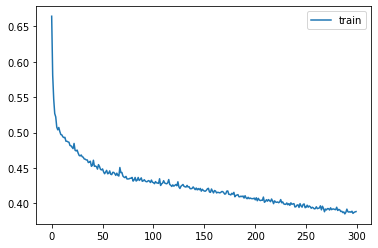

In [100]:
fit(m, c, s, i)

Model lstm
Number of classes 2
Number of steps 5
Number of indicators 3
              precision    recall  f1-score   support

           S    0.77128   0.85630   0.81157       508
           B    0.83257   0.73780   0.78233       492

    accuracy                        0.79800      1000
   macro avg    0.80192   0.79705   0.79695      1000
weighted avg    0.80143   0.79800   0.79718      1000

Confusion matrix, without normalization
[[435  73]
 [129 363]]


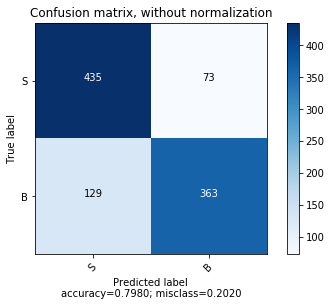

[0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 

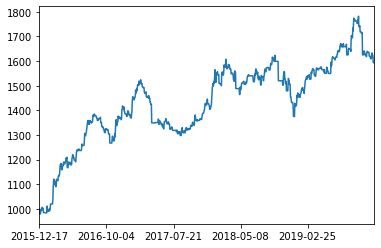

In [101]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 11s 3ms/step - loss: 0.6556 - accuracy: 0.6201
Epoch 2/300
3996/3996 [==============================] - 3s 810us/step - loss: 0.5569 - accuracy: 0.7275
Epoch 3/300
3996/3996 [==============================] - 4s 903us/step - loss: 0.5083 - accuracy: 0.7540
Epoch 4/300
3996/3996 [==============================] - 3s 791us/step - loss: 0.4633 - accuracy: 0.7915
Epoch 5/300
3996/3996 [==============================] - 3s 816us/step - loss: 0.4120 - accuracy: 0.8171
Epoch 6/300
3996/3996 [==============================] - 3s 761us/step - loss: 0.3695 - accuracy: 0.8423
Epoch 7/300
3996/3996 [==============================] - 3s 857us/step - loss: 0.3383 - accuracy: 0.8574
Epoch 8/300
3996/3996 [==============================] - 3s 687us/step - loss: 0.3127 - accuracy: 0.8654
Epoch 9/300
3996/3996 [==============================] - 4s 1ms/step - loss: 0.2773 - accuracy: 0.8809
Epoch 10/300
3996/3996 [==============================] - 

3996/3996 [==============================] - 3s 664us/step - loss: 0.0624 - accuracy: 0.9772
Epoch 79/300
3996/3996 [==============================] - 3s 663us/step - loss: 0.0645 - accuracy: 0.9750
Epoch 80/300
3996/3996 [==============================] - 3s 770us/step - loss: 0.0842 - accuracy: 0.9675
Epoch 81/300
3996/3996 [==============================] - 3s 647us/step - loss: 0.0696 - accuracy: 0.9702
Epoch 82/300
3996/3996 [==============================] - 3s 657us/step - loss: 0.0777 - accuracy: 0.9650
Epoch 83/300
3996/3996 [==============================] - 3s 665us/step - loss: 0.0585 - accuracy: 0.9765
Epoch 84/300
3996/3996 [==============================] - 3s 635us/step - loss: 0.0657 - accuracy: 0.9735
Epoch 85/300
3996/3996 [==============================] - 3s 656us/step - loss: 0.0634 - accuracy: 0.9750
Epoch 86/300
3996/3996 [==============================] - 3s 638us/step - loss: 0.0610 - accuracy: 0.9722
Epoch 87/300
3996/3996 [==============================] - 3

3996/3996 [==============================] - 3s 629us/step - loss: 0.0500 - accuracy: 0.9792
Epoch 155/300
3996/3996 [==============================] - 3s 647us/step - loss: 0.0504 - accuracy: 0.9815
Epoch 156/300
3996/3996 [==============================] - 3s 628us/step - loss: 0.0616 - accuracy: 0.9732
Epoch 157/300
3996/3996 [==============================] - 3s 634us/step - loss: 0.0683 - accuracy: 0.9695
Epoch 158/300
3996/3996 [==============================] - 3s 681us/step - loss: 0.0402 - accuracy: 0.9860
Epoch 159/300
3996/3996 [==============================] - 3s 669us/step - loss: 0.0410 - accuracy: 0.9842
Epoch 160/300
3996/3996 [==============================] - 3s 674us/step - loss: 0.0769 - accuracy: 0.9687
Epoch 161/300
3996/3996 [==============================] - 3s 697us/step - loss: 0.0576 - accuracy: 0.9750
Epoch 162/300
3996/3996 [==============================] - 3s 641us/step - loss: 0.0450 - accuracy: 0.9817
Epoch 163/300
3996/3996 [==========================

3996/3996 [==============================] - 5s 1ms/step - loss: 0.0512 - accuracy: 0.9795
Epoch 231/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.0389 - accuracy: 0.9862
Epoch 232/300
3996/3996 [==============================] - 4s 1ms/step - loss: 0.0402 - accuracy: 0.9865
Epoch 233/300
3996/3996 [==============================] - 4s 1ms/step - loss: 0.0466 - accuracy: 0.9800
Epoch 234/300
3996/3996 [==============================] - 4s 928us/step - loss: 0.0410 - accuracy: 0.9822
Epoch 235/300
3996/3996 [==============================] - 4s 933us/step - loss: 0.0578 - accuracy: 0.9767
Epoch 236/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.0395 - accuracy: 0.9855
Epoch 237/300
3996/3996 [==============================] - 4s 965us/step - loss: 0.0341 - accuracy: 0.9885
Epoch 238/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.0302 - accuracy: 0.9892
Epoch 239/300
3996/3996 [==============================] - 6s 1

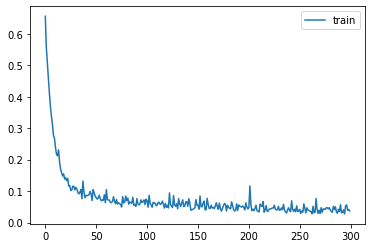

In [102]:
fit(m, c, s, i)

Model lstm
Number of classes 2
Number of steps 5
Number of indicators 6
              precision    recall  f1-score   support

           S    0.98971   0.94685   0.96781       508
           B    0.94747   0.98984   0.96819       492

    accuracy                        0.96800      1000
   macro avg    0.96859   0.96834   0.96800      1000
weighted avg    0.96893   0.96800   0.96800      1000

Confusion matrix, without normalization
[[481  27]
 [  5 487]]


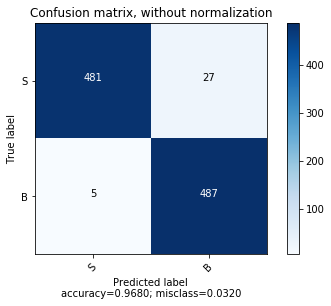

[0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 

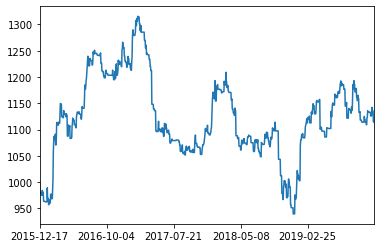

In [103]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 17s 4ms/step - loss: 0.5928 - accuracy: 0.6884
Epoch 2/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.5193 - accuracy: 0.7565
Epoch 3/300
3996/3996 [==============================] - 4s 1ms/step - loss: 0.4514 - accuracy: 0.8023
Epoch 4/300
3996/3996 [==============================] - 4s 922us/step - loss: 0.3937 - accuracy: 0.8266
Epoch 5/300
3996/3996 [==============================] - 4s 922us/step - loss: 0.3585 - accuracy: 0.8443
Epoch 6/300
3996/3996 [==============================] - 4s 1ms/step - loss: 0.3339 - accuracy: 0.8524
Epoch 7/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.3044 - accuracy: 0.8676
Epoch 8/300
3996/3996 [==============================] - 4s 1ms/step - loss: 0.2852 - accuracy: 0.8811
Epoch 9/300
3996/3996 [==============================] - 4s 1ms/step - loss: 0.2603 - accuracy: 0.8916
Epoch 10/300
3996/3996 [==============================] - 5s 1ms/ste

3996/3996 [==============================] - 4s 1ms/step - loss: 0.0586 - accuracy: 0.9795
Epoch 80/300
3996/3996 [==============================] - 4s 994us/step - loss: 0.0572 - accuracy: 0.9802
Epoch 81/300
3996/3996 [==============================] - 4s 952us/step - loss: 0.0504 - accuracy: 0.9812
Epoch 82/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.0612 - accuracy: 0.9775
Epoch 83/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.0676 - accuracy: 0.9760
Epoch 84/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.0602 - accuracy: 0.9767
Epoch 85/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.0526 - accuracy: 0.9822
Epoch 86/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.0583 - accuracy: 0.9772
Epoch 87/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.0662 - accuracy: 0.9730
Epoch 88/300
3996/3996 [==============================] - 4s 984us/step -

3996/3996 [==============================] - 4s 967us/step - loss: 0.0411 - accuracy: 0.9862
Epoch 158/300
3996/3996 [==============================] - 4s 940us/step - loss: 0.0314 - accuracy: 0.9897
Epoch 159/300
3996/3996 [==============================] - 4s 997us/step - loss: 0.0231 - accuracy: 0.9930
Epoch 160/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.0419 - accuracy: 0.9870
Epoch 161/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.0587 - accuracy: 0.9792
Epoch 162/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.0266 - accuracy: 0.9917
Epoch 163/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.0227 - accuracy: 0.9937
Epoch 164/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.0182 - accuracy: 0.9952
Epoch 165/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.0243 - accuracy: 0.9925
Epoch 166/300
3996/3996 [==============================] - 4s 1

3996/3996 [==============================] - 6s 1ms/step - loss: 0.0111 - accuracy: 0.9987
Epoch 235/300
3996/3996 [==============================] - 6s 1ms/step - loss: 0.0079 - accuracy: 0.9985
Epoch 236/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.0110 - accuracy: 0.9965
Epoch 237/300
3996/3996 [==============================] - 7s 2ms/step - loss: 0.0563 - accuracy: 0.9797
Epoch 238/300
3996/3996 [==============================] - 7s 2ms/step - loss: 0.0225 - accuracy: 0.9922
Epoch 239/300
3996/3996 [==============================] - 7s 2ms/step - loss: 0.0218 - accuracy: 0.9932
Epoch 240/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.0102 - accuracy: 0.9977
Epoch 241/300
3996/3996 [==============================] - 6s 1ms/step - loss: 0.0124 - accuracy: 0.9967
Epoch 242/300
3996/3996 [==============================] - 6s 1ms/step - loss: 0.0105 - accuracy: 0.9975
Epoch 243/300
3996/3996 [==============================] - 5s 1ms/ste

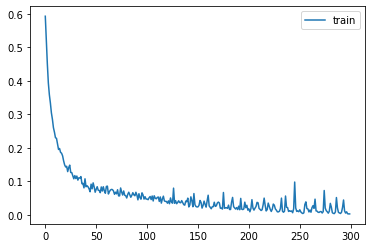

In [104]:
fit(m, c, s, i)

Model lstm
Number of classes 2
Number of steps 5
Number of indicators 8
              precision    recall  f1-score   support

           S    0.96573   0.94291   0.95418       508
           B    0.94246   0.96545   0.95382       492

    accuracy                        0.95400      1000
   macro avg    0.95409   0.95418   0.95400      1000
weighted avg    0.95428   0.95400   0.95400      1000

Confusion matrix, without normalization
[[479  29]
 [ 17 475]]


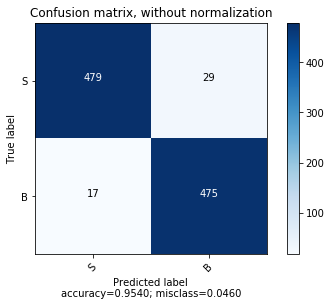

[0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 

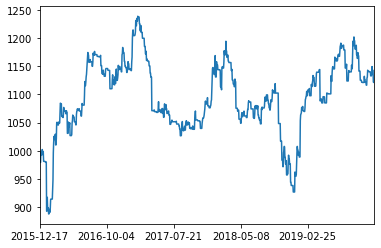

In [105]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 16s 4ms/step - loss: 0.8366 - accuracy: 0.5958
Epoch 2/300
3996/3996 [==============================] - 6s 2ms/step - loss: 0.5557 - accuracy: 0.7147
Epoch 3/300
3996/3996 [==============================] - 5s 1ms/step - loss: 0.4945 - accuracy: 0.7610
Epoch 4/300
3996/3996 [==============================] - 6s 2ms/step - loss: 0.4375 - accuracy: 0.7965
Epoch 5/300
3996/3996 [==============================] - 6s 2ms/step - loss: 0.3795 - accuracy: 0.8281
Epoch 6/300
3996/3996 [==============================] - 6s 1ms/step - loss: 0.3561 - accuracy: 0.8511
Epoch 7/300
3996/3996 [==============================] - 6s 1ms/step - loss: 0.3249 - accuracy: 0.8596
Epoch 8/300
3996/3996 [==============================] - 6s 1ms/step - loss: 0.3011 - accuracy: 0.8709
Epoch 9/300
3996/3996 [==============================] - 6s 1ms/step - loss: 0.2789 - accuracy: 0.8796
Epoch 10/300
3996/3996 [==============================] - 6s 1ms/step - 

3996/3996 [==============================] - 6s 2ms/step - loss: 0.0278 - accuracy: 0.9952
Epoch 80/300
3996/3996 [==============================] - 6s 2ms/step - loss: 0.0381 - accuracy: 0.9887
Epoch 81/300
3996/3996 [==============================] - 6s 2ms/step - loss: 0.0266 - accuracy: 0.9927
Epoch 82/300
3996/3996 [==============================] - 6s 2ms/step - loss: 0.0263 - accuracy: 0.9925
Epoch 83/300
3996/3996 [==============================] - 6s 2ms/step - loss: 0.0423 - accuracy: 0.9872
Epoch 84/300
3996/3996 [==============================] - 6s 2ms/step - loss: 0.0412 - accuracy: 0.9855
Epoch 85/300
3996/3996 [==============================] - 7s 2ms/step - loss: 0.0317 - accuracy: 0.9897
Epoch 86/300
3996/3996 [==============================] - 8s 2ms/step - loss: 0.1036 - accuracy: 0.9647
Epoch 87/300
3996/3996 [==============================] - 8s 2ms/step - loss: 0.0607 - accuracy: 0.9795
Epoch 88/300
3996/3996 [==============================] - 11s 3ms/step - loss

3996/3996 [==============================] - 11s 3ms/step - loss: 0.0266 - accuracy: 0.9920
Epoch 158/300
3996/3996 [==============================] - 8s 2ms/step - loss: 0.0155 - accuracy: 0.9970
Epoch 159/300
3996/3996 [==============================] - 8s 2ms/step - loss: 0.0116 - accuracy: 0.9972
Epoch 160/300
3996/3996 [==============================] - 8s 2ms/step - loss: 0.0197 - accuracy: 0.9935
Epoch 161/300
3996/3996 [==============================] - 7s 2ms/step - loss: 0.0264 - accuracy: 0.9925
Epoch 162/300
3996/3996 [==============================] - 6s 2ms/step - loss: 0.0336 - accuracy: 0.9912
Epoch 163/300
3996/3996 [==============================] - 7s 2ms/step - loss: 0.0619 - accuracy: 0.9755
Epoch 164/300
3996/3996 [==============================] - 8s 2ms/step - loss: 0.0327 - accuracy: 0.9872
Epoch 165/300
3996/3996 [==============================] - 7s 2ms/step - loss: 0.0242 - accuracy: 0.9927
Epoch 166/300
3996/3996 [==============================] - 6s 2ms/st

3996/3996 [==============================] - 9s 2ms/step - loss: 0.0327 - accuracy: 0.9897
Epoch 235/300
3996/3996 [==============================] - 9s 2ms/step - loss: 0.0313 - accuracy: 0.9902
Epoch 236/300
3996/3996 [==============================] - 8s 2ms/step - loss: 0.0359 - accuracy: 0.9905
Epoch 237/300
3996/3996 [==============================] - 10s 2ms/step - loss: 0.0398 - accuracy: 0.9862
Epoch 238/300
3996/3996 [==============================] - 11s 3ms/step - loss: 0.0375 - accuracy: 0.9887
Epoch 239/300
3996/3996 [==============================] - 10s 2ms/step - loss: 0.0263 - accuracy: 0.9915
Epoch 240/300
3996/3996 [==============================] - 9s 2ms/step - loss: 0.0153 - accuracy: 0.9960
Epoch 241/300
3996/3996 [==============================] - 10s 3ms/step - loss: 0.0196 - accuracy: 0.9925
Epoch 242/300
3996/3996 [==============================] - 11s 3ms/step - loss: 0.0152 - accuracy: 0.9957
Epoch 243/300
3996/3996 [==============================] - 11s 3

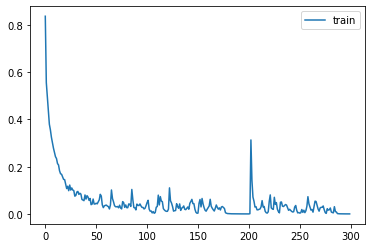

In [106]:
fit(m, c, s, i)

Model lstm
Number of classes 2
Number of steps 5
Number of indicators 11
              precision    recall  f1-score   support

           S    0.95688   0.91732   0.93668       508
           B    0.91813   0.95732   0.93731       492

    accuracy                        0.93700      1000
   macro avg    0.93750   0.93732   0.93700      1000
weighted avg    0.93781   0.93700   0.93699      1000

Confusion matrix, without normalization
[[466  42]
 [ 21 471]]


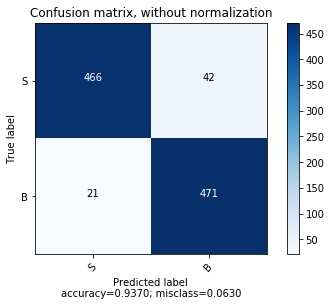

[0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 

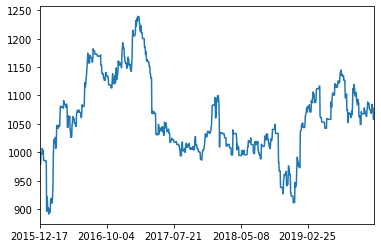

In [107]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3992/3992 [==============================] - 24s 6ms/step - loss: 0.6653 - accuracy: 0.6040
Epoch 2/300
3992/3992 [==============================] - 13s 3ms/step - loss: 0.5838 - accuracy: 0.7069
Epoch 3/300
3992/3992 [==============================] - 12s 3ms/step - loss: 0.5381 - accuracy: 0.7427
Epoch 4/300
3992/3992 [==============================] - 9s 2ms/step - loss: 0.5167 - accuracy: 0.7613
Epoch 5/300
3992/3992 [==============================] - 11s 3ms/step - loss: 0.5066 - accuracy: 0.7693
Epoch 6/300
3992/3992 [==============================] - 10s 3ms/step - loss: 0.5008 - accuracy: 0.7628
Epoch 7/300
3992/3992 [==============================] - 9s 2ms/step - loss: 0.4994 - accuracy: 0.7670
Epoch 8/300
3992/3992 [==============================] - 9s 2ms/step - loss: 0.4981 - accuracy: 0.7660
Epoch 9/300
3992/3992 [==============================] - 9s 2ms/step - loss: 0.4914 - accuracy: 0.7763
Epoch 10/300
3992/3992 [==============================] - 9s 2ms/ste

3992/3992 [==============================] - 6s 2ms/step - loss: 0.3795 - accuracy: 0.8324
Epoch 80/300
3992/3992 [==============================] - 7s 2ms/step - loss: 0.3783 - accuracy: 0.8294
Epoch 81/300
3992/3992 [==============================] - 7s 2ms/step - loss: 0.3793 - accuracy: 0.8332
Epoch 82/300
3992/3992 [==============================] - 7s 2ms/step - loss: 0.3752 - accuracy: 0.8317
Epoch 83/300
3992/3992 [==============================] - 7s 2ms/step - loss: 0.3900 - accuracy: 0.8269
Epoch 84/300
3992/3992 [==============================] - 7s 2ms/step - loss: 0.3788 - accuracy: 0.8342
Epoch 85/300
3992/3992 [==============================] - 6s 2ms/step - loss: 0.3737 - accuracy: 0.8312
Epoch 86/300
3992/3992 [==============================] - 6s 2ms/step - loss: 0.3706 - accuracy: 0.8349
Epoch 87/300
3992/3992 [==============================] - 6s 2ms/step - loss: 0.3739 - accuracy: 0.8304
Epoch 88/300
3992/3992 [==============================] - 6s 1ms/step - loss:

3992/3992 [==============================] - 4s 1ms/step - loss: 0.2860 - accuracy: 0.8735
Epoch 158/300
3992/3992 [==============================] - 5s 1ms/step - loss: 0.2842 - accuracy: 0.8783
Epoch 159/300
3992/3992 [==============================] - 5s 1ms/step - loss: 0.2801 - accuracy: 0.8803
Epoch 160/300
3992/3992 [==============================] - 5s 1ms/step - loss: 0.2756 - accuracy: 0.8803
Epoch 161/300
3992/3992 [==============================] - 5s 1ms/step - loss: 0.2743 - accuracy: 0.8873
Epoch 162/300
3992/3992 [==============================] - 5s 1ms/step - loss: 0.2803 - accuracy: 0.8828
Epoch 163/300
3992/3992 [==============================] - 5s 1ms/step - loss: 0.2816 - accuracy: 0.8805
Epoch 164/300
3992/3992 [==============================] - 5s 1ms/step - loss: 0.2709 - accuracy: 0.8845
Epoch 165/300
3992/3992 [==============================] - 5s 1ms/step - loss: 0.2651 - accuracy: 0.8848
Epoch 166/300
3992/3992 [==============================] - 5s 1ms/ste

Epoch 235/300
3992/3992 [==============================] - 5s 1ms/step - loss: 0.1564 - accuracy: 0.9349
Epoch 236/300
3992/3992 [==============================] - 5s 1ms/step - loss: 0.1578 - accuracy: 0.9324
Epoch 237/300
3992/3992 [==============================] - 6s 1ms/step - loss: 0.1628 - accuracy: 0.9329
Epoch 238/300
3992/3992 [==============================] - 6s 1ms/step - loss: 0.1741 - accuracy: 0.9321
Epoch 239/300
3992/3992 [==============================] - 6s 1ms/step - loss: 0.1805 - accuracy: 0.9254
Epoch 240/300
3992/3992 [==============================] - 6s 1ms/step - loss: 0.1403 - accuracy: 0.9466
Epoch 241/300
3992/3992 [==============================] - 5s 1ms/step - loss: 0.1488 - accuracy: 0.9436
Epoch 242/300
3992/3992 [==============================] - 6s 1ms/step - loss: 0.1559 - accuracy: 0.9356
Epoch 243/300
3992/3992 [==============================] - 5s 1ms/step - loss: 0.1463 - accuracy: 0.9449
Epoch 244/300
3992/3992 [==============================

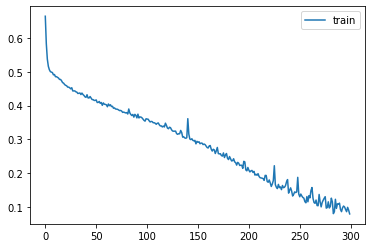

In [108]:
fit(m, c, s, i)

Model lstm
Number of classes 2
Number of steps 10
Number of indicators 3
              precision    recall  f1-score   support

           S    0.69844   0.70809   0.70323       507
           B    0.69485   0.68496   0.68987       492

    accuracy                        0.69670       999
   macro avg    0.69664   0.69652   0.69655       999
weighted avg    0.69667   0.69670   0.69665       999

Confusion matrix, without normalization
[[359 148]
 [155 337]]


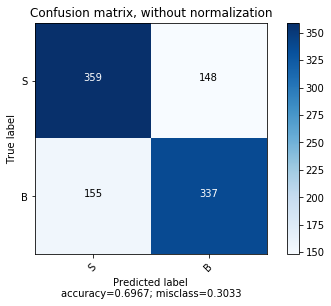

[1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 

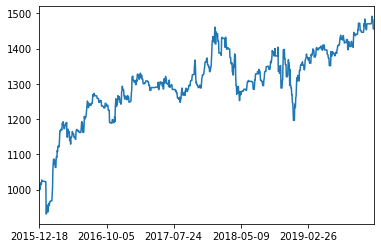

In [109]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3992/3992 [==============================] - 28s 7ms/step - loss: 0.6287 - accuracy: 0.6591
Epoch 2/300
3992/3992 [==============================] - 13s 3ms/step - loss: 0.5270 - accuracy: 0.7470
Epoch 3/300
3992/3992 [==============================] - 11s 3ms/step - loss: 0.4764 - accuracy: 0.7811
Epoch 4/300
3992/3992 [==============================] - 11s 3ms/step - loss: 0.3960 - accuracy: 0.8214
Epoch 5/300
3992/3992 [==============================] - 10s 2ms/step - loss: 0.3600 - accuracy: 0.8439
Epoch 6/300
3992/3992 [==============================] - 9s 2ms/step - loss: 0.3002 - accuracy: 0.8705
Epoch 7/300
3992/3992 [==============================] - 10s 2ms/step - loss: 0.2687 - accuracy: 0.8900
Epoch 8/300
3992/3992 [==============================] - 10s 3ms/step - loss: 0.2519 - accuracy: 0.9021
Epoch 9/300
3992/3992 [==============================] - 11s 3ms/step - loss: 0.2255 - accuracy: 0.9006
Epoch 10/300
3992/3992 [==============================] - 13s 3ms

3992/3992 [==============================] - 10s 3ms/step - loss: 0.0680 - accuracy: 0.9747
Epoch 80/300
3992/3992 [==============================] - 15s 4ms/step - loss: 0.0672 - accuracy: 0.9749
Epoch 81/300
3992/3992 [==============================] - 16s 4ms/step - loss: 0.0650 - accuracy: 0.9744 2s - l
Epoch 82/300
3992/3992 [==============================] - 15s 4ms/step - loss: 0.0833 - accuracy: 0.9702
Epoch 83/300
3992/3992 [==============================] - 16s 4ms/step - loss: 0.0783 - accuracy: 0.9682
Epoch 84/300
3992/3992 [==============================] - 12s 3ms/step - loss: 0.0699 - accuracy: 0.9760
Epoch 85/300
3992/3992 [==============================] - 12s 3ms/step - loss: 0.0657 - accuracy: 0.9760
Epoch 86/300
3992/3992 [==============================] - 13s 3ms/step - loss: 0.0738 - accuracy: 0.9709
Epoch 87/300
3992/3992 [==============================] - 15s 4ms/step - loss: 0.0755 - accuracy: 0.9765
Epoch 88/300
3992/3992 [==============================] - 13s

3992/3992 [==============================] - 12s 3ms/step - loss: 0.0425 - accuracy: 0.9872
Epoch 157/300
3992/3992 [==============================] - 13s 3ms/step - loss: 0.0512 - accuracy: 0.9810
Epoch 158/300
3992/3992 [==============================] - 13s 3ms/step - loss: 0.0392 - accuracy: 0.9885
Epoch 159/300
3992/3992 [==============================] - 12s 3ms/step - loss: 0.0341 - accuracy: 0.9892
Epoch 160/300
3992/3992 [==============================] - 13s 3ms/step - loss: 0.0387 - accuracy: 0.9860
Epoch 161/300
3992/3992 [==============================] - 13s 3ms/step - loss: 0.0487 - accuracy: 0.9805
Epoch 162/300
3992/3992 [==============================] - 13s 3ms/step - loss: 0.0447 - accuracy: 0.9835
Epoch 163/300
3992/3992 [==============================] - 13s 3ms/step - loss: 0.0379 - accuracy: 0.9880
Epoch 164/300
3992/3992 [==============================] - 13s 3ms/step - loss: 0.0866 - accuracy: 0.9792
Epoch 165/300
3992/3992 [==============================] - 1

3992/3992 [==============================] - 13s 3ms/step - loss: 0.0287 - accuracy: 0.9910
Epoch 234/300
3992/3992 [==============================] - 13s 3ms/step - loss: 0.0222 - accuracy: 0.9922
Epoch 235/300
3992/3992 [==============================] - 13s 3ms/step - loss: 0.0229 - accuracy: 0.9922
Epoch 236/300
3992/3992 [==============================] - 13s 3ms/step - loss: 0.0318 - accuracy: 0.9895
Epoch 237/300
3992/3992 [==============================] - 13s 3ms/step - loss: 0.0252 - accuracy: 0.9930
Epoch 238/300
3992/3992 [==============================] - 12s 3ms/step - loss: 0.0232 - accuracy: 0.9930
Epoch 239/300
3992/3992 [==============================] - 12s 3ms/step - loss: 0.0276 - accuracy: 0.9905
Epoch 240/300
3992/3992 [==============================] - 14s 4ms/step - loss: 0.0202 - accuracy: 0.9930
Epoch 241/300
3992/3992 [==============================] - 15s 4ms/step - loss: 0.0233 - accuracy: 0.9922
Epoch 242/300
3992/3992 [==============================] - 1

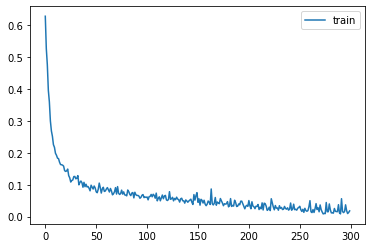

In [110]:
fit(m, c, s, i)

Model lstm
Number of classes 2
Number of steps 10
Number of indicators 6
              precision    recall  f1-score   support

           S    0.99574   0.92308   0.95803       507
           B    0.92628   0.99593   0.95984       492

    accuracy                        0.95896       999
   macro avg    0.96101   0.95951   0.95894       999
weighted avg    0.96153   0.95896   0.95893       999

Confusion matrix, without normalization
[[468  39]
 [  2 490]]


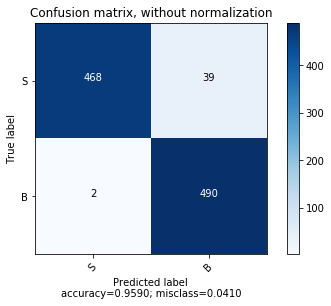

[1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 

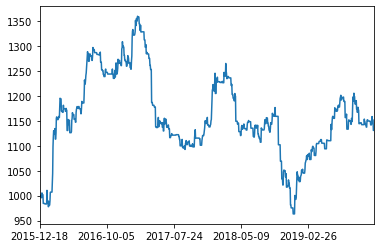

In [111]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3992/3992 [==============================] - 34s 8ms/step - loss: 0.5996 - accuracy: 0.6806
Epoch 2/300
3992/3992 [==============================] - 20s 5ms/step - loss: 0.5253 - accuracy: 0.7525
Epoch 3/300
3992/3992 [==============================] - 20s 5ms/step - loss: 0.4772 - accuracy: 0.7806
Epoch 4/300
3992/3992 [==============================] - 14s 4ms/step - loss: 0.4252 - accuracy: 0.8096
Epoch 5/300
3992/3992 [==============================] - 13s 3ms/step - loss: 0.3761 - accuracy: 0.8397
Epoch 6/300
3992/3992 [==============================] - 13s 3ms/step - loss: 0.3459 - accuracy: 0.8489
Epoch 7/300
3992/3992 [==============================] - 13s 3ms/step - loss: 0.3132 - accuracy: 0.8682
Epoch 8/300
3992/3992 [==============================] - 14s 3ms/step - loss: 0.2998 - accuracy: 0.8747
Epoch 9/300
3992/3992 [==============================] - 14s 4ms/step - loss: 0.2697 - accuracy: 0.8873
Epoch 10/300
3992/3992 [==============================] - 20s 5m

3992/3992 [==============================] - 20s 5ms/step - loss: 0.0556 - accuracy: 0.9825
Epoch 80/300
3992/3992 [==============================] - 21s 5ms/step - loss: 0.0414 - accuracy: 0.9847
Epoch 81/300
3992/3992 [==============================] - 21s 5ms/step - loss: 0.0435 - accuracy: 0.9875
Epoch 82/300
3992/3992 [==============================] - 20s 5ms/step - loss: 0.0408 - accuracy: 0.9880
Epoch 83/300
3992/3992 [==============================] - 21s 5ms/step - loss: 0.0420 - accuracy: 0.9845
Epoch 84/300
3992/3992 [==============================] - 21s 5ms/step - loss: 0.0517 - accuracy: 0.9825
Epoch 85/300
3992/3992 [==============================] - 21s 5ms/step - loss: 0.0518 - accuracy: 0.9852
Epoch 86/300
3992/3992 [==============================] - 21s 5ms/step - loss: 0.0359 - accuracy: 0.9892
Epoch 87/300
3992/3992 [==============================] - 21s 5ms/step - loss: 0.0415 - accuracy: 0.9865
Epoch 88/300
3992/3992 [==============================] - 20s 5ms/st

3992/3992 [==============================] - 20s 5ms/step - loss: 0.0077 - accuracy: 0.9982
Epoch 164/300
3992/3992 [==============================] - 19s 5ms/step - loss: 0.0143 - accuracy: 0.9950
Epoch 165/300
3992/3992 [==============================] - 20s 5ms/step - loss: 0.0061 - accuracy: 0.9992
Epoch 166/300
3992/3992 [==============================] - 19s 5ms/step - loss: 0.0053 - accuracy: 0.9990
Epoch 167/300
3992/3992 [==============================] - 20s 5ms/step - loss: 0.0322 - accuracy: 0.9897
Epoch 168/300
3992/3992 [==============================] - 19s 5ms/step - loss: 0.0157 - accuracy: 0.9955
Epoch 169/300
3992/3992 [==============================] - 19s 5ms/step - loss: 0.0081 - accuracy: 0.9992
Epoch 170/300
3992/3992 [==============================] - 19s 5ms/step - loss: 0.0065 - accuracy: 0.9990
Epoch 171/300
3992/3992 [==============================] - 17s 4ms/step - loss: 0.0200 - accuracy: 0.9945
Epoch 172/300
3992/3992 [==============================] - 1

3992/3992 [==============================] - 20s 5ms/step - loss: 0.0537 - accuracy: 0.9842
Epoch 241/300
3992/3992 [==============================] - 20s 5ms/step - loss: 0.0196 - accuracy: 0.9982
Epoch 242/300
3992/3992 [==============================] - 20s 5ms/step - loss: 0.0091 - accuracy: 0.9995
Epoch 243/300
3992/3992 [==============================] - 20s 5ms/step - loss: 0.0044 - accuracy: 1.0000
Epoch 244/300
3992/3992 [==============================] - 20s 5ms/step - loss: 0.0036 - accuracy: 0.9997
Epoch 245/300
3992/3992 [==============================] - 20s 5ms/step - loss: 0.0027 - accuracy: 1.0000
Epoch 246/300
3992/3992 [==============================] - 20s 5ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 247/300
3992/3992 [==============================] - 20s 5ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 248/300
3992/3992 [==============================] - 21s 5ms/step - loss: 0.0019 - accuracy: 0.9997
Epoch 249/300
3992/3992 [==============================] - 2

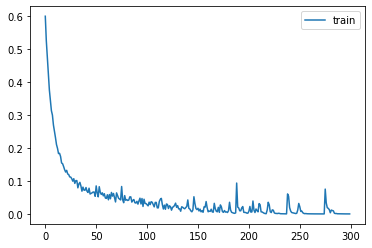

In [112]:
fit(m, c, s, i)

Model lstm
Number of classes 2
Number of steps 10
Number of indicators 8
              precision    recall  f1-score   support

           S    0.93037   0.94872   0.93945       507
           B    0.94606   0.92683   0.93634       492

    accuracy                        0.93794       999
   macro avg    0.93821   0.93777   0.93790       999
weighted avg    0.93810   0.93794   0.93792       999

Confusion matrix, without normalization
[[481  26]
 [ 36 456]]


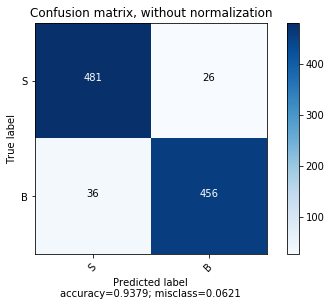

[1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 

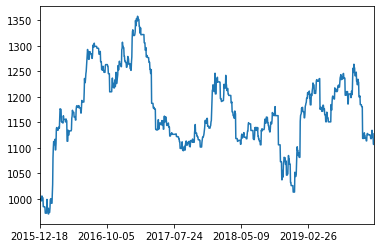

In [113]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

Epoch 1/300
3992/3992 [==============================] - 43s 11ms/step - loss: 1.1224 - accuracy: 0.6055
Epoch 2/300
3992/3992 [==============================] - 24s 6ms/step - loss: 0.5817 - accuracy: 0.6899
Epoch 3/300
3992/3992 [==============================] - 24s 6ms/step - loss: 0.5432 - accuracy: 0.7199
Epoch 4/300
3992/3992 [==============================] - 31s 8ms/step - loss: 0.5268 - accuracy: 0.7375
Epoch 5/300
3992/3992 [==============================] - 36s 9ms/step - loss: 0.4917 - accuracy: 0.7528
Epoch 6/300
3992/3992 [==============================] - 35s 9ms/step - loss: 0.4446 - accuracy: 0.7991
Epoch 7/300
3992/3992 [==============================] - 33s 8ms/step - loss: 0.4239 - accuracy: 0.7996
Epoch 8/300
3992/3992 [==============================] - 34s 8ms/step - loss: 0.3979 - accuracy: 0.8209
Epoch 9/300
3992/3992 [==============================] - 33s 8ms/step - loss: 0.3773 - accuracy: 0.8226
Epoch 10/300
3992/3992 [==============================] - 34s 9

3992/3992 [==============================] - 29s 7ms/step - loss: 0.0408 - accuracy: 0.9890
Epoch 80/300
3992/3992 [==============================] - 33s 8ms/step - loss: 0.0375 - accuracy: 0.9882
Epoch 81/300
3992/3992 [==============================] - 42s 11ms/step - loss: 0.0706 - accuracy: 0.9770
Epoch 82/300
3992/3992 [==============================] - 40s 10ms/step - loss: 0.0619 - accuracy: 0.9792
Epoch 83/300
3992/3992 [==============================] - 38s 10ms/step - loss: 0.0639 - accuracy: 0.9827
Epoch 84/300
3992/3992 [==============================] - 41s 10ms/step - loss: 0.0364 - accuracy: 0.9895
Epoch 85/300
3992/3992 [==============================] - 40s 10ms/step - loss: 0.0550 - accuracy: 0.9875
Epoch 86/300
3992/3992 [==============================] - 41s 10ms/step - loss: 0.0338 - accuracy: 0.9905
Epoch 87/300
3992/3992 [==============================] - 41s 10ms/step - loss: 0.0250 - accuracy: 0.9942
Epoch 88/300
3992/3992 [==============================] - 40s

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)

In [ ]:
fit(m, c, s, i)

In [ ]:
predict(m, c, s, i)
calculateProfit(preds[m][c][s][i])
m, c, s, i = get_next_value(m, c, s, i)